<a href="https://colab.research.google.com/github/Larraguibel/DNN_neuroscience/blob/main/blurring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importaciones

In [1]:
!pip install --upgrade torch torchvision

In [2]:
from torchvision import transforms, datasets
import torch
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np

In [3]:
cuda = True
train_batch_size = 32
test_batch_size = 124
best_loss = float("inf")
best_epoch = -1
dataset_path = './cifar10'
gsync_save = True

In [4]:
try:
    import torch
except ModuleNotFoundError:
    from os import path
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

    accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.1-{platform}-linux_x86_64.whl
    import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


try:
    import torchvision
except ModuleNotFoundError:
    !pip install -q torchvision

from torchvision import datasets, transforms


if gsync_save:
    try:
        import utils
    except ModuleNotFoundError:
        !wget https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/HEAD/utils.py
        import utils

try:
    from allconv import AllConvNet
except ModuleNotFoundError:
    !wget https://github.com/StefOe/all-conv-pytorch/raw/HEAD/allconv.py
    from allconv import AllConvNet

--2024-01-11 21:05:39--  https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/HEAD/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4519 (4.4K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   4.41K  --.-KB/s    in 0s      

2024-01-11 21:05:39 (44.8 MB/s) - ‘utils.py’ saved [4519/4519]

--2024-01-11 21:05:54--  https://github.com/StefOe/all-conv-pytorch/raw/HEAD/allconv.py
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/StefOe/all-conv-pytorch/8545bb3ff7ac4410e52d8db930f0485074073ea9/allconv.py [following]
--2024-01-11 21:05:54--  https://

## 2. Transformacion y carga de datos

In [5]:
# Damos acceso a google drive para guardar modelos

drive.mount('/content/gdrive');

Mounted at /content/gdrive


In [6]:
class NormalizeNegativeImages(object):

    def __call__(self, item):
        min_value_pixel = torch.min(item)
        if min_value_pixel < 0:
            item -= min_value_pixel
            item /= torch.max(item)
        return item

In [7]:
# Semilla para estandarizar resultados
torch.manual_seed(2320)

cuda = cuda and torch.cuda.is_available()
trainset = datasets.CIFAR10(root=dataset_path, train=True, download=True)
train_mean = trainset.data.mean(axis=(0, 1, 2)) / 255
train_std = trainset.data.std(axis=(0, 1, 2)) / 255

# Data normal (32x32)

transform_train = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(train_mean, train_std),
     NormalizeNegativeImages(),
     transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip()
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
    NormalizeNegativeImages()
])

#  transformaciones a 8x8 y de vuelta a 32x32 por bilineal

transform_test8x8 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
    NormalizeNegativeImages(),
    transforms.Resize((8,8)),
    transforms.Resize((32,32)),
])

transform_train8x8 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
    NormalizeNegativeImages(),
    transforms.Resize((8,8)),
    transforms.Resize((32,32)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip()
])

# Crearemos transformaciones sin randomizar nada para la resta de imágenes.

transform_train_no_random = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(train_mean, train_std),
     NormalizeNegativeImages()
])

transform_train8x8_no_random = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
    NormalizeNegativeImages(),
    transforms.Resize((8,8)),
    transforms.Resize((32,32))
])

100%|██████████| 170498071/170498071 [00:03<00:00, 48272760.88it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10


In [8]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

# Data normal

train_loader = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train),
    batch_size=train_batch_size, shuffle=True, **kwargs)


test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=dataset_path, train=False, download=True,
    transform=transform_test),
    batch_size=test_batch_size, shuffle=True, **kwargs)

# Data de entrenamiento blurreada

train_loader_blur = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train8x8),
    batch_size=train_batch_size, shuffle=True, **kwargs)

test_loader_blur = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=dataset_path, train=False, download=True,
    transform=transform_test8x8),
    batch_size=test_batch_size, shuffle=True, **kwargs)

# Data sin random ni data augmentation para mostrar imágenes

train_loader_no_random = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_test),
    batch_size=train_batch_size, shuffle=False, **kwargs)

train_loader_blur_no_random = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train8x8_no_random),
    batch_size=train_batch_size, shuffle=False, **kwargs)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


<class 'torch.Tensor'>


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


<class 'torch.Tensor'>


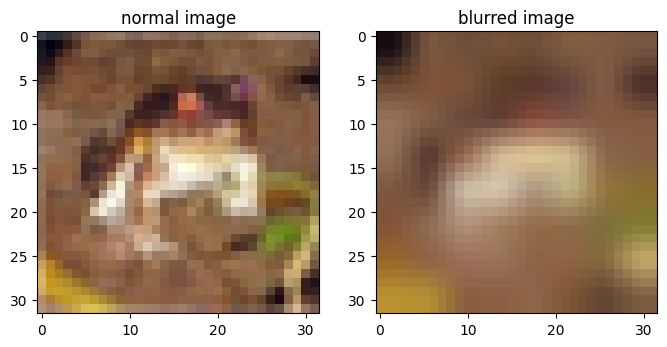

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
loaders = [train_loader_no_random, train_loader_blur_no_random]
label = ['normal image', 'blurred image']

for ax_index, loader in enumerate(loaders):
  for batch_data, batch_labels in loader:
    print(type(batch_data[0]))
    first_image = batch_data[0].permute(1, 2, 0).numpy()
    ax[ax_index].imshow(first_image)
    ax[ax_index].set_title(label[ax_index])
    break

plt.show()

## 3. Entrenamiento

In [10]:
criterion = nn.CrossEntropyLoss()

### 3.1 Funciones auxiliares


In [15]:
# Se definen funciones auxiliares

def initialize_model():

    '''
    Initialize a simple AllConvNet(3) and returns the model and all the
    needed information to train it.
    '''

    global cuda
    global criterion

    model = AllConvNet(3)

    if cuda:
        model.cuda()

    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = optim.lr_scheduler.MultiStepLR(
                optimizer, milestones=[200, 250, 300],
                gamma=0.1)

    return model, optimizer, criterion, scheduler


def pretty_print(text: str, char='*'):

    '''
    Prints in a prettier way with more space. You can change the asterisks
    if something else is prefered.
    '''

    n_char = len(text)
    print(
    f'''
    {char * n_char}
    {text}
    {char * n_char}
    ''')


def load_pretrained_model(drive_path=None):

    '''
    Reads the google drive path and load the model into an AllConvNet(3). It loads
    the optimizer as well. If no path is given, the function instanciates an
    AllConvNet(3) and the necessary classes for the training and testing.
    '''

    global cuda
    global criterion

    model = AllConvNet(3)

    if cuda:
      model.cuda()

    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    if drive_path is None:
      model_data = {
      'pretrained_epochs': 0,
      'model_state_dict': -1,
      'optimizer_state_dict': -1,
      'final_accuracy': 0,
      'training_data_dict': {},
      'test_data_dict': {}}

    else:
      model_data = torch.load(drive_path)
      model_state_dict = model_data['model_state_dict']
      opt_state_dict = model_data['optimizer_state_dict']
      model.load_state_dict(model_state_dict)
      optimizer.load_state_dict(opt_state_dict)

    scheduler = optim.lr_scheduler.MultiStepLR(
                optimizer, milestones=[200, 250, 300], gamma=0.1)

    return_dict = {'model': model,
                   'model_data': model_data,
                   'optimizer': optimizer,
                   'scheduler': scheduler}

    return return_dict


def save_training_data(save_dict: dict, acc: int, current_epoch: int,
                       total_epochs: int, save_every=10, altered=False):

    '''
    If the current epoch is a multiple of the a determined number, or is the last
    epoch, the function takes an existing dictionary containing the epochs as
    keys and the accuracy as value, and adds the acc of the current epoch.
    '''

    data_type = 'Normal'
    if altered:
      data_type = 'Altered'

    if current_epoch % save_every == 0 or current_epoch == total_epochs:
      round_acc = round(acc.item(), 2)
      save_dict[f'{current_epoch}'] = round_acc
      pretty_print(f'{data_type} Data Saved: ({current_epoch}, {round_acc})', char='-')
    return save_dict


def save_model(pretrained_epochs, model_state_dict, optimizer_state_dict,
               final_accuracy, training_data_dict, test_data_dict,
               checkpt_path):

    '''
    Saves the AllConvNet model with all the imporatant information in the given
    drive path.
    '''

    checkpoint = {
      'pretrained_epochs': pretrained_epochs,
      'model_state_dict': model_state_dict,
      'optimizer_state_dict': optimizer_state_dict,
      'final_accuracy': round(final_accuracy, 2),
      'training_data_dict': training_data_dict,
      'test_data_dict': test_data_dict}

    torch.save(checkpoint, checkpt_path)


def save_plot(path: str, training_data: dict, altered_testing_data: dict,
              altered_begin: int, blur=False):

    '''
    Generates a graph of epochs vs accuracies by using the keys and values stored
    in a dictionary. Then, the plot is save into the given drive path.
    '''

    epocas = list(training_data.keys())
    accuracies = list(training_data.values())

    title_text = f'Epochs vs Accuracies (Trained with HF images since epoch {altered_begin} for 40 epochs)'
    train_stuff = 'High Frecuency'

    if blur:
        title_text = f'Epochs vs Accuracies (Trained with blurred images since epoch {altered_begin} for 40 epochs)'
        train_stuff = 'Blurred'

    ax = plt.figure(figsize=(12,6))
    plt.plot(epocas, accuracies, label=f'Trained with {train_stuff} Images')
    plt.grid()
    plt.title(title_text)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracies')

    last_acc, last_ep = accuracies[-1], epocas[-1]
    text_upper_left = f'Last {train_stuff} epoch: {last_ep}\nLast {train_stuff} acc: {last_acc:.2f}'
    plt.text(0.02, 0.79, text_upper_left, transform=plt.gca().transAxes,
            bbox=dict(facecolor='lightgray', edgecolor='lightgray',
                      boxstyle='round,pad=0.5', alpha=0.5))

    # Añadir los cuadros de texto sobre épocas múltiplos de 40.

    for ep, acc in zip(epocas, accuracies):
        if int(ep) % 40 == 0:
            text = f'Epoch: {ep}\nAcc: {acc:.2f}'
            plt.annotate(text, (ep, acc), textcoords="offset points", xytext=(0,-8),
                         ha='center', va='bottom', bbox=dict(facecolor='lightgray',
                         edgecolor='lightgray', boxstyle='round,pad=0.5', alpha=0.5))

    # Plotear el modelo entrenado con imágenes normales.

    std_text = f'/content/gdrive/MyDrive/Christ Diego Mircea/resultados experimentos'
    normal_image_training_path = std_text + '/allconv_noblur_checkpts/checkpoint_epoch_360.pt'
    normal_images_data = load_pretrained_model(normal_image_training_path)
    model_data_normal = normal_images_data['model_data']
    train_data_normal = model_data_normal['training_data_dict']

    epochs_normal = list(train_data_normal.keys())
    accs_normal = list(train_data_normal.values())
    plot_length = len(epocas)
    plt.plot(epochs_normal[:plot_length], accs_normal[:plot_length],
              color='lightgreen', linestyle='--', marker='o',
              label='Normal images training')

    # Plotear accuaracy del modelo para clasificar el altered loader

    altered_epochs_test = list(altered_testing_data.keys())
    altered_epochs_acc = list(altered_testing_data.values())
    plt.plot(altered_epochs_test, altered_epochs_acc,
             color='red', linestyle='--', marker='o',
             label=f'Test with {train_stuff} Images')


    plt.scatter(epocas, accuracies, color='orange')
    plt.legend()
    plt.tight_layout()
    plt.savefig(path)

In [16]:
def train(epoch: int, loader: torch.utils.data.DataLoader,
          model: AllConvNet, optimizer):

    global criterion
    global cuda

    model.train()
    for batch_idx, (data, target) in enumerate(loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
          print('Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(loader.dataset),
              100. * batch_idx / len(loader), loss.item()))


def test(epoch: int, best_loss: int, best_epoch: int,
         test_loader: torch.utils.data.DataLoader, model: AllConvNet,
         show_altered=False):

    global criterion
    global cuda

    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        output = model(data)
        # sum up batch loss
        test_loss += criterion(output, target).item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
        acc = 100 * correct / len(test_loader.dataset)

    test_loss /= len(test_loader.dataset)

    altered_text = 'Normal'
    if show_altered:
        altered_text = 'Altered'

    print(
        '\n{} Test set: Average loss: {:.4f}, Accuracy: {} ({:.0f}%)\n'.format(
            altered_text, test_loss, acc, 100. * correct /
            len(test_loader.dataset)))


    if test_loss < best_loss:
        best_epoch = epoch
        best_loss = test_loss

    return best_loss, best_epoch, acc

### 3.2 Definición del modelo

In [17]:
def begin_model_easy(normal_loader: torch.utils.data.DataLoader,
                     altered_loader: torch.utils.data.DataLoader,
                     normal_test: torch.utils.data.DataLoader,
                     altered_test: torch.utils.data.DataLoader,
                     normal_init=0, altered_epochs=40, after_altered=160,
                     model_path=None):

  '''
  Trains the model by using the two given loaders (altered and normal), in the
  periods indicated. If no model path is given, then an AllConvNet(3) is
  instanciated. Parameters related to the number of epochs to train with each
  dataset are set to run as they are in Achille et al. experiment.
  '''

  criterion = nn.CrossEntropyLoss()
  loader_type = torch.utils.data.dataloader.DataLoader
  best_loss = float("inf")
  best_epoch = -1
  num_parameters_not_ok = (normal_init < 0 or altered_epochs < 0 or after_altered < 0)
  loaders_not_ok = (altered_loader is loader_type or normal_loader is loader_type)

  if num_parameters_not_ok or loaders_not_ok:
    raise Exception("There are Inconsistencies in the parameters")

  else:
    packed_data = load_pretrained_model(drive_path=model_path)
    model = packed_data['model']
    model_data = packed_data['model_data']
    scheduler = packed_data['scheduler']
    optimizer = packed_data['optimizer']
    training_data_dict = model_data['training_data_dict']
    test_data_dict = model_data.get('test_data_dict', {})
    pretrained_epochs = model_data['pretrained_epochs']
    orig_acc = model_data['final_accuracy']
    total_epochs = pretrained_epochs + normal_init + altered_epochs + after_altered
    training_begins_from = pretrained_epochs

    if training_begins_from == 0:
      training_begins_from = -1

    if normal_init == 0:

      pretty_print(f'Begin training with altered images')
      pretty_print(f"Accuracy before training: {orig_acc}", ' ')
      for epoch in range(training_begins_from + 1,
                         pretrained_epochs + altered_epochs + 1):
        scheduler.step()
        train(epoch, altered_loader, model, optimizer)

        best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch,
                                          normal_test, model)

        alt_best_loss, alt_best_epoch, alt_acc = test(epoch, best_loss,
                                                      best_epoch, altered_test,
                                                      model)

        training_data_dict = save_training_data(save_dict=training_data_dict,
                                                acc=acc, current_epoch=epoch,
                                                total_epochs=total_epochs)

        test_data_dict = save_training_data(save_dict=test_data_dict,
                                            acc=alt_acc, current_epoch=epoch,
                                            total_epochs=total_epochs,
                                            altered=True)

      pretty_print('Altered image training finished. Training with normal images')
      for epoch in range(pretrained_epochs + altered_epochs + 1,
                         pretrained_epochs + altered_epochs + after_altered + 1):
        scheduler.step()
        train(epoch, normal_loader, model, optimizer)

        best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch,
                                          normal_test, model)

        alt_best_loss, alt_best_epoch, alt_acc = test(epoch, best_loss,
                                                      best_epoch, altered_test,
                                                      model)

        training_data_dict = save_training_data(save_dict=training_data_dict,
                                                acc=acc, current_epoch=epoch,
                                                total_epochs=total_epochs)

        test_data_dict = save_training_data(save_dict=test_data_dict,
                                            acc=alt_acc, current_epoch=epoch,
                                            total_epochs=total_epochs,
                                            altered=True)

    elif normal_init != 0:

      pretty_print("Begin training with normal images")
      pretty_print(f"Accuracy before training: {orig_acc}", ' ')

      for epoch in range(training_begins_from + 1,
                         pretrained_epochs + normal_init + 1):
        scheduler.step()
        train(epoch, normal_loader, model, optimizer)

        best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch,
                                          normal_test, model)

        alt_best_loss, alt_best_epoch, alt_acc = test(epoch, best_loss,
                                                      best_epoch, altered_test,
                                                      model)

        training_data_dict = save_training_data(save_dict=training_data_dict,
                                                acc=acc, current_epoch=epoch,
                                                total_epochs=total_epochs)

        test_data_dict = save_training_data(save_dict=test_data_dict,
                                            acc=alt_acc, current_epoch=epoch,
                                            total_epochs=total_epochs,
                                            altered=True)

      pretty_print("Begin training with altered images")

      for epoch in range(pretrained_epochs + normal_init + 1,
                         pretrained_epochs + normal_init + altered_epochs + 1):
        scheduler.step()
        train(epoch, altered_loader, model, optimizer)

        best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch,
                                          normal_test, model)

        alt_best_loss, alt_best_epoch, alt_acc = test(epoch, best_loss,
                                                      best_epoch, altered_test,
                                                      model)

        training_data_dict = save_training_data(save_dict=training_data_dict,
                                                acc=acc, current_epoch=epoch,
                                                total_epochs=total_epochs)

        test_data_dict = save_training_data(save_dict=test_data_dict,
                                            acc=alt_acc, current_epoch=epoch,
                                            total_epochs=total_epochs,
                                            altered=True)

      pretty_print('Altered image training finished. Training with normal images')

      for epoch in range(pretrained_epochs + normal_init + altered_epochs + 1,
                         total_epochs + 1):
        scheduler.step()
        train(epoch, normal_loader, model, optimizer)
        best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch,
                                          normal_test, model)
        alt_best_loss, alt_best_epoch, alt_acc = test(epoch, best_loss,
                                                      best_epoch, altered_test,
                                                      model)
        training_data_dict = save_training_data(save_dict=training_data_dict,
                                                acc=acc, current_epoch=epoch,
                                                total_epochs=total_epochs)

        test_data_dict = save_training_data(save_dict=test_data_dict,
                                            acc=alt_acc, current_epoch=epoch,
                                            total_epochs=total_epochs,
                                            altered=True)

  pretty_print(f'final accuracy: {acc.item()}')

  dict_return = {'model': model,
                 'optimizer': optimizer,
                 'final_accuracy': round(acc.item(), 2),
                 'training_data_dict': training_data_dict,
                 'test_data_dict': test_data_dict,
                 'model_data': model_data}

  return dict_return

# Experimento 1 de Achille et al.

Vamos a entrenar con blur por $t_0$ epocas, con $t_0\in \{0, 20, 40, ... , 140\}$ y sucesivamente entrenamos por $160$ epocas sin blur.

Para ahorrar calculos,
* primero entrenamos modelo con blur por $140$ epocas y con un checkpoint cada $20$ epocas,
* sucesivamente entrenamos desde cada checkpoint por $160$ epocas sin blur, (se podra' hacer en paralelo?).



## 4. Entrenar modelos

En primer lugar, entrenamos el modelo que tiene las primeras 40 épocas con blur, y las 120 restantes sin blur. Despues de eso, se entrenarán con blur los modelos normales preentrenados, extraidos de MyDrive.

### 4.1 modelo partiendo en 0

In [ ]:
# Entrenamos modelo que empieza con 40 épocas blur y sigue con 120 normales
#PROXIMO CODIGO A EJECUTAR
std_text = f'/content/gdrive/MyDrive/Christ Diego Mircea Sebastian/resultados experimentos'
whole_data = begin_model_easy(normal_loader=train_loader,
                              altered_loader=train_loader_blur,
                              normal_test=test_loader,
                              altered_test=test_loader_blur)

model_data = whole_data['model_data']
model = whole_data['model']
final_accuracy = whole_data['final_accuracy']
optimizer = whole_data['optimizer']
training_data_dict = whole_data['training_data_dict']
test_data_dict = whole_data['test_data_dict']
pretrained_epochs = model_data['pretrained_epochs']

checkpoint_save_path = std_text + f"/40epochs_blur_checkpts/40blurred_from_0.pt"

save_model(began_blur_epoch=pretrained_epochs,
           model_state_dict=model.state_dict(),
           optimizer_state_dict=optimizer.state_dict(),
           final_accuracy=round(final_accuracy, 2),
           training_data_dict=training_data_dict,
           test_data_dict=test_data_dict,
           checkpt_path=checkpoint_save_path)


    **********************************
    Begin training with altered images
    **********************************
    

                               
    Accuracy before training: 0
                               
    


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for

Train epoch: 0 [0/50000 (0%)]	Loss: 2.305534
Train epoch: 0 [3200/50000 (6%)]	Loss: 2.303848
Train epoch: 0 [6400/50000 (13%)]	Loss: 2.300708
Train epoch: 0 [9600/50000 (19%)]	Loss: 2.305184
Train epoch: 0 [12800/50000 (26%)]	Loss: 2.293713
Train epoch: 0 [16000/50000 (32%)]	Loss: 2.299305
Train epoch: 0 [19200/50000 (38%)]	Loss: 2.307136
Train epoch: 0 [22400/50000 (45%)]	Loss: 2.303616
Train epoch: 0 [25600/50000 (51%)]	Loss: 2.301422
Train epoch: 0 [28800/50000 (58%)]	Loss: 2.305568
Train epoch: 0 [32000/50000 (64%)]	Loss: 2.300459
Train epoch: 0 [35200/50000 (70%)]	Loss: 2.298089
Train epoch: 0 [38400/50000 (77%)]	Loss: 2.303315
Train epoch: 0 [41600/50000 (83%)]	Loss: 2.304363
Train epoch: 0 [44800/50000 (90%)]	Loss: 2.303545
Train epoch: 0 [48000/50000 (96%)]	Loss: 2.300589

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)


    ----------------------------
    Normal Data Saved: (0, 10.0)
    ----------------------------
    

    -----------------------------
    Altered Data Saved: (0, 10.0)
    -----------------------------
    


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 1 [0/50000 (0%)]	Loss: 2.303844
Train epoch: 1 [3200/50000 (6%)]	Loss: 2.303416
Train epoch: 1 [6400/50000 (13%)]	Loss: 2.303267
Train epoch: 1 [9600/50000 (19%)]	Loss: 2.302592
Train epoch: 1 [12800/50000 (26%)]	Loss: 2.302582
Train epoch: 1 [16000/50000 (32%)]	Loss: 2.302603
Train epoch: 1 [19200/50000 (38%)]	Loss: 2.302581
Train epoch: 1 [22400/50000 (45%)]	Loss: 2.302596
Train epoch: 1 [25600/50000 (51%)]	Loss: 2.302585
Train epoch: 1 [28800/50000 (58%)]	Loss: 2.302586
Train epoch: 1 [32000/50000 (64%)]	Loss: 2.302585
Train epoch: 1 [35200/50000 (70%)]	Loss: 2.302592
Train epoch: 1 [38400/50000 (77%)]	Loss: 2.302581
Train epoch: 1 [41600/50000 (83%)]	Loss: 2.302577
Train epoch: 1 [44800/50000 (90%)]	Loss: 2.302501
Train epoch: 1 [48000/50000 (96%)]	Loss: 2.302666

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 2 [0/50000 (0%)]	Loss: 2.302078
Train epoch: 2 [3200/50000 (6%)]	Loss: 2.302730
Train epoch: 2 [6400/50000 (13%)]	Loss: 2.301646
Train epoch: 2 [9600/50000 (19%)]	Loss: 2.303118
Train epoch: 2 [12800/50000 (26%)]	Loss: 2.302661
Train epoch: 2 [16000/50000 (32%)]	Loss: 2.302268
Train epoch: 2 [19200/50000 (38%)]	Loss: 2.302741
Train epoch: 2 [22400/50000 (45%)]	Loss: 2.303669
Train epoch: 2 [25600/50000 (51%)]	Loss: 2.302045
Train epoch: 2 [28800/50000 (58%)]	Loss: 2.303153
Train epoch: 2 [32000/50000 (64%)]	Loss: 2.302609
Train epoch: 2 [35200/50000 (70%)]	Loss: 2.301540
Train epoch: 2 [38400/50000 (77%)]	Loss: 2.302600
Train epoch: 2 [41600/50000 (83%)]	Loss: 2.302580
Train epoch: 2 [44800/50000 (90%)]	Loss: 2.302578
Train epoch: 2 [48000/50000 (96%)]	Loss: 2.302218

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 3 [0/50000 (0%)]	Loss: 2.302886
Train epoch: 3 [3200/50000 (6%)]	Loss: 2.302224
Train epoch: 3 [6400/50000 (13%)]	Loss: 2.303151
Train epoch: 3 [9600/50000 (19%)]	Loss: 2.302169
Train epoch: 3 [12800/50000 (26%)]	Loss: 2.303895
Train epoch: 3 [16000/50000 (32%)]	Loss: 2.302580
Train epoch: 3 [19200/50000 (38%)]	Loss: 2.302596
Train epoch: 3 [22400/50000 (45%)]	Loss: 2.302606
Train epoch: 3 [25600/50000 (51%)]	Loss: 2.302586
Train epoch: 3 [28800/50000 (58%)]	Loss: 2.302351
Train epoch: 3 [32000/50000 (64%)]	Loss: 2.302143
Train epoch: 3 [35200/50000 (70%)]	Loss: 2.302577
Train epoch: 3 [38400/50000 (77%)]	Loss: 2.302604
Train epoch: 3 [41600/50000 (83%)]	Loss: 2.302659
Train epoch: 3 [44800/50000 (90%)]	Loss: 2.302643
Train epoch: 3 [48000/50000 (96%)]	Loss: 2.302633

Test set: Average loss: 0.0187, Accuracy: 10.020000457763672 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.020000457763672 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 4 [0/50000 (0%)]	Loss: 2.302605
Train epoch: 4 [3200/50000 (6%)]	Loss: 2.302577
Train epoch: 4 [6400/50000 (13%)]	Loss: 2.302500
Train epoch: 4 [9600/50000 (19%)]	Loss: 2.304066
Train epoch: 4 [12800/50000 (26%)]	Loss: 2.303947
Train epoch: 4 [16000/50000 (32%)]	Loss: 2.303140
Train epoch: 4 [19200/50000 (38%)]	Loss: 2.302625
Train epoch: 4 [22400/50000 (45%)]	Loss: 2.302388
Train epoch: 4 [25600/50000 (51%)]	Loss: 2.301100
Train epoch: 4 [28800/50000 (58%)]	Loss: 2.302736
Train epoch: 4 [32000/50000 (64%)]	Loss: 2.300581
Train epoch: 4 [35200/50000 (70%)]	Loss: 2.302683
Train epoch: 4 [38400/50000 (77%)]	Loss: 2.303005
Train epoch: 4 [41600/50000 (83%)]	Loss: 2.302767
Train epoch: 4 [44800/50000 (90%)]	Loss: 2.302575
Train epoch: 4 [48000/50000 (96%)]	Loss: 2.302575

Test set: Average loss: 0.0187, Accuracy: 10.229999542236328 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.229999542236328 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 5 [0/50000 (0%)]	Loss: 2.302594
Train epoch: 5 [3200/50000 (6%)]	Loss: 2.302206
Train epoch: 5 [6400/50000 (13%)]	Loss: 2.303463
Train epoch: 5 [9600/50000 (19%)]	Loss: 2.301873
Train epoch: 5 [12800/50000 (26%)]	Loss: 2.302582
Train epoch: 5 [16000/50000 (32%)]	Loss: 2.302548
Train epoch: 5 [19200/50000 (38%)]	Loss: 2.303074
Train epoch: 5 [22400/50000 (45%)]	Loss: 2.302218
Train epoch: 5 [25600/50000 (51%)]	Loss: 2.303404
Train epoch: 5 [28800/50000 (58%)]	Loss: 2.301302
Train epoch: 5 [32000/50000 (64%)]	Loss: 2.302689
Train epoch: 5 [35200/50000 (70%)]	Loss: 2.301671
Train epoch: 5 [38400/50000 (77%)]	Loss: 2.301394
Train epoch: 5 [41600/50000 (83%)]	Loss: 2.302358
Train epoch: 5 [44800/50000 (90%)]	Loss: 2.302438
Train epoch: 5 [48000/50000 (96%)]	Loss: 2.302964

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 6 [0/50000 (0%)]	Loss: 2.302829
Train epoch: 6 [3200/50000 (6%)]	Loss: 2.304173
Train epoch: 6 [6400/50000 (13%)]	Loss: 2.303659
Train epoch: 6 [9600/50000 (19%)]	Loss: 2.302633
Train epoch: 6 [12800/50000 (26%)]	Loss: 2.302376
Train epoch: 6 [16000/50000 (32%)]	Loss: 2.301583
Train epoch: 6 [19200/50000 (38%)]	Loss: 2.302299
Train epoch: 6 [22400/50000 (45%)]	Loss: 2.302088
Train epoch: 6 [25600/50000 (51%)]	Loss: 2.302315
Train epoch: 6 [28800/50000 (58%)]	Loss: 2.302536
Train epoch: 6 [32000/50000 (64%)]	Loss: 2.302634
Train epoch: 6 [35200/50000 (70%)]	Loss: 2.302606
Train epoch: 6 [38400/50000 (77%)]	Loss: 2.302626
Train epoch: 6 [41600/50000 (83%)]	Loss: 2.302625
Train epoch: 6 [44800/50000 (90%)]	Loss: 2.302909
Train epoch: 6 [48000/50000 (96%)]	Loss: 2.302615

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 7 [0/50000 (0%)]	Loss: 2.302586
Train epoch: 7 [3200/50000 (6%)]	Loss: 2.302865
Train epoch: 7 [6400/50000 (13%)]	Loss: 2.302589
Train epoch: 7 [9600/50000 (19%)]	Loss: 2.303335
Train epoch: 7 [12800/50000 (26%)]	Loss: 2.302565
Train epoch: 7 [16000/50000 (32%)]	Loss: 2.302489
Train epoch: 7 [19200/50000 (38%)]	Loss: 2.302599
Train epoch: 7 [22400/50000 (45%)]	Loss: 2.302320
Train epoch: 7 [25600/50000 (51%)]	Loss: 2.302807
Train epoch: 7 [28800/50000 (58%)]	Loss: 2.302357
Train epoch: 7 [32000/50000 (64%)]	Loss: 2.302709
Train epoch: 7 [35200/50000 (70%)]	Loss: 2.302559
Train epoch: 7 [38400/50000 (77%)]	Loss: 2.302804
Train epoch: 7 [41600/50000 (83%)]	Loss: 2.302424
Train epoch: 7 [44800/50000 (90%)]	Loss: 2.302594
Train epoch: 7 [48000/50000 (96%)]	Loss: 2.302569

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 8 [0/50000 (0%)]	Loss: 2.303004
Train epoch: 8 [3200/50000 (6%)]	Loss: 2.302085
Train epoch: 8 [6400/50000 (13%)]	Loss: 2.302617
Train epoch: 8 [9600/50000 (19%)]	Loss: 2.302214
Train epoch: 8 [12800/50000 (26%)]	Loss: 2.302012
Train epoch: 8 [16000/50000 (32%)]	Loss: 2.302660
Train epoch: 8 [19200/50000 (38%)]	Loss: 2.302626
Train epoch: 8 [22400/50000 (45%)]	Loss: 2.302672
Train epoch: 8 [25600/50000 (51%)]	Loss: 2.303016
Train epoch: 8 [28800/50000 (58%)]	Loss: 2.302231
Train epoch: 8 [32000/50000 (64%)]	Loss: 2.302839
Train epoch: 8 [35200/50000 (70%)]	Loss: 2.302794
Train epoch: 8 [38400/50000 (77%)]	Loss: 2.302629
Train epoch: 8 [41600/50000 (83%)]	Loss: 2.302546
Train epoch: 8 [44800/50000 (90%)]	Loss: 2.302590
Train epoch: 8 [48000/50000 (96%)]	Loss: 2.302612

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 9 [0/50000 (0%)]	Loss: 2.302443
Train epoch: 9 [3200/50000 (6%)]	Loss: 2.303482
Train epoch: 9 [6400/50000 (13%)]	Loss: 2.302608
Train epoch: 9 [9600/50000 (19%)]	Loss: 2.302394
Train epoch: 9 [12800/50000 (26%)]	Loss: 2.303247
Train epoch: 9 [16000/50000 (32%)]	Loss: 2.302602
Train epoch: 9 [19200/50000 (38%)]	Loss: 2.302583
Train epoch: 9 [22400/50000 (45%)]	Loss: 2.302524
Train epoch: 9 [25600/50000 (51%)]	Loss: 2.302327
Train epoch: 9 [28800/50000 (58%)]	Loss: 2.302597
Train epoch: 9 [32000/50000 (64%)]	Loss: 2.302576
Train epoch: 9 [35200/50000 (70%)]	Loss: 2.302553
Train epoch: 9 [38400/50000 (77%)]	Loss: 2.302643
Train epoch: 9 [41600/50000 (83%)]	Loss: 2.303113
Train epoch: 9 [44800/50000 (90%)]	Loss: 2.302175
Train epoch: 9 [48000/50000 (96%)]	Loss: 2.301006

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 10 [0/50000 (0%)]	Loss: 2.302713
Train epoch: 10 [3200/50000 (6%)]	Loss: 2.299818
Train epoch: 10 [6400/50000 (13%)]	Loss: 2.298889
Train epoch: 10 [9600/50000 (19%)]	Loss: 2.302860
Train epoch: 10 [12800/50000 (26%)]	Loss: 2.302819
Train epoch: 10 [16000/50000 (32%)]	Loss: 2.302787
Train epoch: 10 [19200/50000 (38%)]	Loss: 2.302745
Train epoch: 10 [22400/50000 (45%)]	Loss: 2.303287
Train epoch: 10 [25600/50000 (51%)]	Loss: 2.302522
Train epoch: 10 [28800/50000 (58%)]	Loss: 2.302451
Train epoch: 10 [32000/50000 (64%)]	Loss: 2.302480
Train epoch: 10 [35200/50000 (70%)]	Loss: 2.302620
Train epoch: 10 [38400/50000 (77%)]	Loss: 2.302717
Train epoch: 10 [41600/50000 (83%)]	Loss: 2.302565
Train epoch: 10 [44800/50000 (90%)]	Loss: 2.302186
Train epoch: 10 [48000/50000 (96%)]	Loss: 2.302093

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)


    -----------------------------
    Normal Data Saved: (10, 10.0)
    -----------------------------
    

    ------------------------------
    Altered Data Saved: (10, 10.0)
    ------------------------------
    


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 11 [0/50000 (0%)]	Loss: 2.301902
Train epoch: 11 [3200/50000 (6%)]	Loss: 2.303009
Train epoch: 11 [6400/50000 (13%)]	Loss: 2.302306
Train epoch: 11 [9600/50000 (19%)]	Loss: 2.302590
Train epoch: 11 [12800/50000 (26%)]	Loss: 2.302583
Train epoch: 11 [16000/50000 (32%)]	Loss: 2.302177
Train epoch: 11 [19200/50000 (38%)]	Loss: 2.302307
Train epoch: 11 [22400/50000 (45%)]	Loss: 2.302272
Train epoch: 11 [25600/50000 (51%)]	Loss: 2.302120
Train epoch: 11 [28800/50000 (58%)]	Loss: 2.303494
Train epoch: 11 [32000/50000 (64%)]	Loss: 2.303135
Train epoch: 11 [35200/50000 (70%)]	Loss: 2.302228
Train epoch: 11 [38400/50000 (77%)]	Loss: 2.302410
Train epoch: 11 [41600/50000 (83%)]	Loss: 2.302495
Train epoch: 11 [44800/50000 (90%)]	Loss: 2.303206
Train epoch: 11 [48000/50000 (96%)]	Loss: 2.302731

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 12 [0/50000 (0%)]	Loss: 2.303194
Train epoch: 12 [3200/50000 (6%)]	Loss: 2.302717
Train epoch: 12 [6400/50000 (13%)]	Loss: 2.302579
Train epoch: 12 [9600/50000 (19%)]	Loss: 2.301709
Train epoch: 12 [12800/50000 (26%)]	Loss: 2.302606
Train epoch: 12 [16000/50000 (32%)]	Loss: 2.302804
Train epoch: 12 [19200/50000 (38%)]	Loss: 2.302027
Train epoch: 12 [22400/50000 (45%)]	Loss: 2.301374
Train epoch: 12 [25600/50000 (51%)]	Loss: 2.302929
Train epoch: 12 [28800/50000 (58%)]	Loss: 2.302963
Train epoch: 12 [32000/50000 (64%)]	Loss: 2.302967
Train epoch: 12 [35200/50000 (70%)]	Loss: 2.302204
Train epoch: 12 [38400/50000 (77%)]	Loss: 2.303583
Train epoch: 12 [41600/50000 (83%)]	Loss: 2.302841
Train epoch: 12 [44800/50000 (90%)]	Loss: 2.302577
Train epoch: 12 [48000/50000 (96%)]	Loss: 2.302648

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 13 [0/50000 (0%)]	Loss: 2.302537
Train epoch: 13 [3200/50000 (6%)]	Loss: 2.302263
Train epoch: 13 [6400/50000 (13%)]	Loss: 2.301341
Train epoch: 13 [9600/50000 (19%)]	Loss: 2.300930
Train epoch: 13 [12800/50000 (26%)]	Loss: 2.303566
Train epoch: 13 [16000/50000 (32%)]	Loss: 2.303840
Train epoch: 13 [19200/50000 (38%)]	Loss: 2.303829
Train epoch: 13 [22400/50000 (45%)]	Loss: 2.303971
Train epoch: 13 [25600/50000 (51%)]	Loss: 2.301694
Train epoch: 13 [28800/50000 (58%)]	Loss: 2.302628
Train epoch: 13 [32000/50000 (64%)]	Loss: 2.301730
Train epoch: 13 [35200/50000 (70%)]	Loss: 2.302514
Train epoch: 13 [38400/50000 (77%)]	Loss: 2.302182
Train epoch: 13 [41600/50000 (83%)]	Loss: 2.302534
Train epoch: 13 [44800/50000 (90%)]	Loss: 2.302556
Train epoch: 13 [48000/50000 (96%)]	Loss: 2.302318

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 14 [0/50000 (0%)]	Loss: 2.302560
Train epoch: 14 [3200/50000 (6%)]	Loss: 2.302583
Train epoch: 14 [6400/50000 (13%)]	Loss: 2.302510
Train epoch: 14 [9600/50000 (19%)]	Loss: 2.301356
Train epoch: 14 [12800/50000 (26%)]	Loss: 2.304621
Train epoch: 14 [16000/50000 (32%)]	Loss: 2.301939
Train epoch: 14 [19200/50000 (38%)]	Loss: 2.302731
Train epoch: 14 [22400/50000 (45%)]	Loss: 2.303015
Train epoch: 14 [25600/50000 (51%)]	Loss: 2.302656
Train epoch: 14 [28800/50000 (58%)]	Loss: 2.302610
Train epoch: 14 [32000/50000 (64%)]	Loss: 2.301951
Train epoch: 14 [35200/50000 (70%)]	Loss: 2.302438
Train epoch: 14 [38400/50000 (77%)]	Loss: 2.302247
Train epoch: 14 [41600/50000 (83%)]	Loss: 2.302734
Train epoch: 14 [44800/50000 (90%)]	Loss: 2.302426
Train epoch: 14 [48000/50000 (96%)]	Loss: 2.303258

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 15 [0/50000 (0%)]	Loss: 2.302690
Train epoch: 15 [3200/50000 (6%)]	Loss: 2.302577
Train epoch: 15 [6400/50000 (13%)]	Loss: 2.302060
Train epoch: 15 [9600/50000 (19%)]	Loss: 2.303282
Train epoch: 15 [12800/50000 (26%)]	Loss: 2.302144
Train epoch: 15 [16000/50000 (32%)]	Loss: 2.302394
Train epoch: 15 [19200/50000 (38%)]	Loss: 2.303372
Train epoch: 15 [22400/50000 (45%)]	Loss: 2.302719
Train epoch: 15 [25600/50000 (51%)]	Loss: 2.303494
Train epoch: 15 [28800/50000 (58%)]	Loss: 2.302285
Train epoch: 15 [32000/50000 (64%)]	Loss: 2.302256
Train epoch: 15 [35200/50000 (70%)]	Loss: 2.303186
Train epoch: 15 [38400/50000 (77%)]	Loss: 2.302205
Train epoch: 15 [41600/50000 (83%)]	Loss: 2.301396
Train epoch: 15 [44800/50000 (90%)]	Loss: 2.301304
Train epoch: 15 [48000/50000 (96%)]	Loss: 2.301390

Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 16 [0/50000 (0%)]	Loss: 2.302148
Train epoch: 16 [3200/50000 (6%)]	Loss: 2.299724
Train epoch: 16 [6400/50000 (13%)]	Loss: 2.302432
Train epoch: 16 [9600/50000 (19%)]	Loss: 2.304357
Train epoch: 16 [12800/50000 (26%)]	Loss: 2.302499
Train epoch: 16 [16000/50000 (32%)]	Loss: 2.304038
Train epoch: 16 [19200/50000 (38%)]	Loss: 2.303108
Train epoch: 16 [22400/50000 (45%)]	Loss: 2.302852
Train epoch: 16 [25600/50000 (51%)]	Loss: 2.303321
Train epoch: 16 [28800/50000 (58%)]	Loss: 2.303363
Train epoch: 16 [32000/50000 (64%)]	Loss: 2.302343
Train epoch: 16 [35200/50000 (70%)]	Loss: 2.305081
Train epoch: 16 [38400/50000 (77%)]	Loss: 2.302676
Train epoch: 16 [41600/50000 (83%)]	Loss: 2.302649
Train epoch: 16 [44800/50000 (90%)]	Loss: 2.301904
Train epoch: 16 [48000/50000 (96%)]	Loss: 2.301786

Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 17 [0/50000 (0%)]	Loss: 2.302017
Train epoch: 17 [3200/50000 (6%)]	Loss: 2.301681
Train epoch: 17 [6400/50000 (13%)]	Loss: 2.301642
Train epoch: 17 [9600/50000 (19%)]	Loss: 2.302345
Train epoch: 17 [12800/50000 (26%)]	Loss: 2.301384
Train epoch: 17 [16000/50000 (32%)]	Loss: 2.302286
Train epoch: 17 [19200/50000 (38%)]	Loss: 2.299293
Train epoch: 17 [22400/50000 (45%)]	Loss: 2.304219
Train epoch: 17 [25600/50000 (51%)]	Loss: 2.301803
Train epoch: 17 [28800/50000 (58%)]	Loss: 2.301995
Train epoch: 17 [32000/50000 (64%)]	Loss: 2.303450
Train epoch: 17 [35200/50000 (70%)]	Loss: 2.302588
Train epoch: 17 [38400/50000 (77%)]	Loss: 2.301888
Train epoch: 17 [41600/50000 (83%)]	Loss: 2.302039
Train epoch: 17 [44800/50000 (90%)]	Loss: 2.303140
Train epoch: 17 [48000/50000 (96%)]	Loss: 2.301495

Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 18 [0/50000 (0%)]	Loss: 2.303684
Train epoch: 18 [3200/50000 (6%)]	Loss: 2.303512
Train epoch: 18 [6400/50000 (13%)]	Loss: 2.302633
Train epoch: 18 [9600/50000 (19%)]	Loss: 2.299144
Train epoch: 18 [12800/50000 (26%)]	Loss: 2.302757
Train epoch: 18 [16000/50000 (32%)]	Loss: 2.302594
Train epoch: 18 [19200/50000 (38%)]	Loss: 2.301521
Train epoch: 18 [22400/50000 (45%)]	Loss: 2.300183
Train epoch: 18 [25600/50000 (51%)]	Loss: 2.304634
Train epoch: 18 [28800/50000 (58%)]	Loss: 2.300857
Train epoch: 18 [32000/50000 (64%)]	Loss: 2.301198
Train epoch: 18 [35200/50000 (70%)]	Loss: 2.302499
Train epoch: 18 [38400/50000 (77%)]	Loss: 2.303288
Train epoch: 18 [41600/50000 (83%)]	Loss: 2.300117
Train epoch: 18 [44800/50000 (90%)]	Loss: 2.299787
Train epoch: 18 [48000/50000 (96%)]	Loss: 2.301340

Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 19 [0/50000 (0%)]	Loss: 2.301835
Train epoch: 19 [3200/50000 (6%)]	Loss: 2.299469
Train epoch: 19 [6400/50000 (13%)]	Loss: 2.303482
Train epoch: 19 [9600/50000 (19%)]	Loss: 2.301561
Train epoch: 19 [12800/50000 (26%)]	Loss: 2.304939
Train epoch: 19 [16000/50000 (32%)]	Loss: 2.304502
Train epoch: 19 [19200/50000 (38%)]	Loss: 2.301374
Train epoch: 19 [22400/50000 (45%)]	Loss: 2.301622
Train epoch: 19 [25600/50000 (51%)]	Loss: 2.302940
Train epoch: 19 [28800/50000 (58%)]	Loss: 2.303628
Train epoch: 19 [32000/50000 (64%)]	Loss: 2.302310
Train epoch: 19 [35200/50000 (70%)]	Loss: 2.298854
Train epoch: 19 [38400/50000 (77%)]	Loss: 2.297722
Train epoch: 19 [41600/50000 (83%)]	Loss: 2.301186
Train epoch: 19 [44800/50000 (90%)]	Loss: 2.301502
Train epoch: 19 [48000/50000 (96%)]	Loss: 2.298732

Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 20 [0/50000 (0%)]	Loss: 2.304579
Train epoch: 20 [3200/50000 (6%)]	Loss: 2.305908
Train epoch: 20 [6400/50000 (13%)]	Loss: 2.302149
Train epoch: 20 [9600/50000 (19%)]	Loss: 2.298195
Train epoch: 20 [12800/50000 (26%)]	Loss: 2.301139
Train epoch: 20 [16000/50000 (32%)]	Loss: 2.301798
Train epoch: 20 [19200/50000 (38%)]	Loss: 2.302298
Train epoch: 20 [22400/50000 (45%)]	Loss: 2.303146
Train epoch: 20 [25600/50000 (51%)]	Loss: 2.304076
Train epoch: 20 [28800/50000 (58%)]	Loss: 2.297605
Train epoch: 20 [32000/50000 (64%)]	Loss: 2.300490
Train epoch: 20 [35200/50000 (70%)]	Loss: 2.302751
Train epoch: 20 [38400/50000 (77%)]	Loss: 2.278373
Train epoch: 20 [41600/50000 (83%)]	Loss: 2.299246
Train epoch: 20 [44800/50000 (90%)]	Loss: 2.302078
Train epoch: 20 [48000/50000 (96%)]	Loss: 2.301894

Test set: Average loss: 0.0186, Accuracy: 10.010000228881836 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0186, Accuracy: 10.020000457763672 (10%)


    ------------------------------
    Normal Data Saved: (20, 10.01)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (20, 10.02)
    -------------------------------
    


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 21 [0/50000 (0%)]	Loss: 2.305066
Train epoch: 21 [3200/50000 (6%)]	Loss: 2.304776
Train epoch: 21 [6400/50000 (13%)]	Loss: 2.297121
Train epoch: 21 [9600/50000 (19%)]	Loss: 2.295743
Train epoch: 21 [12800/50000 (26%)]	Loss: 2.300778
Train epoch: 21 [16000/50000 (32%)]	Loss: 2.279380
Train epoch: 21 [19200/50000 (38%)]	Loss: 2.295969
Train epoch: 21 [22400/50000 (45%)]	Loss: 2.312565
Train epoch: 21 [25600/50000 (51%)]	Loss: 2.316892
Train epoch: 21 [28800/50000 (58%)]	Loss: 2.268206
Train epoch: 21 [32000/50000 (64%)]	Loss: 2.262421
Train epoch: 21 [35200/50000 (70%)]	Loss: 2.322567
Train epoch: 21 [38400/50000 (77%)]	Loss: 2.244486
Train epoch: 21 [41600/50000 (83%)]	Loss: 2.290372
Train epoch: 21 [44800/50000 (90%)]	Loss: 2.253055
Train epoch: 21 [48000/50000 (96%)]	Loss: 2.297650

Test set: Average loss: 0.0185, Accuracy: 12.380000114440918 (12%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0185, Accuracy: 12.880000114440918 (13%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 22 [0/50000 (0%)]	Loss: 2.256958
Train epoch: 22 [3200/50000 (6%)]	Loss: 2.209581
Train epoch: 22 [6400/50000 (13%)]	Loss: 2.242279
Train epoch: 22 [9600/50000 (19%)]	Loss: 2.261526
Train epoch: 22 [12800/50000 (26%)]	Loss: 2.286712
Train epoch: 22 [16000/50000 (32%)]	Loss: 2.239591
Train epoch: 22 [19200/50000 (38%)]	Loss: 2.241596
Train epoch: 22 [22400/50000 (45%)]	Loss: 2.293864
Train epoch: 22 [25600/50000 (51%)]	Loss: 2.279661
Train epoch: 22 [28800/50000 (58%)]	Loss: 2.269452
Train epoch: 22 [32000/50000 (64%)]	Loss: 2.217890
Train epoch: 22 [35200/50000 (70%)]	Loss: 2.275155
Train epoch: 22 [38400/50000 (77%)]	Loss: 2.256625
Train epoch: 22 [41600/50000 (83%)]	Loss: 2.239166
Train epoch: 22 [44800/50000 (90%)]	Loss: 2.278318
Train epoch: 22 [48000/50000 (96%)]	Loss: 2.228820

Test set: Average loss: 0.0184, Accuracy: 16.020000457763672 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0184, Accuracy: 16.040000915527344 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 23 [0/50000 (0%)]	Loss: 2.315328
Train epoch: 23 [3200/50000 (6%)]	Loss: 2.267748
Train epoch: 23 [6400/50000 (13%)]	Loss: 2.275513
Train epoch: 23 [9600/50000 (19%)]	Loss: 2.224712
Train epoch: 23 [12800/50000 (26%)]	Loss: 2.253469
Train epoch: 23 [16000/50000 (32%)]	Loss: 2.247569
Train epoch: 23 [19200/50000 (38%)]	Loss: 2.324184
Train epoch: 23 [22400/50000 (45%)]	Loss: 2.287031
Train epoch: 23 [25600/50000 (51%)]	Loss: 2.191730
Train epoch: 23 [28800/50000 (58%)]	Loss: 2.272974
Train epoch: 23 [32000/50000 (64%)]	Loss: 2.310565
Train epoch: 23 [35200/50000 (70%)]	Loss: 2.249145
Train epoch: 23 [38400/50000 (77%)]	Loss: 2.297312
Train epoch: 23 [41600/50000 (83%)]	Loss: 2.286705
Train epoch: 23 [44800/50000 (90%)]	Loss: 2.285458
Train epoch: 23 [48000/50000 (96%)]	Loss: 2.337902

Test set: Average loss: 0.0184, Accuracy: 16.270000457763672 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0184, Accuracy: 16.389999389648438 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 24 [0/50000 (0%)]	Loss: 2.265142
Train epoch: 24 [3200/50000 (6%)]	Loss: 2.203150
Train epoch: 24 [6400/50000 (13%)]	Loss: 2.315995
Train epoch: 24 [9600/50000 (19%)]	Loss: 2.185413
Train epoch: 24 [12800/50000 (26%)]	Loss: 2.287704
Train epoch: 24 [16000/50000 (32%)]	Loss: 2.299430
Train epoch: 24 [19200/50000 (38%)]	Loss: 2.315761
Train epoch: 24 [22400/50000 (45%)]	Loss: 2.297742
Train epoch: 24 [25600/50000 (51%)]	Loss: 2.240301
Train epoch: 24 [28800/50000 (58%)]	Loss: 2.285787
Train epoch: 24 [32000/50000 (64%)]	Loss: 2.288674
Train epoch: 24 [35200/50000 (70%)]	Loss: 2.232620
Train epoch: 24 [38400/50000 (77%)]	Loss: 2.273678
Train epoch: 24 [41600/50000 (83%)]	Loss: 2.141613
Train epoch: 24 [44800/50000 (90%)]	Loss: 2.247686
Train epoch: 24 [48000/50000 (96%)]	Loss: 2.281358

Test set: Average loss: 0.0184, Accuracy: 16.479999542236328 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0184, Accuracy: 16.389999389648438 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 25 [0/50000 (0%)]	Loss: 2.253134
Train epoch: 25 [3200/50000 (6%)]	Loss: 2.173755
Train epoch: 25 [6400/50000 (13%)]	Loss: 2.257622
Train epoch: 25 [9600/50000 (19%)]	Loss: 2.243479
Train epoch: 25 [12800/50000 (26%)]	Loss: 2.225289
Train epoch: 25 [16000/50000 (32%)]	Loss: 2.318657
Train epoch: 25 [19200/50000 (38%)]	Loss: 2.256166
Train epoch: 25 [22400/50000 (45%)]	Loss: 2.277700
Train epoch: 25 [25600/50000 (51%)]	Loss: 2.270860
Train epoch: 25 [28800/50000 (58%)]	Loss: 2.280378
Train epoch: 25 [32000/50000 (64%)]	Loss: 2.336103
Train epoch: 25 [35200/50000 (70%)]	Loss: 2.237112
Train epoch: 25 [38400/50000 (77%)]	Loss: 2.289189
Train epoch: 25 [41600/50000 (83%)]	Loss: 2.243399
Train epoch: 25 [44800/50000 (90%)]	Loss: 2.230118
Train epoch: 25 [48000/50000 (96%)]	Loss: 2.282423

Test set: Average loss: 0.0183, Accuracy: 16.290000915527344 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0183, Accuracy: 16.290000915527344 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 26 [0/50000 (0%)]	Loss: 2.275882
Train epoch: 26 [3200/50000 (6%)]	Loss: 2.306963
Train epoch: 26 [6400/50000 (13%)]	Loss: 2.254330
Train epoch: 26 [9600/50000 (19%)]	Loss: 2.283095
Train epoch: 26 [12800/50000 (26%)]	Loss: 2.224737
Train epoch: 26 [16000/50000 (32%)]	Loss: 2.254452
Train epoch: 26 [19200/50000 (38%)]	Loss: 2.212121
Train epoch: 26 [22400/50000 (45%)]	Loss: 2.266133
Train epoch: 26 [25600/50000 (51%)]	Loss: 2.190460
Train epoch: 26 [28800/50000 (58%)]	Loss: 2.282112
Train epoch: 26 [32000/50000 (64%)]	Loss: 2.245266
Train epoch: 26 [35200/50000 (70%)]	Loss: 2.274454
Train epoch: 26 [38400/50000 (77%)]	Loss: 2.228856
Train epoch: 26 [41600/50000 (83%)]	Loss: 2.349108
Train epoch: 26 [44800/50000 (90%)]	Loss: 2.292487
Train epoch: 26 [48000/50000 (96%)]	Loss: 2.259048

Test set: Average loss: 0.0183, Accuracy: 14.15999984741211 (14%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0183, Accuracy: 14.319999694824219 (14%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 27 [0/50000 (0%)]	Loss: 2.198513
Train epoch: 27 [3200/50000 (6%)]	Loss: 2.286674
Train epoch: 27 [6400/50000 (13%)]	Loss: 2.262738
Train epoch: 27 [9600/50000 (19%)]	Loss: 2.267883
Train epoch: 27 [12800/50000 (26%)]	Loss: 2.235715
Train epoch: 27 [16000/50000 (32%)]	Loss: 2.280241
Train epoch: 27 [19200/50000 (38%)]	Loss: 2.239127
Train epoch: 27 [22400/50000 (45%)]	Loss: 2.215285
Train epoch: 27 [25600/50000 (51%)]	Loss: 2.214750
Train epoch: 27 [28800/50000 (58%)]	Loss: 2.293761
Train epoch: 27 [32000/50000 (64%)]	Loss: 2.273378
Train epoch: 27 [35200/50000 (70%)]	Loss: 2.246890
Train epoch: 27 [38400/50000 (77%)]	Loss: 2.200220
Train epoch: 27 [41600/50000 (83%)]	Loss: 2.138424
Train epoch: 27 [44800/50000 (90%)]	Loss: 2.145403
Train epoch: 27 [48000/50000 (96%)]	Loss: 2.214803

Test set: Average loss: 0.0185, Accuracy: 14.100000381469727 (14%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0186, Accuracy: 13.829999923706055 (14%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 28 [0/50000 (0%)]	Loss: 2.350950
Train epoch: 28 [3200/50000 (6%)]	Loss: 2.291544
Train epoch: 28 [6400/50000 (13%)]	Loss: 2.249242
Train epoch: 28 [9600/50000 (19%)]	Loss: 2.232388
Train epoch: 28 [12800/50000 (26%)]	Loss: 2.218634
Train epoch: 28 [16000/50000 (32%)]	Loss: 2.354853
Train epoch: 28 [19200/50000 (38%)]	Loss: 2.232694
Train epoch: 28 [22400/50000 (45%)]	Loss: 2.268696
Train epoch: 28 [25600/50000 (51%)]	Loss: 2.271336
Train epoch: 28 [28800/50000 (58%)]	Loss: 2.278816
Train epoch: 28 [32000/50000 (64%)]	Loss: 2.325250
Train epoch: 28 [35200/50000 (70%)]	Loss: 2.208811
Train epoch: 28 [38400/50000 (77%)]	Loss: 2.218919
Train epoch: 28 [41600/50000 (83%)]	Loss: 2.201980
Train epoch: 28 [44800/50000 (90%)]	Loss: 2.334724
Train epoch: 28 [48000/50000 (96%)]	Loss: 2.218386

Test set: Average loss: 0.0180, Accuracy: 16.09000015258789 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0181, Accuracy: 15.899999618530273 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 29 [0/50000 (0%)]	Loss: 2.181071
Train epoch: 29 [3200/50000 (6%)]	Loss: 2.263653
Train epoch: 29 [6400/50000 (13%)]	Loss: 2.146491
Train epoch: 29 [9600/50000 (19%)]	Loss: 2.213193
Train epoch: 29 [12800/50000 (26%)]	Loss: 2.180495
Train epoch: 29 [16000/50000 (32%)]	Loss: 2.208576
Train epoch: 29 [19200/50000 (38%)]	Loss: 2.310227
Train epoch: 29 [22400/50000 (45%)]	Loss: 2.166306
Train epoch: 29 [25600/50000 (51%)]	Loss: 2.270818
Train epoch: 29 [28800/50000 (58%)]	Loss: 2.182894
Train epoch: 29 [32000/50000 (64%)]	Loss: 2.277817
Train epoch: 29 [35200/50000 (70%)]	Loss: 2.220995
Train epoch: 29 [38400/50000 (77%)]	Loss: 2.242125
Train epoch: 29 [41600/50000 (83%)]	Loss: 2.220538
Train epoch: 29 [44800/50000 (90%)]	Loss: 2.227439
Train epoch: 29 [48000/50000 (96%)]	Loss: 2.224482

Test set: Average loss: 0.0182, Accuracy: 16.010000228881836 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0182, Accuracy: 15.5 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 30 [0/50000 (0%)]	Loss: 2.286914
Train epoch: 30 [3200/50000 (6%)]	Loss: 2.194202
Train epoch: 30 [6400/50000 (13%)]	Loss: 2.188122
Train epoch: 30 [9600/50000 (19%)]	Loss: 2.199097
Train epoch: 30 [12800/50000 (26%)]	Loss: 2.279699
Train epoch: 30 [16000/50000 (32%)]	Loss: 2.254191
Train epoch: 30 [19200/50000 (38%)]	Loss: 2.303706
Train epoch: 30 [22400/50000 (45%)]	Loss: 2.068370
Train epoch: 30 [25600/50000 (51%)]	Loss: 2.144275
Train epoch: 30 [28800/50000 (58%)]	Loss: 2.335772
Train epoch: 30 [32000/50000 (64%)]	Loss: 2.382573
Train epoch: 30 [35200/50000 (70%)]	Loss: 2.237658
Train epoch: 30 [38400/50000 (77%)]	Loss: 2.185682
Train epoch: 30 [41600/50000 (83%)]	Loss: 2.279679
Train epoch: 30 [44800/50000 (90%)]	Loss: 2.145926
Train epoch: 30 [48000/50000 (96%)]	Loss: 2.201326

Test set: Average loss: 0.0178, Accuracy: 19.290000915527344 (19%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0179, Accuracy: 18.739999771118164 (19%)


    ------------------------------
    Normal Data Saved: (30, 19.29)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (30, 18.74)
    -------------------------------
    


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 31 [0/50000 (0%)]	Loss: 2.260337
Train epoch: 31 [3200/50000 (6%)]	Loss: 2.174154
Train epoch: 31 [6400/50000 (13%)]	Loss: 2.149717
Train epoch: 31 [9600/50000 (19%)]	Loss: 2.144910
Train epoch: 31 [12800/50000 (26%)]	Loss: 2.150896
Train epoch: 31 [16000/50000 (32%)]	Loss: 2.200761
Train epoch: 31 [19200/50000 (38%)]	Loss: 2.141160
Train epoch: 31 [22400/50000 (45%)]	Loss: 2.276514
Train epoch: 31 [25600/50000 (51%)]	Loss: 2.206331
Train epoch: 31 [28800/50000 (58%)]	Loss: 2.205575
Train epoch: 31 [32000/50000 (64%)]	Loss: 2.226479
Train epoch: 31 [35200/50000 (70%)]	Loss: 2.151966
Train epoch: 31 [38400/50000 (77%)]	Loss: 2.269119
Train epoch: 31 [41600/50000 (83%)]	Loss: 2.308760
Train epoch: 31 [44800/50000 (90%)]	Loss: 2.141594
Train epoch: 31 [48000/50000 (96%)]	Loss: 2.228616

Test set: Average loss: 0.0177, Accuracy: 20.190000534057617 (20%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b13840e4dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/pytho


Test set: Average loss: 0.0177, Accuracy: 20.25 (20%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 32 [0/50000 (0%)]	Loss: 2.145839
Train epoch: 32 [3200/50000 (6%)]	Loss: 2.021578
Train epoch: 32 [6400/50000 (13%)]	Loss: 2.249963
Train epoch: 32 [9600/50000 (19%)]	Loss: 2.114193
Train epoch: 32 [12800/50000 (26%)]	Loss: 2.385502
Train epoch: 32 [16000/50000 (32%)]	Loss: 2.066377
Train epoch: 32 [19200/50000 (38%)]	Loss: 2.219976
Train epoch: 32 [22400/50000 (45%)]	Loss: 2.226633
Train epoch: 32 [25600/50000 (51%)]	Loss: 2.164470
Train epoch: 32 [28800/50000 (58%)]	Loss: 2.283122
Train epoch: 32 [32000/50000 (64%)]	Loss: 2.258421
Train epoch: 32 [35200/50000 (70%)]	Loss: 2.092194
Train epoch: 32 [38400/50000 (77%)]	Loss: 2.280818
Train epoch: 32 [41600/50000 (83%)]	Loss: 2.268154
Train epoch: 32 [44800/50000 (90%)]	Loss: 2.167001
Train epoch: 32 [48000/50000 (96%)]	Loss: 2.148643


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b13840e4dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process



Test set: Average loss: 0.0175, Accuracy: 21.200000762939453 (21%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b13840e4dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/pytho


Test set: Average loss: 0.0174, Accuracy: 22.1299991607666 (22%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 33 [0/50000 (0%)]	Loss: 2.270180
Train epoch: 33 [3200/50000 (6%)]	Loss: 2.193165
Train epoch: 33 [6400/50000 (13%)]	Loss: 2.165754
Train epoch: 33 [9600/50000 (19%)]	Loss: 2.130493
Train epoch: 33 [12800/50000 (26%)]	Loss: 2.150285
Train epoch: 33 [16000/50000 (32%)]	Loss: 2.116478
Train epoch: 33 [19200/50000 (38%)]	Loss: 2.221677
Train epoch: 33 [22400/50000 (45%)]	Loss: 2.206341
Train epoch: 33 [25600/50000 (51%)]	Loss: 2.279270
Train epoch: 33 [28800/50000 (58%)]	Loss: 2.317562
Train epoch: 33 [32000/50000 (64%)]	Loss: 2.042765
Train epoch: 33 [35200/50000 (70%)]	Loss: 2.094787
Train epoch: 33 [38400/50000 (77%)]	Loss: 2.197670
Train epoch: 33 [41600/50000 (83%)]	Loss: 2.070244
Train epoch: 33 [44800/50000 (90%)]	Loss: 2.095807
Train epoch: 33 [48000/50000 (96%)]	Loss: 2.116057


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b13840e4dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process



Test set: Average loss: 0.0172, Accuracy: 23.81999969482422 (24%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b13840e4dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/pytho


Test set: Average loss: 0.0173, Accuracy: 24.479999542236328 (24%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 34 [0/50000 (0%)]	Loss: 2.247402


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b13840e4dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Train epoch: 34 [3200/50000 (6%)]	Loss: 2.144421
Train epoch: 34 [6400/50000 (13%)]	Loss: 2.165229
Train epoch: 34 [9600/50000 (19%)]	Loss: 1.958287
Train epoch: 34 [12800/50000 (26%)]	Loss: 2.184411
Train epoch: 34 [16000/50000 (32%)]	Loss: 2.491221
Train epoch: 34 [19200/50000 (38%)]	Loss: 2.043581
Train epoch: 34 [22400/50000 (45%)]	Loss: 2.037881
Train epoch: 34 [25600/50000 (51%)]	Loss: 2.122978
Train epoch: 34 [28800/50000 (58%)]	Loss: 2.210660
Train epoch: 34 [32000/50000 (64%)]	Loss: 1.768192
Train epoch: 34 [35200/50000 (70%)]	Loss: 2.034808
Train epoch: 34 [38400/50000 (77%)]	Loss: 2.320360
Train epoch: 34 [41600/50000 (83%)]	Loss: 2.112471
Train epoch: 34 [44800/50000 (90%)]	Loss: 2.161278
Train epoch: 34 [48000/50000 (96%)]	Loss: 2.191360

Test set: Average loss: 0.0175, Accuracy: 20.1299991607666 (20%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0173, Accuracy: 22.68000030517578 (23%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 35 [0/50000 (0%)]	Loss: 2.202195
Train epoch: 35 [3200/50000 (6%)]	Loss: 2.080833
Train epoch: 35 [6400/50000 (13%)]	Loss: 1.949169
Train epoch: 35 [9600/50000 (19%)]	Loss: 2.122751
Train epoch: 35 [12800/50000 (26%)]	Loss: 2.324156
Train epoch: 35 [16000/50000 (32%)]	Loss: 2.408347
Train epoch: 35 [19200/50000 (38%)]	Loss: 2.073927
Train epoch: 35 [22400/50000 (45%)]	Loss: 2.293384
Train epoch: 35 [25600/50000 (51%)]	Loss: 2.008331
Train epoch: 35 [28800/50000 (58%)]	Loss: 2.167643
Train epoch: 35 [32000/50000 (64%)]	Loss: 2.003362
Train epoch: 35 [35200/50000 (70%)]	Loss: 2.103984
Train epoch: 35 [38400/50000 (77%)]	Loss: 2.124394
Train epoch: 35 [41600/50000 (83%)]	Loss: 2.152463
Train epoch: 35 [44800/50000 (90%)]	Loss: 2.025123
Train epoch: 35 [48000/50000 (96%)]	Loss: 2.045748

Test set: Average loss: 0.0172, Accuracy: 23.1299991607666 (23%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0170, Accuracy: 24.579999923706055 (25%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 36 [0/50000 (0%)]	Loss: 2.056049
Train epoch: 36 [3200/50000 (6%)]	Loss: 2.060730
Train epoch: 36 [6400/50000 (13%)]	Loss: 2.254744
Train epoch: 36 [9600/50000 (19%)]	Loss: 2.274864
Train epoch: 36 [12800/50000 (26%)]	Loss: 2.135492
Train epoch: 36 [16000/50000 (32%)]	Loss: 2.001626
Train epoch: 36 [19200/50000 (38%)]	Loss: 2.058037
Train epoch: 36 [22400/50000 (45%)]	Loss: 2.120387
Train epoch: 36 [25600/50000 (51%)]	Loss: 2.361912
Train epoch: 36 [28800/50000 (58%)]	Loss: 1.932730
Train epoch: 36 [32000/50000 (64%)]	Loss: 2.143200
Train epoch: 36 [35200/50000 (70%)]	Loss: 2.312156
Train epoch: 36 [38400/50000 (77%)]	Loss: 2.061001
Train epoch: 36 [41600/50000 (83%)]	Loss: 2.244887
Train epoch: 36 [44800/50000 (90%)]	Loss: 2.017293
Train epoch: 36 [48000/50000 (96%)]	Loss: 2.126634

Test set: Average loss: 0.0167, Accuracy: 26.209999084472656 (26%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0171, Accuracy: 24.209999084472656 (24%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 37 [0/50000 (0%)]	Loss: 2.186435
Train epoch: 37 [3200/50000 (6%)]	Loss: 1.983034
Train epoch: 37 [6400/50000 (13%)]	Loss: 2.044355
Train epoch: 37 [9600/50000 (19%)]	Loss: 2.029046
Train epoch: 37 [12800/50000 (26%)]	Loss: 1.925409
Train epoch: 37 [16000/50000 (32%)]	Loss: 2.060874
Train epoch: 37 [19200/50000 (38%)]	Loss: 2.116326
Train epoch: 37 [22400/50000 (45%)]	Loss: 2.123951
Train epoch: 37 [25600/50000 (51%)]	Loss: 1.943763
Train epoch: 37 [28800/50000 (58%)]	Loss: 1.981682
Train epoch: 37 [32000/50000 (64%)]	Loss: 2.117209
Train epoch: 37 [35200/50000 (70%)]	Loss: 2.210354
Train epoch: 37 [38400/50000 (77%)]	Loss: 2.085171
Train epoch: 37 [41600/50000 (83%)]	Loss: 2.147672
Train epoch: 37 [44800/50000 (90%)]	Loss: 1.867360
Train epoch: 37 [48000/50000 (96%)]	Loss: 2.040286

Test set: Average loss: 0.0165, Accuracy: 26.65999984741211 (27%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0166, Accuracy: 26.690000534057617 (27%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 38 [0/50000 (0%)]	Loss: 2.210702
Train epoch: 38 [3200/50000 (6%)]	Loss: 2.154965
Train epoch: 38 [6400/50000 (13%)]	Loss: 2.064740
Train epoch: 38 [9600/50000 (19%)]	Loss: 2.045591
Train epoch: 38 [12800/50000 (26%)]	Loss: 2.129293
Train epoch: 38 [16000/50000 (32%)]	Loss: 2.053431
Train epoch: 38 [19200/50000 (38%)]	Loss: 1.762435
Train epoch: 38 [22400/50000 (45%)]	Loss: 1.967469
Train epoch: 38 [25600/50000 (51%)]	Loss: 2.081023
Train epoch: 38 [28800/50000 (58%)]	Loss: 1.931754
Train epoch: 38 [32000/50000 (64%)]	Loss: 2.174847
Train epoch: 38 [35200/50000 (70%)]	Loss: 2.054370
Train epoch: 38 [38400/50000 (77%)]	Loss: 1.869906
Train epoch: 38 [41600/50000 (83%)]	Loss: 1.933490
Train epoch: 38 [44800/50000 (90%)]	Loss: 1.854827
Train epoch: 38 [48000/50000 (96%)]	Loss: 1.940477

Test set: Average loss: 0.0168, Accuracy: 26.440000534057617 (26%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0166, Accuracy: 26.670000076293945 (27%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 39 [0/50000 (0%)]	Loss: 2.037960
Train epoch: 39 [3200/50000 (6%)]	Loss: 1.950773
Train epoch: 39 [6400/50000 (13%)]	Loss: 1.878545
Train epoch: 39 [9600/50000 (19%)]	Loss: 1.936309
Train epoch: 39 [12800/50000 (26%)]	Loss: 2.047919
Train epoch: 39 [16000/50000 (32%)]	Loss: 2.012864
Train epoch: 39 [19200/50000 (38%)]	Loss: 2.010761
Train epoch: 39 [22400/50000 (45%)]	Loss: 1.835323
Train epoch: 39 [25600/50000 (51%)]	Loss: 1.935709
Train epoch: 39 [28800/50000 (58%)]	Loss: 2.127905
Train epoch: 39 [32000/50000 (64%)]	Loss: 2.020986
Train epoch: 39 [35200/50000 (70%)]	Loss: 1.985352
Train epoch: 39 [38400/50000 (77%)]	Loss: 2.048892
Train epoch: 39 [41600/50000 (83%)]	Loss: 2.405068
Train epoch: 39 [44800/50000 (90%)]	Loss: 2.221590
Train epoch: 39 [48000/50000 (96%)]	Loss: 2.016824

Test set: Average loss: 0.0167, Accuracy: 25.940000534057617 (26%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0166, Accuracy: 27.360000610351562 (27%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 40 [0/50000 (0%)]	Loss: 1.896039
Train epoch: 40 [3200/50000 (6%)]	Loss: 2.041813
Train epoch: 40 [6400/50000 (13%)]	Loss: 1.958848
Train epoch: 40 [9600/50000 (19%)]	Loss: 1.967800
Train epoch: 40 [12800/50000 (26%)]	Loss: 1.924135
Train epoch: 40 [16000/50000 (32%)]	Loss: 1.953838
Train epoch: 40 [19200/50000 (38%)]	Loss: 1.944696
Train epoch: 40 [22400/50000 (45%)]	Loss: 1.838530
Train epoch: 40 [25600/50000 (51%)]	Loss: 1.919537
Train epoch: 40 [28800/50000 (58%)]	Loss: 1.997083
Train epoch: 40 [32000/50000 (64%)]	Loss: 1.868392
Train epoch: 40 [35200/50000 (70%)]	Loss: 1.790776
Train epoch: 40 [38400/50000 (77%)]	Loss: 2.050985
Train epoch: 40 [41600/50000 (83%)]	Loss: 1.930524
Train epoch: 40 [44800/50000 (90%)]	Loss: 1.651660
Train epoch: 40 [48000/50000 (96%)]	Loss: 2.206197

Test set: Average loss: 0.0149, Accuracy: 30.799999237060547 (31%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0150, Accuracy: 30.270000457763672 (30%)


    -----------------------------
    Normal Data Saved: (40, 30.8)
    -----------------------------
    

    -------------------------------
    Altered Data Saved: (40, 30.27)
    -------------------------------
    

    ************************************************************
    Altered image training finished. Training with normal images
    ************************************************************
    
Train epoch: 41 [0/50000 (0%)]	Loss: 1.930308
Train epoch: 41 [3200/50000 (6%)]	Loss: 1.928162
Train epoch: 41 [6400/50000 (13%)]	Loss: 1.770876
Train epoch: 41 [9600/50000 (19%)]	Loss: 1.501683
Train epoch: 41 [12800/50000 (26%)]	Loss: 1.949388
Train epoch: 41 [16000/50000 (32%)]	Loss: 1.692738
Train epoch: 41 [19200/50000 (38%)]	Loss: 1.944155
Train epoch: 41 [22400/50000 (45%)]	Loss: 1.696042
Train epoch: 41 [25600/50000 (51%)]	Loss: 1.886105
Train epoch: 41 [28800/50000 (58%)]	Loss: 1.873917
Train e

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0147, Accuracy: 32.869998931884766 (33%)

Train epoch: 42 [0/50000 (0%)]	Loss: 1.739443
Train epoch: 42 [3200/50000 (6%)]	Loss: 1.943343
Train epoch: 42 [6400/50000 (13%)]	Loss: 1.410221
Train epoch: 42 [9600/50000 (19%)]	Loss: 1.678498
Train epoch: 42 [12800/50000 (26%)]	Loss: 1.856954
Train epoch: 42 [16000/50000 (32%)]	Loss: 1.381845
Train epoch: 42 [19200/50000 (38%)]	Loss: 1.784866
Train epoch: 42 [22400/50000 (45%)]	Loss: 1.636333
Train epoch: 42 [25600/50000 (51%)]	Loss: 1.412814
Train epoch: 42 [28800/50000 (58%)]	Loss: 1.688502
Train epoch: 42 [32000/50000 (64%)]	Loss: 1.572509
Train epoch: 42 [35200/50000 (70%)]	Loss: 1.855588
Train epoch: 42 [38400/50000 (77%)]	Loss: 1.796850
Train epoch: 42 [41600/50000 (83%)]	Loss: 1.590210
Train epoch: 42 [44800/50000 (90%)]	Loss: 1.728197
Train epoch: 42 [48000/50000 (96%)]	Loss: 1.669622

Test set: Average loss: 0.0138, Accuracy: 35.56999969482422 (36%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0153, Accuracy: 29.75 (30%)

Train epoch: 43 [0/50000 (0%)]	Loss: 1.755803
Train epoch: 43 [3200/50000 (6%)]	Loss: 1.902104
Train epoch: 43 [6400/50000 (13%)]	Loss: 1.688259
Train epoch: 43 [9600/50000 (19%)]	Loss: 1.431762
Train epoch: 43 [12800/50000 (26%)]	Loss: 1.864127
Train epoch: 43 [16000/50000 (32%)]	Loss: 1.799208
Train epoch: 43 [19200/50000 (38%)]	Loss: 1.896222
Train epoch: 43 [22400/50000 (45%)]	Loss: 1.487558
Train epoch: 43 [25600/50000 (51%)]	Loss: 2.016139
Train epoch: 43 [28800/50000 (58%)]	Loss: 1.704229
Train epoch: 43 [32000/50000 (64%)]	Loss: 1.822633
Train epoch: 43 [35200/50000 (70%)]	Loss: 1.768621
Train epoch: 43 [38400/50000 (77%)]	Loss: 1.728201
Train epoch: 43 [41600/50000 (83%)]	Loss: 1.553080
Train epoch: 43 [44800/50000 (90%)]	Loss: 1.576107
Train epoch: 43 [48000/50000 (96%)]	Loss: 1.759948

Test set: Average loss: 0.0138, Accuracy: 35.38999938964844 (35%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0149, Accuracy: 30.790000915527344 (31%)

Train epoch: 44 [0/50000 (0%)]	Loss: 1.473113
Train epoch: 44 [3200/50000 (6%)]	Loss: 1.489468
Train epoch: 44 [6400/50000 (13%)]	Loss: 1.605119
Train epoch: 44 [9600/50000 (19%)]	Loss: 1.619811
Train epoch: 44 [12800/50000 (26%)]	Loss: 1.541613
Train epoch: 44 [16000/50000 (32%)]	Loss: 1.786336
Train epoch: 44 [19200/50000 (38%)]	Loss: 1.591039
Train epoch: 44 [22400/50000 (45%)]	Loss: 1.587899
Train epoch: 44 [25600/50000 (51%)]	Loss: 1.779958
Train epoch: 44 [28800/50000 (58%)]	Loss: 1.563137
Train epoch: 44 [32000/50000 (64%)]	Loss: 1.647558
Train epoch: 44 [35200/50000 (70%)]	Loss: 1.923447
Train epoch: 44 [38400/50000 (77%)]	Loss: 1.451775
Train epoch: 44 [41600/50000 (83%)]	Loss: 1.657666
Train epoch: 44 [44800/50000 (90%)]	Loss: 1.664712
Train epoch: 44 [48000/50000 (96%)]	Loss: 1.698228

Test set: Average loss: 0.0136, Accuracy: 37.099998474121094 (37%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0152, Accuracy: 30.719999313354492 (31%)

Train epoch: 45 [0/50000 (0%)]	Loss: 1.568667
Train epoch: 45 [3200/50000 (6%)]	Loss: 1.601003
Train epoch: 45 [6400/50000 (13%)]	Loss: 2.003807
Train epoch: 45 [9600/50000 (19%)]	Loss: 1.326202
Train epoch: 45 [12800/50000 (26%)]	Loss: 1.588193
Train epoch: 45 [16000/50000 (32%)]	Loss: 1.842926
Train epoch: 45 [19200/50000 (38%)]	Loss: 1.633787
Train epoch: 45 [22400/50000 (45%)]	Loss: 1.620205
Train epoch: 45 [25600/50000 (51%)]	Loss: 1.387267
Train epoch: 45 [28800/50000 (58%)]	Loss: 1.720873
Train epoch: 45 [32000/50000 (64%)]	Loss: 1.601108
Train epoch: 45 [35200/50000 (70%)]	Loss: 1.560083
Train epoch: 45 [38400/50000 (77%)]	Loss: 1.818433
Train epoch: 45 [41600/50000 (83%)]	Loss: 1.732225
Train epoch: 45 [44800/50000 (90%)]	Loss: 1.719114
Train epoch: 45 [48000/50000 (96%)]	Loss: 1.846761

Test set: Average loss: 0.0134, Accuracy: 37.66999816894531 (38%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0159, Accuracy: 29.299999237060547 (29%)

Train epoch: 46 [0/50000 (0%)]	Loss: 1.682719
Train epoch: 46 [3200/50000 (6%)]	Loss: 1.815367
Train epoch: 46 [6400/50000 (13%)]	Loss: 1.635220
Train epoch: 46 [9600/50000 (19%)]	Loss: 1.598010
Train epoch: 46 [12800/50000 (26%)]	Loss: 1.745298
Train epoch: 46 [16000/50000 (32%)]	Loss: 1.872205
Train epoch: 46 [19200/50000 (38%)]	Loss: 1.328155
Train epoch: 46 [22400/50000 (45%)]	Loss: 1.315272
Train epoch: 46 [25600/50000 (51%)]	Loss: 1.346368
Train epoch: 46 [28800/50000 (58%)]	Loss: 1.418558
Train epoch: 46 [32000/50000 (64%)]	Loss: 1.527417
Train epoch: 46 [35200/50000 (70%)]	Loss: 1.279931
Train epoch: 46 [38400/50000 (77%)]	Loss: 1.720122
Train epoch: 46 [41600/50000 (83%)]	Loss: 1.481836
Train epoch: 46 [44800/50000 (90%)]	Loss: 1.325125
Train epoch: 46 [48000/50000 (96%)]	Loss: 1.610656

Test set: Average loss: 0.0128, Accuracy: 40.279998779296875 (40%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0155, Accuracy: 30.709999084472656 (31%)

Train epoch: 47 [0/50000 (0%)]	Loss: 1.837680
Train epoch: 47 [3200/50000 (6%)]	Loss: 1.928723
Train epoch: 47 [6400/50000 (13%)]	Loss: 1.537274
Train epoch: 47 [9600/50000 (19%)]	Loss: 1.737554
Train epoch: 47 [12800/50000 (26%)]	Loss: 1.399249
Train epoch: 47 [16000/50000 (32%)]	Loss: 1.890657
Train epoch: 47 [19200/50000 (38%)]	Loss: 1.407552
Train epoch: 47 [22400/50000 (45%)]	Loss: 1.763655
Train epoch: 47 [25600/50000 (51%)]	Loss: 1.801207
Train epoch: 47 [28800/50000 (58%)]	Loss: 1.945352
Train epoch: 47 [32000/50000 (64%)]	Loss: 1.627568
Train epoch: 47 [35200/50000 (70%)]	Loss: 1.589786
Train epoch: 47 [38400/50000 (77%)]	Loss: 1.492307
Train epoch: 47 [41600/50000 (83%)]	Loss: 1.734079
Train epoch: 47 [44800/50000 (90%)]	Loss: 1.586294
Train epoch: 47 [48000/50000 (96%)]	Loss: 1.789924

Test set: Average loss: 0.0127, Accuracy: 41.060001373291016 (41%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0161, Accuracy: 28.799999237060547 (29%)

Train epoch: 48 [0/50000 (0%)]	Loss: 1.520045
Train epoch: 48 [3200/50000 (6%)]	Loss: 1.569174
Train epoch: 48 [6400/50000 (13%)]	Loss: 1.598027
Train epoch: 48 [9600/50000 (19%)]	Loss: 1.324590
Train epoch: 48 [12800/50000 (26%)]	Loss: 1.606353
Train epoch: 48 [16000/50000 (32%)]	Loss: 1.567225
Train epoch: 48 [19200/50000 (38%)]	Loss: 1.581138
Train epoch: 48 [22400/50000 (45%)]	Loss: 1.557933
Train epoch: 48 [25600/50000 (51%)]	Loss: 1.574453
Train epoch: 48 [28800/50000 (58%)]	Loss: 1.396949
Train epoch: 48 [32000/50000 (64%)]	Loss: 1.338004
Train epoch: 48 [35200/50000 (70%)]	Loss: 1.490610
Train epoch: 48 [38400/50000 (77%)]	Loss: 1.651969
Train epoch: 48 [41600/50000 (83%)]	Loss: 1.450186
Train epoch: 48 [44800/50000 (90%)]	Loss: 1.369267
Train epoch: 48 [48000/50000 (96%)]	Loss: 1.644778

Test set: Average loss: 0.0125, Accuracy: 41.61000061035156 (42%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0190, Accuracy: 22.65999984741211 (23%)

Train epoch: 49 [0/50000 (0%)]	Loss: 1.577915
Train epoch: 49 [3200/50000 (6%)]	Loss: 1.431750
Train epoch: 49 [6400/50000 (13%)]	Loss: 1.755601
Train epoch: 49 [9600/50000 (19%)]	Loss: 1.830788
Train epoch: 49 [12800/50000 (26%)]	Loss: 1.660633
Train epoch: 49 [16000/50000 (32%)]	Loss: 1.707280
Train epoch: 49 [19200/50000 (38%)]	Loss: 1.645941
Train epoch: 49 [22400/50000 (45%)]	Loss: 2.188106
Train epoch: 49 [25600/50000 (51%)]	Loss: 1.451509
Train epoch: 49 [28800/50000 (58%)]	Loss: 1.588551
Train epoch: 49 [32000/50000 (64%)]	Loss: 1.423199
Train epoch: 49 [35200/50000 (70%)]	Loss: 1.607038
Train epoch: 49 [38400/50000 (77%)]	Loss: 1.666610
Train epoch: 49 [41600/50000 (83%)]	Loss: 1.556235
Train epoch: 49 [44800/50000 (90%)]	Loss: 1.583129
Train epoch: 49 [48000/50000 (96%)]	Loss: 1.625082

Test set: Average loss: 0.0123, Accuracy: 42.86000061035156 (43%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0181, Accuracy: 26.079999923706055 (26%)

Train epoch: 50 [0/50000 (0%)]	Loss: 1.760679
Train epoch: 50 [3200/50000 (6%)]	Loss: 1.220115
Train epoch: 50 [6400/50000 (13%)]	Loss: 1.580130
Train epoch: 50 [9600/50000 (19%)]	Loss: 1.621820
Train epoch: 50 [12800/50000 (26%)]	Loss: 1.451228
Train epoch: 50 [16000/50000 (32%)]	Loss: 1.833388
Train epoch: 50 [19200/50000 (38%)]	Loss: 1.758572
Train epoch: 50 [22400/50000 (45%)]	Loss: 1.667359
Train epoch: 50 [25600/50000 (51%)]	Loss: 1.345502
Train epoch: 50 [28800/50000 (58%)]	Loss: 1.653273
Train epoch: 50 [32000/50000 (64%)]	Loss: 1.321803
Train epoch: 50 [35200/50000 (70%)]	Loss: 1.678301
Train epoch: 50 [38400/50000 (77%)]	Loss: 1.583003
Train epoch: 50 [41600/50000 (83%)]	Loss: 1.403717
Train epoch: 50 [44800/50000 (90%)]	Loss: 1.664753
Train epoch: 50 [48000/50000 (96%)]	Loss: 1.463562

Test set: Average loss: 0.0121, Accuracy: 43.939998626708984 (44%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0185, Accuracy: 25.81999969482422 (26%)


    ------------------------------
    Normal Data Saved: (50, 43.94)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (50, 25.82)
    -------------------------------
    
Train epoch: 51 [0/50000 (0%)]	Loss: 1.591546
Train epoch: 51 [3200/50000 (6%)]	Loss: 1.467857
Train epoch: 51 [6400/50000 (13%)]	Loss: 1.449756
Train epoch: 51 [9600/50000 (19%)]	Loss: 1.315702
Train epoch: 51 [12800/50000 (26%)]	Loss: 1.554382
Train epoch: 51 [16000/50000 (32%)]	Loss: 1.480917
Train epoch: 51 [19200/50000 (38%)]	Loss: 1.349736
Train epoch: 51 [22400/50000 (45%)]	Loss: 1.354863
Train epoch: 51 [25600/50000 (51%)]	Loss: 1.515240
Train epoch: 51 [28800/50000 (58%)]	Loss: 1.635567
Train epoch: 51 [32000/50000 (64%)]	Loss: 1.738121
Train epoch: 51 [35200/50000 (70%)]	Loss: 1.383530
Train epoch: 51 [38400/50000 (77%)]	Loss: 1.436460
Train epoch: 51 [41600/50000 (83%)]	Loss: 1.499802
Tr

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0178, Accuracy: 28.790000915527344 (29%)

Train epoch: 52 [0/50000 (0%)]	Loss: 1.456498
Train epoch: 52 [3200/50000 (6%)]	Loss: 1.591151
Train epoch: 52 [6400/50000 (13%)]	Loss: 1.518736
Train epoch: 52 [9600/50000 (19%)]	Loss: 1.500432
Train epoch: 52 [12800/50000 (26%)]	Loss: 1.361019
Train epoch: 52 [16000/50000 (32%)]	Loss: 1.557459
Train epoch: 52 [19200/50000 (38%)]	Loss: 1.399901
Train epoch: 52 [22400/50000 (45%)]	Loss: 1.539916
Train epoch: 52 [25600/50000 (51%)]	Loss: 1.526806
Train epoch: 52 [28800/50000 (58%)]	Loss: 1.709426
Train epoch: 52 [32000/50000 (64%)]	Loss: 1.575178
Train epoch: 52 [35200/50000 (70%)]	Loss: 1.463089
Train epoch: 52 [38400/50000 (77%)]	Loss: 1.348587
Train epoch: 52 [41600/50000 (83%)]	Loss: 1.362093
Train epoch: 52 [44800/50000 (90%)]	Loss: 1.681693
Train epoch: 52 [48000/50000 (96%)]	Loss: 1.624408

Test set: Average loss: 0.0117, Accuracy: 46.04999923706055 (46%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0192, Accuracy: 24.850000381469727 (25%)

Train epoch: 53 [0/50000 (0%)]	Loss: 1.665563
Train epoch: 53 [3200/50000 (6%)]	Loss: 1.681675
Train epoch: 53 [6400/50000 (13%)]	Loss: 1.432105
Train epoch: 53 [9600/50000 (19%)]	Loss: 1.254035
Train epoch: 53 [12800/50000 (26%)]	Loss: 1.451267
Train epoch: 53 [16000/50000 (32%)]	Loss: 1.538679
Train epoch: 53 [19200/50000 (38%)]	Loss: 1.359154
Train epoch: 53 [22400/50000 (45%)]	Loss: 1.377268
Train epoch: 53 [25600/50000 (51%)]	Loss: 1.379731
Train epoch: 53 [28800/50000 (58%)]	Loss: 1.370694
Train epoch: 53 [32000/50000 (64%)]	Loss: 1.449276
Train epoch: 53 [35200/50000 (70%)]	Loss: 1.687567
Train epoch: 53 [38400/50000 (77%)]	Loss: 1.333971
Train epoch: 53 [41600/50000 (83%)]	Loss: 1.540642
Train epoch: 53 [44800/50000 (90%)]	Loss: 1.733480
Train epoch: 53 [48000/50000 (96%)]	Loss: 1.662717

Test set: Average loss: 0.0116, Accuracy: 47.0 (47%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0178, Accuracy: 28.729999542236328 (29%)

Train epoch: 54 [0/50000 (0%)]	Loss: 1.260212
Train epoch: 54 [3200/50000 (6%)]	Loss: 1.393878
Train epoch: 54 [6400/50000 (13%)]	Loss: 1.424635
Train epoch: 54 [9600/50000 (19%)]	Loss: 1.360294
Train epoch: 54 [12800/50000 (26%)]	Loss: 1.531604
Train epoch: 54 [16000/50000 (32%)]	Loss: 1.215989
Train epoch: 54 [19200/50000 (38%)]	Loss: 1.355720
Train epoch: 54 [22400/50000 (45%)]	Loss: 1.645485
Train epoch: 54 [25600/50000 (51%)]	Loss: 1.410360
Train epoch: 54 [28800/50000 (58%)]	Loss: 1.792610
Train epoch: 54 [32000/50000 (64%)]	Loss: 1.557132
Train epoch: 54 [35200/50000 (70%)]	Loss: 1.486928
Train epoch: 54 [38400/50000 (77%)]	Loss: 1.499813
Train epoch: 54 [41600/50000 (83%)]	Loss: 1.275685
Train epoch: 54 [44800/50000 (90%)]	Loss: 1.607658
Train epoch: 54 [48000/50000 (96%)]	Loss: 1.242466

Test set: Average loss: 0.0116, Accuracy: 46.83000183105469 (47%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0201, Accuracy: 24.030000686645508 (24%)

Train epoch: 55 [0/50000 (0%)]	Loss: 1.450119
Train epoch: 55 [3200/50000 (6%)]	Loss: 1.286123
Train epoch: 55 [6400/50000 (13%)]	Loss: 1.514125
Train epoch: 55 [9600/50000 (19%)]	Loss: 1.741400
Train epoch: 55 [12800/50000 (26%)]	Loss: 1.716202
Train epoch: 55 [16000/50000 (32%)]	Loss: 1.704438
Train epoch: 55 [19200/50000 (38%)]	Loss: 1.218495
Train epoch: 55 [22400/50000 (45%)]	Loss: 1.219026
Train epoch: 55 [25600/50000 (51%)]	Loss: 1.460025
Train epoch: 55 [28800/50000 (58%)]	Loss: 1.665055
Train epoch: 55 [32000/50000 (64%)]	Loss: 1.912415
Train epoch: 55 [35200/50000 (70%)]	Loss: 1.485642
Train epoch: 55 [38400/50000 (77%)]	Loss: 1.280581
Train epoch: 55 [41600/50000 (83%)]	Loss: 1.251115
Train epoch: 55 [44800/50000 (90%)]	Loss: 1.525428
Train epoch: 55 [48000/50000 (96%)]	Loss: 1.605380

Test set: Average loss: 0.0114, Accuracy: 47.779998779296875 (48%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0178, Accuracy: 30.719999313354492 (31%)

Train epoch: 56 [0/50000 (0%)]	Loss: 1.205192
Train epoch: 56 [3200/50000 (6%)]	Loss: 1.710051
Train epoch: 56 [6400/50000 (13%)]	Loss: 1.434284
Train epoch: 56 [9600/50000 (19%)]	Loss: 1.317747
Train epoch: 56 [12800/50000 (26%)]	Loss: 1.398058
Train epoch: 56 [16000/50000 (32%)]	Loss: 1.655817
Train epoch: 56 [19200/50000 (38%)]	Loss: 1.372965
Train epoch: 56 [22400/50000 (45%)]	Loss: 1.508326
Train epoch: 56 [25600/50000 (51%)]	Loss: 1.436584
Train epoch: 56 [28800/50000 (58%)]	Loss: 1.419494
Train epoch: 56 [32000/50000 (64%)]	Loss: 1.438469
Train epoch: 56 [35200/50000 (70%)]	Loss: 1.555675
Train epoch: 56 [38400/50000 (77%)]	Loss: 1.603658
Train epoch: 56 [41600/50000 (83%)]	Loss: 1.372432
Train epoch: 56 [44800/50000 (90%)]	Loss: 1.696531
Train epoch: 56 [48000/50000 (96%)]	Loss: 1.297774

Test set: Average loss: 0.0113, Accuracy: 48.900001525878906 (49%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0176, Accuracy: 28.520000457763672 (29%)

Train epoch: 57 [0/50000 (0%)]	Loss: 0.936324
Train epoch: 57 [3200/50000 (6%)]	Loss: 1.350486
Train epoch: 57 [6400/50000 (13%)]	Loss: 1.535995
Train epoch: 57 [9600/50000 (19%)]	Loss: 1.333186
Train epoch: 57 [12800/50000 (26%)]	Loss: 1.813676
Train epoch: 57 [16000/50000 (32%)]	Loss: 1.494304
Train epoch: 57 [19200/50000 (38%)]	Loss: 1.463346
Train epoch: 57 [22400/50000 (45%)]	Loss: 1.576647
Train epoch: 57 [25600/50000 (51%)]	Loss: 1.539001
Train epoch: 57 [28800/50000 (58%)]	Loss: 1.242933
Train epoch: 57 [32000/50000 (64%)]	Loss: 1.232692
Train epoch: 57 [35200/50000 (70%)]	Loss: 1.381694
Train epoch: 57 [38400/50000 (77%)]	Loss: 1.340890
Train epoch: 57 [41600/50000 (83%)]	Loss: 1.403486
Train epoch: 57 [44800/50000 (90%)]	Loss: 1.424822
Train epoch: 57 [48000/50000 (96%)]	Loss: 1.277406

Test set: Average loss: 0.0114, Accuracy: 49.040000915527344 (49%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0198, Accuracy: 28.690000534057617 (29%)

Train epoch: 58 [0/50000 (0%)]	Loss: 1.214834
Train epoch: 58 [3200/50000 (6%)]	Loss: 1.399671
Train epoch: 58 [6400/50000 (13%)]	Loss: 1.522124
Train epoch: 58 [9600/50000 (19%)]	Loss: 1.516140
Train epoch: 58 [12800/50000 (26%)]	Loss: 1.263353
Train epoch: 58 [16000/50000 (32%)]	Loss: 1.277264
Train epoch: 58 [19200/50000 (38%)]	Loss: 1.699362
Train epoch: 58 [22400/50000 (45%)]	Loss: 1.258902
Train epoch: 58 [25600/50000 (51%)]	Loss: 1.662809
Train epoch: 58 [28800/50000 (58%)]	Loss: 1.280194
Train epoch: 58 [32000/50000 (64%)]	Loss: 1.091498
Train epoch: 58 [35200/50000 (70%)]	Loss: 1.444335
Train epoch: 58 [38400/50000 (77%)]	Loss: 1.446506
Train epoch: 58 [41600/50000 (83%)]	Loss: 1.255852
Train epoch: 58 [44800/50000 (90%)]	Loss: 1.362009
Train epoch: 58 [48000/50000 (96%)]	Loss: 1.723635

Test set: Average loss: 0.0115, Accuracy: 47.560001373291016 (48%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0186, Accuracy: 27.31999969482422 (27%)

Train epoch: 59 [0/50000 (0%)]	Loss: 1.166606
Train epoch: 59 [3200/50000 (6%)]	Loss: 1.517288
Train epoch: 59 [6400/50000 (13%)]	Loss: 1.286626
Train epoch: 59 [9600/50000 (19%)]	Loss: 1.647039
Train epoch: 59 [12800/50000 (26%)]	Loss: 1.576657
Train epoch: 59 [16000/50000 (32%)]	Loss: 1.787858
Train epoch: 59 [19200/50000 (38%)]	Loss: 1.343642
Train epoch: 59 [22400/50000 (45%)]	Loss: 1.569350
Train epoch: 59 [25600/50000 (51%)]	Loss: 1.192599
Train epoch: 59 [28800/50000 (58%)]	Loss: 1.342617
Train epoch: 59 [32000/50000 (64%)]	Loss: 1.103921
Train epoch: 59 [35200/50000 (70%)]	Loss: 1.587169
Train epoch: 59 [38400/50000 (77%)]	Loss: 1.359156
Train epoch: 59 [41600/50000 (83%)]	Loss: 1.411143
Train epoch: 59 [44800/50000 (90%)]	Loss: 1.704050
Train epoch: 59 [48000/50000 (96%)]	Loss: 1.505783

Test set: Average loss: 0.0111, Accuracy: 49.650001525878906 (50%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0189, Accuracy: 27.760000228881836 (28%)

Train epoch: 60 [0/50000 (0%)]	Loss: 1.407966
Train epoch: 60 [3200/50000 (6%)]	Loss: 1.429052
Train epoch: 60 [6400/50000 (13%)]	Loss: 1.334848
Train epoch: 60 [9600/50000 (19%)]	Loss: 1.597838
Train epoch: 60 [12800/50000 (26%)]	Loss: 1.303291
Train epoch: 60 [16000/50000 (32%)]	Loss: 1.478592
Train epoch: 60 [19200/50000 (38%)]	Loss: 1.399713
Train epoch: 60 [22400/50000 (45%)]	Loss: 1.497832
Train epoch: 60 [25600/50000 (51%)]	Loss: 1.287397
Train epoch: 60 [28800/50000 (58%)]	Loss: 1.424970
Train epoch: 60 [32000/50000 (64%)]	Loss: 1.251999
Train epoch: 60 [35200/50000 (70%)]	Loss: 1.558955
Train epoch: 60 [38400/50000 (77%)]	Loss: 1.660473
Train epoch: 60 [41600/50000 (83%)]	Loss: 1.215414
Train epoch: 60 [44800/50000 (90%)]	Loss: 1.242074
Train epoch: 60 [48000/50000 (96%)]	Loss: 1.174528

Test set: Average loss: 0.0108, Accuracy: 51.04999923706055 (51%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0189, Accuracy: 29.610000610351562 (30%)


    ------------------------------
    Normal Data Saved: (60, 51.05)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (60, 29.61)
    -------------------------------
    
Train epoch: 61 [0/50000 (0%)]	Loss: 1.488911
Train epoch: 61 [3200/50000 (6%)]	Loss: 1.546842
Train epoch: 61 [6400/50000 (13%)]	Loss: 1.352172
Train epoch: 61 [9600/50000 (19%)]	Loss: 1.295735
Train epoch: 61 [12800/50000 (26%)]	Loss: 1.139879
Train epoch: 61 [16000/50000 (32%)]	Loss: 1.315855
Train epoch: 61 [19200/50000 (38%)]	Loss: 1.205236
Train epoch: 61 [22400/50000 (45%)]	Loss: 1.382732
Train epoch: 61 [25600/50000 (51%)]	Loss: 1.252928
Train epoch: 61 [28800/50000 (58%)]	Loss: 1.193107
Train epoch: 61 [32000/50000 (64%)]	Loss: 1.450284
Train epoch: 61 [35200/50000 (70%)]	Loss: 1.483397
Train epoch: 61 [38400/50000 (77%)]	Loss: 1.681728
Train epoch: 61 [41600/50000 (83%)]	Loss: 1.283861
T

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0185, Accuracy: 29.31999969482422 (29%)

Train epoch: 62 [0/50000 (0%)]	Loss: 1.026681
Train epoch: 62 [3200/50000 (6%)]	Loss: 1.790473
Train epoch: 62 [6400/50000 (13%)]	Loss: 1.462484
Train epoch: 62 [9600/50000 (19%)]	Loss: 1.363422
Train epoch: 62 [12800/50000 (26%)]	Loss: 1.308119
Train epoch: 62 [16000/50000 (32%)]	Loss: 1.479619
Train epoch: 62 [19200/50000 (38%)]	Loss: 1.122597
Train epoch: 62 [22400/50000 (45%)]	Loss: 1.283056
Train epoch: 62 [25600/50000 (51%)]	Loss: 1.450518
Train epoch: 62 [28800/50000 (58%)]	Loss: 1.359610
Train epoch: 62 [32000/50000 (64%)]	Loss: 1.618858
Train epoch: 62 [35200/50000 (70%)]	Loss: 1.297942
Train epoch: 62 [38400/50000 (77%)]	Loss: 1.194139
Train epoch: 62 [41600/50000 (83%)]	Loss: 1.629660
Train epoch: 62 [44800/50000 (90%)]	Loss: 1.353395
Train epoch: 62 [48000/50000 (96%)]	Loss: 1.158432

Test set: Average loss: 0.0107, Accuracy: 51.380001068115234 (51%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0173, Accuracy: 28.5 (28%)

Train epoch: 63 [0/50000 (0%)]	Loss: 1.420838
Train epoch: 63 [3200/50000 (6%)]	Loss: 1.252427
Train epoch: 63 [6400/50000 (13%)]	Loss: 1.601872
Train epoch: 63 [9600/50000 (19%)]	Loss: 1.382109
Train epoch: 63 [12800/50000 (26%)]	Loss: 1.055697
Train epoch: 63 [16000/50000 (32%)]	Loss: 1.173626
Train epoch: 63 [19200/50000 (38%)]	Loss: 1.124617
Train epoch: 63 [22400/50000 (45%)]	Loss: 1.276381
Train epoch: 63 [25600/50000 (51%)]	Loss: 1.239162
Train epoch: 63 [28800/50000 (58%)]	Loss: 1.049841
Train epoch: 63 [32000/50000 (64%)]	Loss: 1.196411
Train epoch: 63 [35200/50000 (70%)]	Loss: 1.060338
Train epoch: 63 [38400/50000 (77%)]	Loss: 1.320092
Train epoch: 63 [41600/50000 (83%)]	Loss: 1.416686
Train epoch: 63 [44800/50000 (90%)]	Loss: 1.192188
Train epoch: 63 [48000/50000 (96%)]	Loss: 1.475080

Test set: Average loss: 0.0110, Accuracy: 50.650001525878906 (51%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0200, Accuracy: 30.059999465942383 (30%)

Train epoch: 64 [0/50000 (0%)]	Loss: 1.680603
Train epoch: 64 [3200/50000 (6%)]	Loss: 1.455052
Train epoch: 64 [6400/50000 (13%)]	Loss: 1.207271
Train epoch: 64 [9600/50000 (19%)]	Loss: 0.962692
Train epoch: 64 [12800/50000 (26%)]	Loss: 1.368132
Train epoch: 64 [16000/50000 (32%)]	Loss: 0.954969
Train epoch: 64 [19200/50000 (38%)]	Loss: 1.271566
Train epoch: 64 [22400/50000 (45%)]	Loss: 1.288354
Train epoch: 64 [25600/50000 (51%)]	Loss: 1.583724
Train epoch: 64 [28800/50000 (58%)]	Loss: 1.420086
Train epoch: 64 [32000/50000 (64%)]	Loss: 1.303952
Train epoch: 64 [35200/50000 (70%)]	Loss: 1.707264
Train epoch: 64 [38400/50000 (77%)]	Loss: 1.137472
Train epoch: 64 [41600/50000 (83%)]	Loss: 1.338083
Train epoch: 64 [44800/50000 (90%)]	Loss: 1.098015
Train epoch: 64 [48000/50000 (96%)]	Loss: 1.528230

Test set: Average loss: 0.0110, Accuracy: 51.45000076293945 (51%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0202, Accuracy: 29.90999984741211 (30%)

Train epoch: 65 [0/50000 (0%)]	Loss: 1.355689
Train epoch: 65 [3200/50000 (6%)]	Loss: 1.309651
Train epoch: 65 [6400/50000 (13%)]	Loss: 1.500743
Train epoch: 65 [9600/50000 (19%)]	Loss: 1.330391
Train epoch: 65 [12800/50000 (26%)]	Loss: 1.148303
Train epoch: 65 [16000/50000 (32%)]	Loss: 1.434889
Train epoch: 65 [19200/50000 (38%)]	Loss: 1.278921
Train epoch: 65 [22400/50000 (45%)]	Loss: 1.451354
Train epoch: 65 [25600/50000 (51%)]	Loss: 1.122508
Train epoch: 65 [28800/50000 (58%)]	Loss: 1.240837
Train epoch: 65 [32000/50000 (64%)]	Loss: 0.977463
Train epoch: 65 [35200/50000 (70%)]	Loss: 1.268886
Train epoch: 65 [38400/50000 (77%)]	Loss: 1.324146
Train epoch: 65 [41600/50000 (83%)]	Loss: 1.368804
Train epoch: 65 [44800/50000 (90%)]	Loss: 1.293388
Train epoch: 65 [48000/50000 (96%)]	Loss: 1.557467

Test set: Average loss: 0.0102, Accuracy: 53.25 (53%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0190, Accuracy: 28.979999542236328 (29%)

Train epoch: 66 [0/50000 (0%)]	Loss: 1.257591
Train epoch: 66 [3200/50000 (6%)]	Loss: 1.490004
Train epoch: 66 [6400/50000 (13%)]	Loss: 1.499533
Train epoch: 66 [9600/50000 (19%)]	Loss: 1.565662
Train epoch: 66 [12800/50000 (26%)]	Loss: 1.257671
Train epoch: 66 [16000/50000 (32%)]	Loss: 1.314833
Train epoch: 66 [19200/50000 (38%)]	Loss: 1.405255
Train epoch: 66 [22400/50000 (45%)]	Loss: 1.514634
Train epoch: 66 [25600/50000 (51%)]	Loss: 1.337884
Train epoch: 66 [28800/50000 (58%)]	Loss: 1.293590
Train epoch: 66 [32000/50000 (64%)]	Loss: 1.651360
Train epoch: 66 [35200/50000 (70%)]	Loss: 1.327817
Train epoch: 66 [38400/50000 (77%)]	Loss: 1.452145
Train epoch: 66 [41600/50000 (83%)]	Loss: 1.344405
Train epoch: 66 [44800/50000 (90%)]	Loss: 1.461779
Train epoch: 66 [48000/50000 (96%)]	Loss: 1.079357

Test set: Average loss: 0.0103, Accuracy: 54.060001373291016 (54%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0188, Accuracy: 30.579999923706055 (31%)

Train epoch: 67 [0/50000 (0%)]	Loss: 1.283540
Train epoch: 67 [3200/50000 (6%)]	Loss: 1.486325
Train epoch: 67 [6400/50000 (13%)]	Loss: 0.930679
Train epoch: 67 [9600/50000 (19%)]	Loss: 1.050463
Train epoch: 67 [12800/50000 (26%)]	Loss: 1.387820
Train epoch: 67 [16000/50000 (32%)]	Loss: 1.380611
Train epoch: 67 [19200/50000 (38%)]	Loss: 1.533707
Train epoch: 67 [22400/50000 (45%)]	Loss: 1.191135
Train epoch: 67 [25600/50000 (51%)]	Loss: 1.293950
Train epoch: 67 [28800/50000 (58%)]	Loss: 0.943415
Train epoch: 67 [32000/50000 (64%)]	Loss: 1.378723
Train epoch: 67 [35200/50000 (70%)]	Loss: 1.332026
Train epoch: 67 [38400/50000 (77%)]	Loss: 1.128751
Train epoch: 67 [41600/50000 (83%)]	Loss: 1.260357
Train epoch: 67 [44800/50000 (90%)]	Loss: 1.140249
Train epoch: 67 [48000/50000 (96%)]	Loss: 1.076110

Test set: Average loss: 0.0102, Accuracy: 55.099998474121094 (55%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0199, Accuracy: 28.600000381469727 (29%)

Train epoch: 68 [0/50000 (0%)]	Loss: 1.656002
Train epoch: 68 [3200/50000 (6%)]	Loss: 1.788058
Train epoch: 68 [6400/50000 (13%)]	Loss: 1.521349
Train epoch: 68 [9600/50000 (19%)]	Loss: 1.306299
Train epoch: 68 [12800/50000 (26%)]	Loss: 1.017549
Train epoch: 68 [16000/50000 (32%)]	Loss: 1.532371
Train epoch: 68 [19200/50000 (38%)]	Loss: 1.199243
Train epoch: 68 [22400/50000 (45%)]	Loss: 1.247017
Train epoch: 68 [25600/50000 (51%)]	Loss: 1.208642
Train epoch: 68 [28800/50000 (58%)]	Loss: 1.339437
Train epoch: 68 [32000/50000 (64%)]	Loss: 1.374749
Train epoch: 68 [35200/50000 (70%)]	Loss: 1.058455
Train epoch: 68 [38400/50000 (77%)]	Loss: 1.198769
Train epoch: 68 [41600/50000 (83%)]	Loss: 1.491985
Train epoch: 68 [44800/50000 (90%)]	Loss: 1.241775
Train epoch: 68 [48000/50000 (96%)]	Loss: 1.368436

Test set: Average loss: 0.0099, Accuracy: 55.33000183105469 (55%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0189, Accuracy: 31.1299991607666 (31%)

Train epoch: 69 [0/50000 (0%)]	Loss: 1.069287
Train epoch: 69 [3200/50000 (6%)]	Loss: 1.179369
Train epoch: 69 [6400/50000 (13%)]	Loss: 0.914787
Train epoch: 69 [9600/50000 (19%)]	Loss: 1.444230
Train epoch: 69 [12800/50000 (26%)]	Loss: 1.404727
Train epoch: 69 [16000/50000 (32%)]	Loss: 1.499176
Train epoch: 69 [19200/50000 (38%)]	Loss: 1.073999
Train epoch: 69 [22400/50000 (45%)]	Loss: 1.343054
Train epoch: 69 [25600/50000 (51%)]	Loss: 1.094171
Train epoch: 69 [28800/50000 (58%)]	Loss: 1.452888
Train epoch: 69 [32000/50000 (64%)]	Loss: 1.413100
Train epoch: 69 [35200/50000 (70%)]	Loss: 1.292145
Train epoch: 69 [38400/50000 (77%)]	Loss: 1.254799
Train epoch: 69 [41600/50000 (83%)]	Loss: 1.073585
Train epoch: 69 [44800/50000 (90%)]	Loss: 1.326038
Train epoch: 69 [48000/50000 (96%)]	Loss: 0.983773

Test set: Average loss: 0.0100, Accuracy: 55.369998931884766 (55%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0201, Accuracy: 29.06999969482422 (29%)

Train epoch: 70 [0/50000 (0%)]	Loss: 1.580366
Train epoch: 70 [3200/50000 (6%)]	Loss: 1.189629
Train epoch: 70 [6400/50000 (13%)]	Loss: 1.508196
Train epoch: 70 [9600/50000 (19%)]	Loss: 1.449956
Train epoch: 70 [12800/50000 (26%)]	Loss: 1.129334
Train epoch: 70 [16000/50000 (32%)]	Loss: 1.210455
Train epoch: 70 [19200/50000 (38%)]	Loss: 0.992051
Train epoch: 70 [22400/50000 (45%)]	Loss: 1.382060
Train epoch: 70 [25600/50000 (51%)]	Loss: 1.098718
Train epoch: 70 [28800/50000 (58%)]	Loss: 1.129170
Train epoch: 70 [32000/50000 (64%)]	Loss: 1.230648
Train epoch: 70 [35200/50000 (70%)]	Loss: 1.088786
Train epoch: 70 [38400/50000 (77%)]	Loss: 1.228346
Train epoch: 70 [41600/50000 (83%)]	Loss: 1.676543
Train epoch: 70 [44800/50000 (90%)]	Loss: 1.284893
Train epoch: 70 [48000/50000 (96%)]	Loss: 1.204715

Test set: Average loss: 0.0098, Accuracy: 56.29999923706055 (56%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0196, Accuracy: 28.889999389648438 (29%)


    -----------------------------
    Normal Data Saved: (70, 56.3)
    -----------------------------
    

    -------------------------------
    Altered Data Saved: (70, 28.89)
    -------------------------------
    
Train epoch: 71 [0/50000 (0%)]	Loss: 1.314232
Train epoch: 71 [3200/50000 (6%)]	Loss: 1.223285
Train epoch: 71 [6400/50000 (13%)]	Loss: 1.265379
Train epoch: 71 [9600/50000 (19%)]	Loss: 1.045533
Train epoch: 71 [12800/50000 (26%)]	Loss: 1.405371
Train epoch: 71 [16000/50000 (32%)]	Loss: 1.153769
Train epoch: 71 [19200/50000 (38%)]	Loss: 1.294393
Train epoch: 71 [22400/50000 (45%)]	Loss: 1.098598
Train epoch: 71 [25600/50000 (51%)]	Loss: 1.317992
Train epoch: 71 [28800/50000 (58%)]	Loss: 1.323855
Train epoch: 71 [32000/50000 (64%)]	Loss: 1.044723
Train epoch: 71 [35200/50000 (70%)]	Loss: 1.370032
Train epoch: 71 [38400/50000 (77%)]	Loss: 1.355311
Train epoch: 71 [41600/50000 (83%)]	Loss: 1.283135
Trai

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0199, Accuracy: 29.8799991607666 (30%)

Train epoch: 72 [0/50000 (0%)]	Loss: 1.463974
Train epoch: 72 [3200/50000 (6%)]	Loss: 1.281016
Train epoch: 72 [6400/50000 (13%)]	Loss: 1.009506
Train epoch: 72 [9600/50000 (19%)]	Loss: 1.136252
Train epoch: 72 [12800/50000 (26%)]	Loss: 1.307036
Train epoch: 72 [16000/50000 (32%)]	Loss: 1.043894
Train epoch: 72 [19200/50000 (38%)]	Loss: 1.431753
Train epoch: 72 [22400/50000 (45%)]	Loss: 1.151889
Train epoch: 72 [25600/50000 (51%)]	Loss: 1.058833
Train epoch: 72 [28800/50000 (58%)]	Loss: 1.308774
Train epoch: 72 [32000/50000 (64%)]	Loss: 1.553004
Train epoch: 72 [35200/50000 (70%)]	Loss: 1.349134
Train epoch: 72 [38400/50000 (77%)]	Loss: 1.306604
Train epoch: 72 [41600/50000 (83%)]	Loss: 1.213589
Train epoch: 72 [44800/50000 (90%)]	Loss: 1.073020
Train epoch: 72 [48000/50000 (96%)]	Loss: 1.165176

Test set: Average loss: 0.0096, Accuracy: 57.40999984741211 (57%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0206, Accuracy: 28.770000457763672 (29%)

Train epoch: 73 [0/50000 (0%)]	Loss: 1.109109
Train epoch: 73 [3200/50000 (6%)]	Loss: 1.291797
Train epoch: 73 [6400/50000 (13%)]	Loss: 0.899129
Train epoch: 73 [9600/50000 (19%)]	Loss: 1.001614
Train epoch: 73 [12800/50000 (26%)]	Loss: 0.900079
Train epoch: 73 [16000/50000 (32%)]	Loss: 1.020352
Train epoch: 73 [19200/50000 (38%)]	Loss: 1.214885
Train epoch: 73 [22400/50000 (45%)]	Loss: 1.028936
Train epoch: 73 [25600/50000 (51%)]	Loss: 1.309884
Train epoch: 73 [28800/50000 (58%)]	Loss: 1.205426
Train epoch: 73 [32000/50000 (64%)]	Loss: 1.474443
Train epoch: 73 [35200/50000 (70%)]	Loss: 1.166765
Train epoch: 73 [38400/50000 (77%)]	Loss: 1.156705
Train epoch: 73 [41600/50000 (83%)]	Loss: 1.191215
Train epoch: 73 [44800/50000 (90%)]	Loss: 0.868185
Train epoch: 73 [48000/50000 (96%)]	Loss: 1.426708

Test set: Average loss: 0.0097, Accuracy: 56.93000030517578 (57%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0213, Accuracy: 28.06999969482422 (28%)

Train epoch: 74 [0/50000 (0%)]	Loss: 1.342878
Train epoch: 74 [3200/50000 (6%)]	Loss: 1.187459
Train epoch: 74 [6400/50000 (13%)]	Loss: 1.057336
Train epoch: 74 [9600/50000 (19%)]	Loss: 1.051549
Train epoch: 74 [12800/50000 (26%)]	Loss: 1.218683
Train epoch: 74 [16000/50000 (32%)]	Loss: 1.279341
Train epoch: 74 [19200/50000 (38%)]	Loss: 1.196590
Train epoch: 74 [22400/50000 (45%)]	Loss: 1.258121
Train epoch: 74 [25600/50000 (51%)]	Loss: 1.267416
Train epoch: 74 [28800/50000 (58%)]	Loss: 0.911984
Train epoch: 74 [32000/50000 (64%)]	Loss: 1.383528
Train epoch: 74 [35200/50000 (70%)]	Loss: 1.380146
Train epoch: 74 [38400/50000 (77%)]	Loss: 1.216093
Train epoch: 74 [41600/50000 (83%)]	Loss: 1.371877
Train epoch: 74 [44800/50000 (90%)]	Loss: 1.040135
Train epoch: 74 [48000/50000 (96%)]	Loss: 1.234653

Test set: Average loss: 0.0099, Accuracy: 55.959999084472656 (56%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0218, Accuracy: 26.010000228881836 (26%)

Train epoch: 75 [0/50000 (0%)]	Loss: 1.114378
Train epoch: 75 [3200/50000 (6%)]	Loss: 1.143732
Train epoch: 75 [6400/50000 (13%)]	Loss: 1.433837
Train epoch: 75 [9600/50000 (19%)]	Loss: 0.876279
Train epoch: 75 [12800/50000 (26%)]	Loss: 1.050487
Train epoch: 75 [16000/50000 (32%)]	Loss: 0.881431
Train epoch: 75 [19200/50000 (38%)]	Loss: 1.247247
Train epoch: 75 [22400/50000 (45%)]	Loss: 1.189286
Train epoch: 75 [25600/50000 (51%)]	Loss: 1.337717
Train epoch: 75 [28800/50000 (58%)]	Loss: 1.165954
Train epoch: 75 [32000/50000 (64%)]	Loss: 1.286485
Train epoch: 75 [35200/50000 (70%)]	Loss: 1.302503
Train epoch: 75 [38400/50000 (77%)]	Loss: 1.131425
Train epoch: 75 [41600/50000 (83%)]	Loss: 0.737080
Train epoch: 75 [44800/50000 (90%)]	Loss: 1.040442
Train epoch: 75 [48000/50000 (96%)]	Loss: 0.975930

Test set: Average loss: 0.0094, Accuracy: 58.689998626708984 (59%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0200, Accuracy: 29.850000381469727 (30%)

Train epoch: 76 [0/50000 (0%)]	Loss: 1.309006
Train epoch: 76 [3200/50000 (6%)]	Loss: 1.098471
Train epoch: 76 [6400/50000 (13%)]	Loss: 1.114545
Train epoch: 76 [9600/50000 (19%)]	Loss: 1.086923
Train epoch: 76 [12800/50000 (26%)]	Loss: 1.338894
Train epoch: 76 [16000/50000 (32%)]	Loss: 1.121438
Train epoch: 76 [19200/50000 (38%)]	Loss: 0.908370
Train epoch: 76 [22400/50000 (45%)]	Loss: 1.242428
Train epoch: 76 [25600/50000 (51%)]	Loss: 0.976757
Train epoch: 76 [28800/50000 (58%)]	Loss: 1.064669
Train epoch: 76 [32000/50000 (64%)]	Loss: 1.187445
Train epoch: 76 [35200/50000 (70%)]	Loss: 1.611075
Train epoch: 76 [38400/50000 (77%)]	Loss: 1.276418
Train epoch: 76 [41600/50000 (83%)]	Loss: 1.395596
Train epoch: 76 [44800/50000 (90%)]	Loss: 0.727908
Train epoch: 76 [48000/50000 (96%)]	Loss: 0.939395

Test set: Average loss: 0.0096, Accuracy: 57.209999084472656 (57%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0217, Accuracy: 26.979999542236328 (27%)

Train epoch: 77 [0/50000 (0%)]	Loss: 1.114655
Train epoch: 77 [3200/50000 (6%)]	Loss: 1.079567
Train epoch: 77 [6400/50000 (13%)]	Loss: 1.192690
Train epoch: 77 [9600/50000 (19%)]	Loss: 1.045756
Train epoch: 77 [12800/50000 (26%)]	Loss: 1.240802
Train epoch: 77 [16000/50000 (32%)]	Loss: 0.948794
Train epoch: 77 [19200/50000 (38%)]	Loss: 0.936408
Train epoch: 77 [22400/50000 (45%)]	Loss: 1.172785
Train epoch: 77 [25600/50000 (51%)]	Loss: 1.039767
Train epoch: 77 [28800/50000 (58%)]	Loss: 0.882530
Train epoch: 77 [32000/50000 (64%)]	Loss: 1.099155
Train epoch: 77 [35200/50000 (70%)]	Loss: 1.499569
Train epoch: 77 [38400/50000 (77%)]	Loss: 1.515120
Train epoch: 77 [41600/50000 (83%)]	Loss: 1.009822
Train epoch: 77 [44800/50000 (90%)]	Loss: 0.940671
Train epoch: 77 [48000/50000 (96%)]	Loss: 0.970700

Test set: Average loss: 0.0094, Accuracy: 58.59000015258789 (59%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0201, Accuracy: 28.3799991607666 (28%)

Train epoch: 78 [0/50000 (0%)]	Loss: 1.200266
Train epoch: 78 [3200/50000 (6%)]	Loss: 1.368864
Train epoch: 78 [6400/50000 (13%)]	Loss: 1.241883
Train epoch: 78 [9600/50000 (19%)]	Loss: 1.197077
Train epoch: 78 [12800/50000 (26%)]	Loss: 1.198873
Train epoch: 78 [16000/50000 (32%)]	Loss: 1.033880
Train epoch: 78 [19200/50000 (38%)]	Loss: 1.350131
Train epoch: 78 [22400/50000 (45%)]	Loss: 0.958565
Train epoch: 78 [25600/50000 (51%)]	Loss: 1.222423
Train epoch: 78 [28800/50000 (58%)]	Loss: 0.973871
Train epoch: 78 [32000/50000 (64%)]	Loss: 1.082978
Train epoch: 78 [35200/50000 (70%)]	Loss: 1.330956
Train epoch: 78 [38400/50000 (77%)]	Loss: 1.043587
Train epoch: 78 [41600/50000 (83%)]	Loss: 1.314351
Train epoch: 78 [44800/50000 (90%)]	Loss: 1.069680
Train epoch: 78 [48000/50000 (96%)]	Loss: 0.971944

Test set: Average loss: 0.0091, Accuracy: 59.20000076293945 (59%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0191, Accuracy: 29.239999771118164 (29%)

Train epoch: 79 [0/50000 (0%)]	Loss: 1.125338
Train epoch: 79 [3200/50000 (6%)]	Loss: 1.127994
Train epoch: 79 [6400/50000 (13%)]	Loss: 1.480558
Train epoch: 79 [9600/50000 (19%)]	Loss: 0.956726
Train epoch: 79 [12800/50000 (26%)]	Loss: 1.294962
Train epoch: 79 [16000/50000 (32%)]	Loss: 0.900085
Train epoch: 79 [19200/50000 (38%)]	Loss: 1.114774
Train epoch: 79 [22400/50000 (45%)]	Loss: 0.927897
Train epoch: 79 [25600/50000 (51%)]	Loss: 1.376860
Train epoch: 79 [28800/50000 (58%)]	Loss: 1.333746
Train epoch: 79 [32000/50000 (64%)]	Loss: 1.219951
Train epoch: 79 [35200/50000 (70%)]	Loss: 1.076931
Train epoch: 79 [38400/50000 (77%)]	Loss: 0.922168
Train epoch: 79 [41600/50000 (83%)]	Loss: 1.208145
Train epoch: 79 [44800/50000 (90%)]	Loss: 0.921672
Train epoch: 79 [48000/50000 (96%)]	Loss: 1.159438

Test set: Average loss: 0.0091, Accuracy: 59.060001373291016 (59%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0212, Accuracy: 25.06999969482422 (25%)

Train epoch: 80 [0/50000 (0%)]	Loss: 0.932306
Train epoch: 80 [3200/50000 (6%)]	Loss: 1.498075
Train epoch: 80 [6400/50000 (13%)]	Loss: 1.037683
Train epoch: 80 [9600/50000 (19%)]	Loss: 1.611078
Train epoch: 80 [12800/50000 (26%)]	Loss: 1.323106
Train epoch: 80 [16000/50000 (32%)]	Loss: 1.328897
Train epoch: 80 [19200/50000 (38%)]	Loss: 1.173634
Train epoch: 80 [22400/50000 (45%)]	Loss: 1.042115
Train epoch: 80 [25600/50000 (51%)]	Loss: 1.338544
Train epoch: 80 [28800/50000 (58%)]	Loss: 1.013508
Train epoch: 80 [32000/50000 (64%)]	Loss: 1.180773
Train epoch: 80 [35200/50000 (70%)]	Loss: 1.144233
Train epoch: 80 [38400/50000 (77%)]	Loss: 0.928961
Train epoch: 80 [41600/50000 (83%)]	Loss: 1.404821
Train epoch: 80 [44800/50000 (90%)]	Loss: 0.893769
Train epoch: 80 [48000/50000 (96%)]	Loss: 1.157266

Test set: Average loss: 0.0092, Accuracy: 59.459999084472656 (59%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0211, Accuracy: 27.8700008392334 (28%)


    ------------------------------
    Normal Data Saved: (80, 59.46)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (80, 27.87)
    -------------------------------
    
Train epoch: 81 [0/50000 (0%)]	Loss: 1.475764
Train epoch: 81 [3200/50000 (6%)]	Loss: 1.408584
Train epoch: 81 [6400/50000 (13%)]	Loss: 0.906816
Train epoch: 81 [9600/50000 (19%)]	Loss: 1.148102
Train epoch: 81 [12800/50000 (26%)]	Loss: 1.086700
Train epoch: 81 [16000/50000 (32%)]	Loss: 0.836785
Train epoch: 81 [19200/50000 (38%)]	Loss: 1.142461
Train epoch: 81 [22400/50000 (45%)]	Loss: 1.443330
Train epoch: 81 [25600/50000 (51%)]	Loss: 1.015030
Train epoch: 81 [28800/50000 (58%)]	Loss: 1.027721
Train epoch: 81 [32000/50000 (64%)]	Loss: 1.190567
Train epoch: 81 [35200/50000 (70%)]	Loss: 1.258974
Train epoch: 81 [38400/50000 (77%)]	Loss: 0.829321
Train epoch: 81 [41600/50000 (83%)]	Loss: 1.158118
Tra

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0225, Accuracy: 28.100000381469727 (28%)

Train epoch: 82 [0/50000 (0%)]	Loss: 0.944037
Train epoch: 82 [3200/50000 (6%)]	Loss: 1.181903
Train epoch: 82 [6400/50000 (13%)]	Loss: 1.410206
Train epoch: 82 [9600/50000 (19%)]	Loss: 1.125581
Train epoch: 82 [12800/50000 (26%)]	Loss: 0.806181
Train epoch: 82 [16000/50000 (32%)]	Loss: 1.079743
Train epoch: 82 [19200/50000 (38%)]	Loss: 1.190538
Train epoch: 82 [22400/50000 (45%)]	Loss: 0.636918
Train epoch: 82 [25600/50000 (51%)]	Loss: 0.826674
Train epoch: 82 [28800/50000 (58%)]	Loss: 0.959233
Train epoch: 82 [32000/50000 (64%)]	Loss: 0.731246
Train epoch: 82 [35200/50000 (70%)]	Loss: 0.906478
Train epoch: 82 [38400/50000 (77%)]	Loss: 0.785832
Train epoch: 82 [41600/50000 (83%)]	Loss: 1.112202
Train epoch: 82 [44800/50000 (90%)]	Loss: 0.967359
Train epoch: 82 [48000/50000 (96%)]	Loss: 1.042387

Test set: Average loss: 0.0089, Accuracy: 59.68000030517578 (60%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0237, Accuracy: 24.290000915527344 (24%)

Train epoch: 83 [0/50000 (0%)]	Loss: 1.213610
Train epoch: 83 [3200/50000 (6%)]	Loss: 1.118042
Train epoch: 83 [6400/50000 (13%)]	Loss: 0.940879
Train epoch: 83 [9600/50000 (19%)]	Loss: 0.970463
Train epoch: 83 [12800/50000 (26%)]	Loss: 0.882617
Train epoch: 83 [16000/50000 (32%)]	Loss: 0.781389
Train epoch: 83 [19200/50000 (38%)]	Loss: 0.993395
Train epoch: 83 [22400/50000 (45%)]	Loss: 0.903547
Train epoch: 83 [25600/50000 (51%)]	Loss: 1.161132
Train epoch: 83 [28800/50000 (58%)]	Loss: 0.921546
Train epoch: 83 [32000/50000 (64%)]	Loss: 1.185112
Train epoch: 83 [35200/50000 (70%)]	Loss: 1.527052
Train epoch: 83 [38400/50000 (77%)]	Loss: 1.245624
Train epoch: 83 [41600/50000 (83%)]	Loss: 1.069856
Train epoch: 83 [44800/50000 (90%)]	Loss: 1.276610
Train epoch: 83 [48000/50000 (96%)]	Loss: 1.254901

Test set: Average loss: 0.0091, Accuracy: 59.060001373291016 (59%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0227, Accuracy: 27.809999465942383 (28%)

Train epoch: 84 [0/50000 (0%)]	Loss: 0.960331
Train epoch: 84 [3200/50000 (6%)]	Loss: 1.082520
Train epoch: 84 [6400/50000 (13%)]	Loss: 0.843254
Train epoch: 84 [9600/50000 (19%)]	Loss: 0.655465
Train epoch: 84 [12800/50000 (26%)]	Loss: 1.158652
Train epoch: 84 [16000/50000 (32%)]	Loss: 1.348517
Train epoch: 84 [19200/50000 (38%)]	Loss: 0.923540
Train epoch: 84 [22400/50000 (45%)]	Loss: 1.058442
Train epoch: 84 [25600/50000 (51%)]	Loss: 1.135602
Train epoch: 84 [28800/50000 (58%)]	Loss: 0.794995
Train epoch: 84 [32000/50000 (64%)]	Loss: 1.382831
Train epoch: 84 [35200/50000 (70%)]	Loss: 1.169810
Train epoch: 84 [38400/50000 (77%)]	Loss: 1.139927
Train epoch: 84 [41600/50000 (83%)]	Loss: 0.723460
Train epoch: 84 [44800/50000 (90%)]	Loss: 0.828930
Train epoch: 84 [48000/50000 (96%)]	Loss: 1.248194

Test set: Average loss: 0.0088, Accuracy: 61.45000076293945 (61%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0213, Accuracy: 29.09000015258789 (29%)

Train epoch: 85 [0/50000 (0%)]	Loss: 1.195832
Train epoch: 85 [3200/50000 (6%)]	Loss: 1.194862
Train epoch: 85 [6400/50000 (13%)]	Loss: 1.123518
Train epoch: 85 [9600/50000 (19%)]	Loss: 0.783772
Train epoch: 85 [12800/50000 (26%)]	Loss: 1.006690
Train epoch: 85 [16000/50000 (32%)]	Loss: 1.008350
Train epoch: 85 [19200/50000 (38%)]	Loss: 0.893361
Train epoch: 85 [22400/50000 (45%)]	Loss: 1.134703
Train epoch: 85 [25600/50000 (51%)]	Loss: 0.877441
Train epoch: 85 [28800/50000 (58%)]	Loss: 1.178901
Train epoch: 85 [32000/50000 (64%)]	Loss: 0.946910
Train epoch: 85 [35200/50000 (70%)]	Loss: 1.158757
Train epoch: 85 [38400/50000 (77%)]	Loss: 1.188949
Train epoch: 85 [41600/50000 (83%)]	Loss: 1.165851
Train epoch: 85 [44800/50000 (90%)]	Loss: 1.044882
Train epoch: 85 [48000/50000 (96%)]	Loss: 0.996267

Test set: Average loss: 0.0090, Accuracy: 59.790000915527344 (60%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0231, Accuracy: 26.3700008392334 (26%)

Train epoch: 86 [0/50000 (0%)]	Loss: 1.109045
Train epoch: 86 [3200/50000 (6%)]	Loss: 1.119823
Train epoch: 86 [6400/50000 (13%)]	Loss: 1.105280
Train epoch: 86 [9600/50000 (19%)]	Loss: 1.176355
Train epoch: 86 [12800/50000 (26%)]	Loss: 0.913889
Train epoch: 86 [16000/50000 (32%)]	Loss: 0.993943
Train epoch: 86 [19200/50000 (38%)]	Loss: 1.206970
Train epoch: 86 [22400/50000 (45%)]	Loss: 0.888936
Train epoch: 86 [25600/50000 (51%)]	Loss: 1.182517
Train epoch: 86 [28800/50000 (58%)]	Loss: 0.828192
Train epoch: 86 [32000/50000 (64%)]	Loss: 0.955655
Train epoch: 86 [35200/50000 (70%)]	Loss: 0.950979
Train epoch: 86 [38400/50000 (77%)]	Loss: 1.213928
Train epoch: 86 [41600/50000 (83%)]	Loss: 1.050757
Train epoch: 86 [44800/50000 (90%)]	Loss: 0.994851
Train epoch: 86 [48000/50000 (96%)]	Loss: 1.214050

Test set: Average loss: 0.0090, Accuracy: 60.810001373291016 (61%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0223, Accuracy: 28.969999313354492 (29%)

Train epoch: 87 [0/50000 (0%)]	Loss: 1.498778
Train epoch: 87 [3200/50000 (6%)]	Loss: 1.076098
Train epoch: 87 [6400/50000 (13%)]	Loss: 1.188107
Train epoch: 87 [9600/50000 (19%)]	Loss: 0.959908
Train epoch: 87 [12800/50000 (26%)]	Loss: 0.900674
Train epoch: 87 [16000/50000 (32%)]	Loss: 1.024112
Train epoch: 87 [19200/50000 (38%)]	Loss: 1.223631
Train epoch: 87 [22400/50000 (45%)]	Loss: 1.172856
Train epoch: 87 [25600/50000 (51%)]	Loss: 0.709096
Train epoch: 87 [28800/50000 (58%)]	Loss: 0.853384
Train epoch: 87 [32000/50000 (64%)]	Loss: 1.073833
Train epoch: 87 [35200/50000 (70%)]	Loss: 0.859192
Train epoch: 87 [38400/50000 (77%)]	Loss: 1.039966
Train epoch: 87 [41600/50000 (83%)]	Loss: 1.080775
Train epoch: 87 [44800/50000 (90%)]	Loss: 1.079581
Train epoch: 87 [48000/50000 (96%)]	Loss: 1.327291

Test set: Average loss: 0.0085, Accuracy: 62.43000030517578 (62%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0213, Accuracy: 28.600000381469727 (29%)

Train epoch: 88 [0/50000 (0%)]	Loss: 0.844639
Train epoch: 88 [3200/50000 (6%)]	Loss: 1.008029
Train epoch: 88 [6400/50000 (13%)]	Loss: 1.017258
Train epoch: 88 [9600/50000 (19%)]	Loss: 1.074856
Train epoch: 88 [12800/50000 (26%)]	Loss: 1.148547
Train epoch: 88 [16000/50000 (32%)]	Loss: 1.124878
Train epoch: 88 [19200/50000 (38%)]	Loss: 1.026302
Train epoch: 88 [22400/50000 (45%)]	Loss: 0.708329
Train epoch: 88 [25600/50000 (51%)]	Loss: 1.077505
Train epoch: 88 [28800/50000 (58%)]	Loss: 1.231401
Train epoch: 88 [32000/50000 (64%)]	Loss: 0.775104
Train epoch: 88 [35200/50000 (70%)]	Loss: 0.685540
Train epoch: 88 [38400/50000 (77%)]	Loss: 1.059872
Train epoch: 88 [41600/50000 (83%)]	Loss: 1.113766
Train epoch: 88 [44800/50000 (90%)]	Loss: 1.050852
Train epoch: 88 [48000/50000 (96%)]	Loss: 0.808946

Test set: Average loss: 0.0082, Accuracy: 63.75 (64%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0233, Accuracy: 28.559999465942383 (29%)

Train epoch: 89 [0/50000 (0%)]	Loss: 0.699772
Train epoch: 89 [3200/50000 (6%)]	Loss: 0.990086
Train epoch: 89 [6400/50000 (13%)]	Loss: 0.978717
Train epoch: 89 [9600/50000 (19%)]	Loss: 0.781877
Train epoch: 89 [12800/50000 (26%)]	Loss: 0.920019
Train epoch: 89 [16000/50000 (32%)]	Loss: 0.893550
Train epoch: 89 [19200/50000 (38%)]	Loss: 0.718572
Train epoch: 89 [22400/50000 (45%)]	Loss: 0.929918
Train epoch: 89 [25600/50000 (51%)]	Loss: 0.804579
Train epoch: 89 [28800/50000 (58%)]	Loss: 0.949718
Train epoch: 89 [32000/50000 (64%)]	Loss: 1.037378
Train epoch: 89 [35200/50000 (70%)]	Loss: 0.991751
Train epoch: 89 [38400/50000 (77%)]	Loss: 0.719013
Train epoch: 89 [41600/50000 (83%)]	Loss: 0.819103
Train epoch: 89 [44800/50000 (90%)]	Loss: 1.089659
Train epoch: 89 [48000/50000 (96%)]	Loss: 1.037673

Test set: Average loss: 0.0080, Accuracy: 64.44999694824219 (64%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0219, Accuracy: 27.06999969482422 (27%)

Train epoch: 90 [0/50000 (0%)]	Loss: 0.716351
Train epoch: 90 [3200/50000 (6%)]	Loss: 1.205633
Train epoch: 90 [6400/50000 (13%)]	Loss: 1.074738
Train epoch: 90 [9600/50000 (19%)]	Loss: 1.158874
Train epoch: 90 [12800/50000 (26%)]	Loss: 0.918094
Train epoch: 90 [16000/50000 (32%)]	Loss: 1.079351
Train epoch: 90 [19200/50000 (38%)]	Loss: 0.851262
Train epoch: 90 [22400/50000 (45%)]	Loss: 0.920549
Train epoch: 90 [25600/50000 (51%)]	Loss: 0.962110
Train epoch: 90 [28800/50000 (58%)]	Loss: 0.904379
Train epoch: 90 [32000/50000 (64%)]	Loss: 0.881107
Train epoch: 90 [35200/50000 (70%)]	Loss: 1.118198
Train epoch: 90 [38400/50000 (77%)]	Loss: 0.790432
Train epoch: 90 [41600/50000 (83%)]	Loss: 1.355195
Train epoch: 90 [44800/50000 (90%)]	Loss: 0.770872
Train epoch: 90 [48000/50000 (96%)]	Loss: 1.148398

Test set: Average loss: 0.0083, Accuracy: 63.08000183105469 (63%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0222, Accuracy: 27.65999984741211 (28%)


    ------------------------------
    Normal Data Saved: (90, 63.08)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (90, 27.66)
    -------------------------------
    
Train epoch: 91 [0/50000 (0%)]	Loss: 1.374679
Train epoch: 91 [3200/50000 (6%)]	Loss: 0.742233
Train epoch: 91 [6400/50000 (13%)]	Loss: 1.029387
Train epoch: 91 [9600/50000 (19%)]	Loss: 1.087390
Train epoch: 91 [12800/50000 (26%)]	Loss: 1.134994
Train epoch: 91 [16000/50000 (32%)]	Loss: 1.187448
Train epoch: 91 [19200/50000 (38%)]	Loss: 0.725232
Train epoch: 91 [22400/50000 (45%)]	Loss: 1.324060
Train epoch: 91 [25600/50000 (51%)]	Loss: 1.058478
Train epoch: 91 [28800/50000 (58%)]	Loss: 0.868188
Train epoch: 91 [32000/50000 (64%)]	Loss: 1.164168
Train epoch: 91 [35200/50000 (70%)]	Loss: 0.822492
Train epoch: 91 [38400/50000 (77%)]	Loss: 1.109540
Train epoch: 91 [41600/50000 (83%)]	Loss: 1.016468
Tr

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0222, Accuracy: 27.989999771118164 (28%)

Train epoch: 92 [0/50000 (0%)]	Loss: 0.816271
Train epoch: 92 [3200/50000 (6%)]	Loss: 1.333640
Train epoch: 92 [6400/50000 (13%)]	Loss: 1.120294
Train epoch: 92 [9600/50000 (19%)]	Loss: 0.775851
Train epoch: 92 [12800/50000 (26%)]	Loss: 0.978485
Train epoch: 92 [16000/50000 (32%)]	Loss: 0.694156
Train epoch: 92 [19200/50000 (38%)]	Loss: 0.894652
Train epoch: 92 [22400/50000 (45%)]	Loss: 1.618302
Train epoch: 92 [25600/50000 (51%)]	Loss: 1.354293
Train epoch: 92 [28800/50000 (58%)]	Loss: 0.951869
Train epoch: 92 [32000/50000 (64%)]	Loss: 0.737751
Train epoch: 92 [35200/50000 (70%)]	Loss: 1.079316
Train epoch: 92 [38400/50000 (77%)]	Loss: 1.060854
Train epoch: 92 [41600/50000 (83%)]	Loss: 0.765581
Train epoch: 92 [44800/50000 (90%)]	Loss: 0.665645
Train epoch: 92 [48000/50000 (96%)]	Loss: 0.717994

Test set: Average loss: 0.0079, Accuracy: 66.02999877929688 (66%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0234, Accuracy: 26.270000457763672 (26%)

Train epoch: 93 [0/50000 (0%)]	Loss: 1.242906
Train epoch: 93 [3200/50000 (6%)]	Loss: 0.922613
Train epoch: 93 [6400/50000 (13%)]	Loss: 1.172284
Train epoch: 93 [9600/50000 (19%)]	Loss: 0.846197
Train epoch: 93 [12800/50000 (26%)]	Loss: 1.365995
Train epoch: 93 [16000/50000 (32%)]	Loss: 1.137478
Train epoch: 93 [19200/50000 (38%)]	Loss: 0.835339
Train epoch: 93 [22400/50000 (45%)]	Loss: 0.838708
Train epoch: 93 [25600/50000 (51%)]	Loss: 1.055634
Train epoch: 93 [28800/50000 (58%)]	Loss: 1.212078
Train epoch: 93 [32000/50000 (64%)]	Loss: 1.392654
Train epoch: 93 [35200/50000 (70%)]	Loss: 1.030549
Train epoch: 93 [38400/50000 (77%)]	Loss: 0.891736
Train epoch: 93 [41600/50000 (83%)]	Loss: 0.687991
Train epoch: 93 [44800/50000 (90%)]	Loss: 0.936995
Train epoch: 93 [48000/50000 (96%)]	Loss: 0.888476

Test set: Average loss: 0.0082, Accuracy: 63.97999954223633 (64%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0249, Accuracy: 26.559999465942383 (27%)

Train epoch: 94 [0/50000 (0%)]	Loss: 1.011005
Train epoch: 94 [3200/50000 (6%)]	Loss: 0.766248
Train epoch: 94 [6400/50000 (13%)]	Loss: 0.632351
Train epoch: 94 [9600/50000 (19%)]	Loss: 0.956553
Train epoch: 94 [12800/50000 (26%)]	Loss: 1.120148
Train epoch: 94 [16000/50000 (32%)]	Loss: 1.077581
Train epoch: 94 [19200/50000 (38%)]	Loss: 0.969315
Train epoch: 94 [22400/50000 (45%)]	Loss: 0.892951
Train epoch: 94 [25600/50000 (51%)]	Loss: 1.094033
Train epoch: 94 [28800/50000 (58%)]	Loss: 1.029342
Train epoch: 94 [32000/50000 (64%)]	Loss: 0.858255
Train epoch: 94 [35200/50000 (70%)]	Loss: 0.672906
Train epoch: 94 [38400/50000 (77%)]	Loss: 0.728186
Train epoch: 94 [41600/50000 (83%)]	Loss: 1.158931
Train epoch: 94 [44800/50000 (90%)]	Loss: 0.889334
Train epoch: 94 [48000/50000 (96%)]	Loss: 0.963877

Test set: Average loss: 0.0080, Accuracy: 64.33000183105469 (64%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0217, Accuracy: 26.670000076293945 (27%)

Train epoch: 95 [0/50000 (0%)]	Loss: 0.922535
Train epoch: 95 [3200/50000 (6%)]	Loss: 1.045042
Train epoch: 95 [6400/50000 (13%)]	Loss: 1.051922
Train epoch: 95 [9600/50000 (19%)]	Loss: 1.141800
Train epoch: 95 [12800/50000 (26%)]	Loss: 0.890852
Train epoch: 95 [16000/50000 (32%)]	Loss: 0.754731
Train epoch: 95 [19200/50000 (38%)]	Loss: 1.135253
Train epoch: 95 [22400/50000 (45%)]	Loss: 1.266261
Train epoch: 95 [25600/50000 (51%)]	Loss: 1.307614
Train epoch: 95 [28800/50000 (58%)]	Loss: 1.376772
Train epoch: 95 [32000/50000 (64%)]	Loss: 0.902331
Train epoch: 95 [35200/50000 (70%)]	Loss: 0.921154
Train epoch: 95 [38400/50000 (77%)]	Loss: 1.006453
Train epoch: 95 [41600/50000 (83%)]	Loss: 0.831780
Train epoch: 95 [44800/50000 (90%)]	Loss: 0.938633
Train epoch: 95 [48000/50000 (96%)]	Loss: 0.953875

Test set: Average loss: 0.0078, Accuracy: 66.0999984741211 (66%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0242, Accuracy: 26.440000534057617 (26%)

Train epoch: 96 [0/50000 (0%)]	Loss: 0.933973
Train epoch: 96 [3200/50000 (6%)]	Loss: 0.928554
Train epoch: 96 [6400/50000 (13%)]	Loss: 0.914597
Train epoch: 96 [9600/50000 (19%)]	Loss: 0.647123
Train epoch: 96 [12800/50000 (26%)]	Loss: 1.160950
Train epoch: 96 [16000/50000 (32%)]	Loss: 0.893788
Train epoch: 96 [19200/50000 (38%)]	Loss: 0.817777
Train epoch: 96 [22400/50000 (45%)]	Loss: 0.947906
Train epoch: 96 [25600/50000 (51%)]	Loss: 0.895682
Train epoch: 96 [28800/50000 (58%)]	Loss: 0.923272
Train epoch: 96 [32000/50000 (64%)]	Loss: 0.960796
Train epoch: 96 [35200/50000 (70%)]	Loss: 0.884132
Train epoch: 96 [38400/50000 (77%)]	Loss: 1.016640
Train epoch: 96 [41600/50000 (83%)]	Loss: 1.042431
Train epoch: 96 [44800/50000 (90%)]	Loss: 0.971457
Train epoch: 96 [48000/50000 (96%)]	Loss: 0.944907

Test set: Average loss: 0.0087, Accuracy: 62.91999816894531 (63%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0269, Accuracy: 25.280000686645508 (25%)

Train epoch: 97 [0/50000 (0%)]	Loss: 1.147822
Train epoch: 97 [3200/50000 (6%)]	Loss: 0.779636
Train epoch: 97 [6400/50000 (13%)]	Loss: 0.746868
Train epoch: 97 [9600/50000 (19%)]	Loss: 1.136276
Train epoch: 97 [12800/50000 (26%)]	Loss: 0.863053
Train epoch: 97 [16000/50000 (32%)]	Loss: 1.256307
Train epoch: 97 [19200/50000 (38%)]	Loss: 0.929319
Train epoch: 97 [22400/50000 (45%)]	Loss: 1.182776
Train epoch: 97 [25600/50000 (51%)]	Loss: 0.815308
Train epoch: 97 [28800/50000 (58%)]	Loss: 0.773612
Train epoch: 97 [32000/50000 (64%)]	Loss: 0.958226
Train epoch: 97 [35200/50000 (70%)]	Loss: 0.837999
Train epoch: 97 [38400/50000 (77%)]	Loss: 0.820060
Train epoch: 97 [41600/50000 (83%)]	Loss: 1.332036
Train epoch: 97 [44800/50000 (90%)]	Loss: 0.893483
Train epoch: 97 [48000/50000 (96%)]	Loss: 0.723883

Test set: Average loss: 0.0081, Accuracy: 65.05000305175781 (65%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0235, Accuracy: 27.209999084472656 (27%)

Train epoch: 98 [0/50000 (0%)]	Loss: 1.221707
Train epoch: 98 [3200/50000 (6%)]	Loss: 0.981294
Train epoch: 98 [6400/50000 (13%)]	Loss: 0.710781
Train epoch: 98 [9600/50000 (19%)]	Loss: 1.266780
Train epoch: 98 [12800/50000 (26%)]	Loss: 0.826583
Train epoch: 98 [16000/50000 (32%)]	Loss: 0.708578
Train epoch: 98 [19200/50000 (38%)]	Loss: 0.777487
Train epoch: 98 [22400/50000 (45%)]	Loss: 1.050309
Train epoch: 98 [25600/50000 (51%)]	Loss: 0.767441
Train epoch: 98 [28800/50000 (58%)]	Loss: 0.949318
Train epoch: 98 [32000/50000 (64%)]	Loss: 0.975394
Train epoch: 98 [35200/50000 (70%)]	Loss: 1.062238
Train epoch: 98 [38400/50000 (77%)]	Loss: 1.011440
Train epoch: 98 [41600/50000 (83%)]	Loss: 1.164779
Train epoch: 98 [44800/50000 (90%)]	Loss: 1.178773
Train epoch: 98 [48000/50000 (96%)]	Loss: 1.410623

Test set: Average loss: 0.0078, Accuracy: 65.29000091552734 (65%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0244, Accuracy: 25.850000381469727 (26%)

Train epoch: 99 [0/50000 (0%)]	Loss: 0.877724
Train epoch: 99 [3200/50000 (6%)]	Loss: 1.003112
Train epoch: 99 [6400/50000 (13%)]	Loss: 0.995827
Train epoch: 99 [9600/50000 (19%)]	Loss: 1.271708
Train epoch: 99 [12800/50000 (26%)]	Loss: 1.256018
Train epoch: 99 [16000/50000 (32%)]	Loss: 1.306142
Train epoch: 99 [19200/50000 (38%)]	Loss: 0.670016
Train epoch: 99 [22400/50000 (45%)]	Loss: 0.725056
Train epoch: 99 [25600/50000 (51%)]	Loss: 1.001608
Train epoch: 99 [28800/50000 (58%)]	Loss: 0.859084
Train epoch: 99 [32000/50000 (64%)]	Loss: 1.071951
Train epoch: 99 [35200/50000 (70%)]	Loss: 0.878101
Train epoch: 99 [38400/50000 (77%)]	Loss: 0.757613
Train epoch: 99 [41600/50000 (83%)]	Loss: 1.021478
Train epoch: 99 [44800/50000 (90%)]	Loss: 0.646123
Train epoch: 99 [48000/50000 (96%)]	Loss: 1.183763

Test set: Average loss: 0.0076, Accuracy: 67.4000015258789 (67%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0217, Accuracy: 28.59000015258789 (29%)

Train epoch: 100 [0/50000 (0%)]	Loss: 1.087676
Train epoch: 100 [3200/50000 (6%)]	Loss: 0.846726
Train epoch: 100 [6400/50000 (13%)]	Loss: 0.864852
Train epoch: 100 [9600/50000 (19%)]	Loss: 1.168283
Train epoch: 100 [12800/50000 (26%)]	Loss: 1.036033
Train epoch: 100 [16000/50000 (32%)]	Loss: 0.748856
Train epoch: 100 [19200/50000 (38%)]	Loss: 0.901631
Train epoch: 100 [22400/50000 (45%)]	Loss: 0.745870
Train epoch: 100 [25600/50000 (51%)]	Loss: 1.376499
Train epoch: 100 [28800/50000 (58%)]	Loss: 1.048284
Train epoch: 100 [32000/50000 (64%)]	Loss: 0.868406
Train epoch: 100 [35200/50000 (70%)]	Loss: 0.834058
Train epoch: 100 [38400/50000 (77%)]	Loss: 1.090018
Train epoch: 100 [41600/50000 (83%)]	Loss: 0.790811
Train epoch: 100 [44800/50000 (90%)]	Loss: 1.006637
Train epoch: 100 [48000/50000 (96%)]	Loss: 0.894698

Test set: Average loss: 0.0079, Accuracy: 66.05000305175781 (66%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0213, Accuracy: 30.40999984741211 (30%)


    -------------------------------
    Normal Data Saved: (100, 66.05)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (100, 30.41)
    --------------------------------
    
Train epoch: 101 [0/50000 (0%)]	Loss: 1.005731
Train epoch: 101 [3200/50000 (6%)]	Loss: 0.810024
Train epoch: 101 [6400/50000 (13%)]	Loss: 1.068588
Train epoch: 101 [9600/50000 (19%)]	Loss: 1.184036
Train epoch: 101 [12800/50000 (26%)]	Loss: 0.870415
Train epoch: 101 [16000/50000 (32%)]	Loss: 1.567024
Train epoch: 101 [19200/50000 (38%)]	Loss: 0.618390
Train epoch: 101 [22400/50000 (45%)]	Loss: 0.843535
Train epoch: 101 [25600/50000 (51%)]	Loss: 0.717351
Train epoch: 101 [28800/50000 (58%)]	Loss: 0.964588
Train epoch: 101 [32000/50000 (64%)]	Loss: 0.825312
Train epoch: 101 [35200/50000 (70%)]	Loss: 0.939600
Train epoch: 101 [38400/50000 (77%)]	Loss: 0.591705
Train epoch: 101 [41600/50000 (83%

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0218, Accuracy: 28.010000228881836 (28%)

Train epoch: 102 [0/50000 (0%)]	Loss: 0.653809
Train epoch: 102 [3200/50000 (6%)]	Loss: 1.154137
Train epoch: 102 [6400/50000 (13%)]	Loss: 1.272024
Train epoch: 102 [9600/50000 (19%)]	Loss: 1.036980
Train epoch: 102 [12800/50000 (26%)]	Loss: 1.125951
Train epoch: 102 [16000/50000 (32%)]	Loss: 0.849824
Train epoch: 102 [19200/50000 (38%)]	Loss: 1.030701
Train epoch: 102 [22400/50000 (45%)]	Loss: 0.811831
Train epoch: 102 [25600/50000 (51%)]	Loss: 0.556200
Train epoch: 102 [28800/50000 (58%)]	Loss: 0.743728
Train epoch: 102 [32000/50000 (64%)]	Loss: 1.081961
Train epoch: 102 [35200/50000 (70%)]	Loss: 1.586650
Train epoch: 102 [38400/50000 (77%)]	Loss: 1.231479
Train epoch: 102 [41600/50000 (83%)]	Loss: 0.975089
Train epoch: 102 [44800/50000 (90%)]	Loss: 0.925301
Train epoch: 102 [48000/50000 (96%)]	Loss: 0.840479

Test set: Average loss: 0.0077, Accuracy: 66.27999877929688 (66%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0249, Accuracy: 25.969999313354492 (26%)

Train epoch: 103 [0/50000 (0%)]	Loss: 0.971335
Train epoch: 103 [3200/50000 (6%)]	Loss: 0.739640
Train epoch: 103 [6400/50000 (13%)]	Loss: 0.715200
Train epoch: 103 [9600/50000 (19%)]	Loss: 1.002432
Train epoch: 103 [12800/50000 (26%)]	Loss: 1.064844
Train epoch: 103 [16000/50000 (32%)]	Loss: 0.802292
Train epoch: 103 [19200/50000 (38%)]	Loss: 0.731096
Train epoch: 103 [22400/50000 (45%)]	Loss: 0.654780
Train epoch: 103 [25600/50000 (51%)]	Loss: 0.823822
Train epoch: 103 [28800/50000 (58%)]	Loss: 0.946791
Train epoch: 103 [32000/50000 (64%)]	Loss: 0.804140
Train epoch: 103 [35200/50000 (70%)]	Loss: 0.922772
Train epoch: 103 [38400/50000 (77%)]	Loss: 1.063254
Train epoch: 103 [41600/50000 (83%)]	Loss: 0.814691
Train epoch: 103 [44800/50000 (90%)]	Loss: 0.861341
Train epoch: 103 [48000/50000 (96%)]	Loss: 0.803685

Test set: Average loss: 0.0077, Accuracy: 66.55999755859375 (67%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0223, Accuracy: 26.940000534057617 (27%)

Train epoch: 104 [0/50000 (0%)]	Loss: 0.818510
Train epoch: 104 [3200/50000 (6%)]	Loss: 0.741705
Train epoch: 104 [6400/50000 (13%)]	Loss: 0.879038
Train epoch: 104 [9600/50000 (19%)]	Loss: 1.213206
Train epoch: 104 [12800/50000 (26%)]	Loss: 1.047973
Train epoch: 104 [16000/50000 (32%)]	Loss: 0.788245
Train epoch: 104 [19200/50000 (38%)]	Loss: 0.719359
Train epoch: 104 [22400/50000 (45%)]	Loss: 0.881051
Train epoch: 104 [25600/50000 (51%)]	Loss: 0.830008
Train epoch: 104 [28800/50000 (58%)]	Loss: 0.925747
Train epoch: 104 [32000/50000 (64%)]	Loss: 0.767465
Train epoch: 104 [35200/50000 (70%)]	Loss: 1.124325
Train epoch: 104 [38400/50000 (77%)]	Loss: 0.896282
Train epoch: 104 [41600/50000 (83%)]	Loss: 0.853061
Train epoch: 104 [44800/50000 (90%)]	Loss: 0.941162
Train epoch: 104 [48000/50000 (96%)]	Loss: 0.936649

Test set: Average loss: 0.0075, Accuracy: 67.33999633789062 (67%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0234, Accuracy: 27.770000457763672 (28%)

Train epoch: 105 [0/50000 (0%)]	Loss: 0.786864
Train epoch: 105 [3200/50000 (6%)]	Loss: 1.186589
Train epoch: 105 [6400/50000 (13%)]	Loss: 0.801684
Train epoch: 105 [9600/50000 (19%)]	Loss: 1.042677
Train epoch: 105 [12800/50000 (26%)]	Loss: 0.812475
Train epoch: 105 [16000/50000 (32%)]	Loss: 1.027772
Train epoch: 105 [19200/50000 (38%)]	Loss: 1.027825
Train epoch: 105 [22400/50000 (45%)]	Loss: 0.834702
Train epoch: 105 [25600/50000 (51%)]	Loss: 0.960963
Train epoch: 105 [28800/50000 (58%)]	Loss: 0.668595
Train epoch: 105 [32000/50000 (64%)]	Loss: 0.586160
Train epoch: 105 [35200/50000 (70%)]	Loss: 0.997832
Train epoch: 105 [38400/50000 (77%)]	Loss: 0.680030
Train epoch: 105 [41600/50000 (83%)]	Loss: 0.794268
Train epoch: 105 [44800/50000 (90%)]	Loss: 0.827528
Train epoch: 105 [48000/50000 (96%)]	Loss: 0.581701

Test set: Average loss: 0.0074, Accuracy: 67.20999908447266 (67%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0229, Accuracy: 27.040000915527344 (27%)

Train epoch: 106 [0/50000 (0%)]	Loss: 0.696493
Train epoch: 106 [3200/50000 (6%)]	Loss: 0.820587
Train epoch: 106 [6400/50000 (13%)]	Loss: 0.802954
Train epoch: 106 [9600/50000 (19%)]	Loss: 0.925917
Train epoch: 106 [12800/50000 (26%)]	Loss: 1.169959
Train epoch: 106 [16000/50000 (32%)]	Loss: 0.693148
Train epoch: 106 [19200/50000 (38%)]	Loss: 0.731306
Train epoch: 106 [22400/50000 (45%)]	Loss: 0.725018
Train epoch: 106 [25600/50000 (51%)]	Loss: 1.156638
Train epoch: 106 [28800/50000 (58%)]	Loss: 0.822573
Train epoch: 106 [32000/50000 (64%)]	Loss: 0.582172
Train epoch: 106 [35200/50000 (70%)]	Loss: 0.723656
Train epoch: 106 [38400/50000 (77%)]	Loss: 0.759028
Train epoch: 106 [41600/50000 (83%)]	Loss: 1.045296
Train epoch: 106 [44800/50000 (90%)]	Loss: 0.952625
Train epoch: 106 [48000/50000 (96%)]	Loss: 1.049603

Test set: Average loss: 0.0074, Accuracy: 67.91000366210938 (68%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0212, Accuracy: 28.65999984741211 (29%)

Train epoch: 107 [0/50000 (0%)]	Loss: 0.809340
Train epoch: 107 [3200/50000 (6%)]	Loss: 0.830459
Train epoch: 107 [6400/50000 (13%)]	Loss: 0.755301
Train epoch: 107 [9600/50000 (19%)]	Loss: 0.859485
Train epoch: 107 [12800/50000 (26%)]	Loss: 0.686886
Train epoch: 107 [16000/50000 (32%)]	Loss: 1.137745
Train epoch: 107 [19200/50000 (38%)]	Loss: 0.833018
Train epoch: 107 [22400/50000 (45%)]	Loss: 0.891660
Train epoch: 107 [25600/50000 (51%)]	Loss: 0.935853
Train epoch: 107 [28800/50000 (58%)]	Loss: 1.111645
Train epoch: 107 [32000/50000 (64%)]	Loss: 0.991580
Train epoch: 107 [35200/50000 (70%)]	Loss: 1.165141
Train epoch: 107 [38400/50000 (77%)]	Loss: 0.762434
Train epoch: 107 [41600/50000 (83%)]	Loss: 0.752907
Train epoch: 107 [44800/50000 (90%)]	Loss: 0.625913
Train epoch: 107 [48000/50000 (96%)]	Loss: 0.815020

Test set: Average loss: 0.0072, Accuracy: 68.76000213623047 (69%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0237, Accuracy: 27.010000228881836 (27%)

Train epoch: 108 [0/50000 (0%)]	Loss: 0.979325
Train epoch: 108 [3200/50000 (6%)]	Loss: 1.236642
Train epoch: 108 [6400/50000 (13%)]	Loss: 0.715719
Train epoch: 108 [9600/50000 (19%)]	Loss: 0.701679
Train epoch: 108 [12800/50000 (26%)]	Loss: 0.904775
Train epoch: 108 [16000/50000 (32%)]	Loss: 0.981798
Train epoch: 108 [19200/50000 (38%)]	Loss: 0.578744
Train epoch: 108 [22400/50000 (45%)]	Loss: 1.066037
Train epoch: 108 [25600/50000 (51%)]	Loss: 0.823617
Train epoch: 108 [28800/50000 (58%)]	Loss: 1.079527
Train epoch: 108 [32000/50000 (64%)]	Loss: 1.092009
Train epoch: 108 [35200/50000 (70%)]	Loss: 1.108145
Train epoch: 108 [38400/50000 (77%)]	Loss: 0.938993
Train epoch: 108 [41600/50000 (83%)]	Loss: 0.657393
Train epoch: 108 [44800/50000 (90%)]	Loss: 0.660202
Train epoch: 108 [48000/50000 (96%)]	Loss: 1.099982

Test set: Average loss: 0.0073, Accuracy: 68.05000305175781 (68%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0229, Accuracy: 28.329999923706055 (28%)

Train epoch: 109 [0/50000 (0%)]	Loss: 0.811145
Train epoch: 109 [3200/50000 (6%)]	Loss: 0.808607
Train epoch: 109 [6400/50000 (13%)]	Loss: 0.696021
Train epoch: 109 [9600/50000 (19%)]	Loss: 0.977683
Train epoch: 109 [12800/50000 (26%)]	Loss: 0.958100
Train epoch: 109 [16000/50000 (32%)]	Loss: 0.912174
Train epoch: 109 [19200/50000 (38%)]	Loss: 0.760503
Train epoch: 109 [22400/50000 (45%)]	Loss: 0.761224
Train epoch: 109 [25600/50000 (51%)]	Loss: 0.820964
Train epoch: 109 [28800/50000 (58%)]	Loss: 0.914285
Train epoch: 109 [32000/50000 (64%)]	Loss: 0.755074
Train epoch: 109 [35200/50000 (70%)]	Loss: 0.631707
Train epoch: 109 [38400/50000 (77%)]	Loss: 0.776884
Train epoch: 109 [41600/50000 (83%)]	Loss: 0.715028
Train epoch: 109 [44800/50000 (90%)]	Loss: 0.740241
Train epoch: 109 [48000/50000 (96%)]	Loss: 0.923240

Test set: Average loss: 0.0070, Accuracy: 69.41000366210938 (69%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0222, Accuracy: 28.079999923706055 (28%)

Train epoch: 110 [0/50000 (0%)]	Loss: 1.099508
Train epoch: 110 [3200/50000 (6%)]	Loss: 0.954952
Train epoch: 110 [6400/50000 (13%)]	Loss: 0.667074
Train epoch: 110 [9600/50000 (19%)]	Loss: 0.458356
Train epoch: 110 [12800/50000 (26%)]	Loss: 1.107493
Train epoch: 110 [16000/50000 (32%)]	Loss: 0.995961
Train epoch: 110 [19200/50000 (38%)]	Loss: 0.698933
Train epoch: 110 [22400/50000 (45%)]	Loss: 0.665186
Train epoch: 110 [25600/50000 (51%)]	Loss: 0.980075
Train epoch: 110 [28800/50000 (58%)]	Loss: 0.907680
Train epoch: 110 [32000/50000 (64%)]	Loss: 0.818886
Train epoch: 110 [35200/50000 (70%)]	Loss: 0.890876
Train epoch: 110 [38400/50000 (77%)]	Loss: 0.901170
Train epoch: 110 [41600/50000 (83%)]	Loss: 0.927088
Train epoch: 110 [44800/50000 (90%)]	Loss: 0.944342
Train epoch: 110 [48000/50000 (96%)]	Loss: 1.115761

Test set: Average loss: 0.0071, Accuracy: 69.51000213623047 (70%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0242, Accuracy: 27.719999313354492 (28%)


    -------------------------------
    Normal Data Saved: (110, 69.51)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (110, 27.72)
    --------------------------------
    
Train epoch: 111 [0/50000 (0%)]	Loss: 0.877107
Train epoch: 111 [3200/50000 (6%)]	Loss: 0.797327
Train epoch: 111 [6400/50000 (13%)]	Loss: 0.754999
Train epoch: 111 [9600/50000 (19%)]	Loss: 0.605442
Train epoch: 111 [12800/50000 (26%)]	Loss: 0.991622
Train epoch: 111 [16000/50000 (32%)]	Loss: 0.931236
Train epoch: 111 [19200/50000 (38%)]	Loss: 1.133333
Train epoch: 111 [22400/50000 (45%)]	Loss: 0.716646
Train epoch: 111 [25600/50000 (51%)]	Loss: 0.765931
Train epoch: 111 [28800/50000 (58%)]	Loss: 0.846284
Train epoch: 111 [32000/50000 (64%)]	Loss: 0.380366
Train epoch: 111 [35200/50000 (70%)]	Loss: 0.569580
Train epoch: 111 [38400/50000 (77%)]	Loss: 0.744326
Train epoch: 111 [41600/50000 (83

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0226, Accuracy: 29.459999084472656 (29%)

Train epoch: 112 [0/50000 (0%)]	Loss: 1.115253
Train epoch: 112 [3200/50000 (6%)]	Loss: 1.215812
Train epoch: 112 [6400/50000 (13%)]	Loss: 0.772460
Train epoch: 112 [9600/50000 (19%)]	Loss: 1.026927
Train epoch: 112 [12800/50000 (26%)]	Loss: 0.469979
Train epoch: 112 [16000/50000 (32%)]	Loss: 0.926528
Train epoch: 112 [19200/50000 (38%)]	Loss: 0.585128
Train epoch: 112 [22400/50000 (45%)]	Loss: 0.845686
Train epoch: 112 [25600/50000 (51%)]	Loss: 0.710376
Train epoch: 112 [28800/50000 (58%)]	Loss: 1.392043
Train epoch: 112 [32000/50000 (64%)]	Loss: 0.715944
Train epoch: 112 [35200/50000 (70%)]	Loss: 0.751486
Train epoch: 112 [38400/50000 (77%)]	Loss: 0.502984
Train epoch: 112 [41600/50000 (83%)]	Loss: 0.782553
Train epoch: 112 [44800/50000 (90%)]	Loss: 1.010657
Train epoch: 112 [48000/50000 (96%)]	Loss: 0.799909

Test set: Average loss: 0.0075, Accuracy: 68.19000244140625 (68%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0221, Accuracy: 30.1200008392334 (30%)

Train epoch: 113 [0/50000 (0%)]	Loss: 0.822248
Train epoch: 113 [3200/50000 (6%)]	Loss: 0.637858
Train epoch: 113 [6400/50000 (13%)]	Loss: 0.862036
Train epoch: 113 [9600/50000 (19%)]	Loss: 0.729747
Train epoch: 113 [12800/50000 (26%)]	Loss: 0.823606
Train epoch: 113 [16000/50000 (32%)]	Loss: 0.826312
Train epoch: 113 [19200/50000 (38%)]	Loss: 0.780990
Train epoch: 113 [22400/50000 (45%)]	Loss: 0.737259
Train epoch: 113 [25600/50000 (51%)]	Loss: 0.662460
Train epoch: 113 [28800/50000 (58%)]	Loss: 1.146001
Train epoch: 113 [32000/50000 (64%)]	Loss: 0.647979
Train epoch: 113 [35200/50000 (70%)]	Loss: 0.600249
Train epoch: 113 [38400/50000 (77%)]	Loss: 0.892554
Train epoch: 113 [41600/50000 (83%)]	Loss: 0.674702
Train epoch: 113 [44800/50000 (90%)]	Loss: 0.608140
Train epoch: 113 [48000/50000 (96%)]	Loss: 0.754899

Test set: Average loss: 0.0073, Accuracy: 68.63999938964844 (69%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0255, Accuracy: 24.690000534057617 (25%)

Train epoch: 114 [0/50000 (0%)]	Loss: 0.478445
Train epoch: 114 [3200/50000 (6%)]	Loss: 0.864826
Train epoch: 114 [6400/50000 (13%)]	Loss: 0.637530
Train epoch: 114 [9600/50000 (19%)]	Loss: 0.983794
Train epoch: 114 [12800/50000 (26%)]	Loss: 0.725047
Train epoch: 114 [16000/50000 (32%)]	Loss: 0.521942
Train epoch: 114 [19200/50000 (38%)]	Loss: 0.688717
Train epoch: 114 [22400/50000 (45%)]	Loss: 0.688150
Train epoch: 114 [25600/50000 (51%)]	Loss: 0.548521
Train epoch: 114 [28800/50000 (58%)]	Loss: 0.687073
Train epoch: 114 [32000/50000 (64%)]	Loss: 1.553494
Train epoch: 114 [35200/50000 (70%)]	Loss: 0.642339
Train epoch: 114 [38400/50000 (77%)]	Loss: 0.739315
Train epoch: 114 [41600/50000 (83%)]	Loss: 1.019949
Train epoch: 114 [44800/50000 (90%)]	Loss: 0.822898
Train epoch: 114 [48000/50000 (96%)]	Loss: 0.663249

Test set: Average loss: 0.0069, Accuracy: 70.08000183105469 (70%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0245, Accuracy: 26.1200008392334 (26%)

Train epoch: 115 [0/50000 (0%)]	Loss: 0.797106
Train epoch: 115 [3200/50000 (6%)]	Loss: 0.861487
Train epoch: 115 [6400/50000 (13%)]	Loss: 0.687906
Train epoch: 115 [9600/50000 (19%)]	Loss: 0.771525
Train epoch: 115 [12800/50000 (26%)]	Loss: 1.351893
Train epoch: 115 [16000/50000 (32%)]	Loss: 0.851144
Train epoch: 115 [19200/50000 (38%)]	Loss: 0.946783
Train epoch: 115 [22400/50000 (45%)]	Loss: 0.542390
Train epoch: 115 [25600/50000 (51%)]	Loss: 0.654145
Train epoch: 115 [28800/50000 (58%)]	Loss: 0.618432
Train epoch: 115 [32000/50000 (64%)]	Loss: 0.791535
Train epoch: 115 [35200/50000 (70%)]	Loss: 0.918840
Train epoch: 115 [38400/50000 (77%)]	Loss: 0.728940
Train epoch: 115 [41600/50000 (83%)]	Loss: 0.871054
Train epoch: 115 [44800/50000 (90%)]	Loss: 1.122813
Train epoch: 115 [48000/50000 (96%)]	Loss: 0.919881

Test set: Average loss: 0.0068, Accuracy: 70.12999725341797 (70%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0220, Accuracy: 27.190000534057617 (27%)

Train epoch: 116 [0/50000 (0%)]	Loss: 0.975515
Train epoch: 116 [3200/50000 (6%)]	Loss: 0.766682
Train epoch: 116 [6400/50000 (13%)]	Loss: 0.610731
Train epoch: 116 [9600/50000 (19%)]	Loss: 0.814489
Train epoch: 116 [12800/50000 (26%)]	Loss: 0.600679
Train epoch: 116 [16000/50000 (32%)]	Loss: 0.809989
Train epoch: 116 [19200/50000 (38%)]	Loss: 0.523534
Train epoch: 116 [22400/50000 (45%)]	Loss: 0.824655
Train epoch: 116 [25600/50000 (51%)]	Loss: 0.881268
Train epoch: 116 [28800/50000 (58%)]	Loss: 0.651360
Train epoch: 116 [32000/50000 (64%)]	Loss: 0.673975
Train epoch: 116 [35200/50000 (70%)]	Loss: 0.950381
Train epoch: 116 [38400/50000 (77%)]	Loss: 0.829427
Train epoch: 116 [41600/50000 (83%)]	Loss: 0.601726
Train epoch: 116 [44800/50000 (90%)]	Loss: 0.711853
Train epoch: 116 [48000/50000 (96%)]	Loss: 0.469876

Test set: Average loss: 0.0070, Accuracy: 70.25 (70%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0243, Accuracy: 25.8799991607666 (26%)

Train epoch: 117 [0/50000 (0%)]	Loss: 0.767029
Train epoch: 117 [3200/50000 (6%)]	Loss: 0.913408
Train epoch: 117 [6400/50000 (13%)]	Loss: 1.097806
Train epoch: 117 [9600/50000 (19%)]	Loss: 0.967377
Train epoch: 117 [12800/50000 (26%)]	Loss: 1.025140
Train epoch: 117 [16000/50000 (32%)]	Loss: 0.779838
Train epoch: 117 [19200/50000 (38%)]	Loss: 0.601090
Train epoch: 117 [22400/50000 (45%)]	Loss: 0.705629
Train epoch: 117 [25600/50000 (51%)]	Loss: 0.451582
Train epoch: 117 [28800/50000 (58%)]	Loss: 0.814894
Train epoch: 117 [32000/50000 (64%)]	Loss: 0.607354
Train epoch: 117 [35200/50000 (70%)]	Loss: 0.654357
Train epoch: 117 [38400/50000 (77%)]	Loss: 0.978919
Train epoch: 117 [41600/50000 (83%)]	Loss: 0.914281
Train epoch: 117 [44800/50000 (90%)]	Loss: 0.655313
Train epoch: 117 [48000/50000 (96%)]	Loss: 0.704350

Test set: Average loss: 0.0070, Accuracy: 69.56999969482422 (70%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0253, Accuracy: 26.170000076293945 (26%)

Train epoch: 118 [0/50000 (0%)]	Loss: 0.827298
Train epoch: 118 [3200/50000 (6%)]	Loss: 0.631037
Train epoch: 118 [6400/50000 (13%)]	Loss: 1.045530
Train epoch: 118 [9600/50000 (19%)]	Loss: 0.806881
Train epoch: 118 [12800/50000 (26%)]	Loss: 0.658471
Train epoch: 118 [16000/50000 (32%)]	Loss: 0.806669
Train epoch: 118 [19200/50000 (38%)]	Loss: 0.800087
Train epoch: 118 [22400/50000 (45%)]	Loss: 0.938119
Train epoch: 118 [25600/50000 (51%)]	Loss: 0.726884
Train epoch: 118 [28800/50000 (58%)]	Loss: 0.833656
Train epoch: 118 [32000/50000 (64%)]	Loss: 0.795361
Train epoch: 118 [35200/50000 (70%)]	Loss: 0.861628
Train epoch: 118 [38400/50000 (77%)]	Loss: 0.767014
Train epoch: 118 [41600/50000 (83%)]	Loss: 0.646600
Train epoch: 118 [44800/50000 (90%)]	Loss: 0.796543
Train epoch: 118 [48000/50000 (96%)]	Loss: 0.662542

Test set: Average loss: 0.0072, Accuracy: 69.06999969482422 (69%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0248, Accuracy: 25.540000915527344 (26%)

Train epoch: 119 [0/50000 (0%)]	Loss: 0.706458
Train epoch: 119 [3200/50000 (6%)]	Loss: 0.733068
Train epoch: 119 [6400/50000 (13%)]	Loss: 1.010268
Train epoch: 119 [9600/50000 (19%)]	Loss: 0.926317
Train epoch: 119 [12800/50000 (26%)]	Loss: 0.707934
Train epoch: 119 [16000/50000 (32%)]	Loss: 0.765365
Train epoch: 119 [19200/50000 (38%)]	Loss: 0.640379
Train epoch: 119 [22400/50000 (45%)]	Loss: 0.531654
Train epoch: 119 [25600/50000 (51%)]	Loss: 0.702315
Train epoch: 119 [28800/50000 (58%)]	Loss: 0.672266
Train epoch: 119 [32000/50000 (64%)]	Loss: 0.818620
Train epoch: 119 [35200/50000 (70%)]	Loss: 1.219199
Train epoch: 119 [38400/50000 (77%)]	Loss: 0.479937
Train epoch: 119 [41600/50000 (83%)]	Loss: 0.967807
Train epoch: 119 [44800/50000 (90%)]	Loss: 0.728781
Train epoch: 119 [48000/50000 (96%)]	Loss: 0.658937

Test set: Average loss: 0.0067, Accuracy: 70.83000183105469 (71%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0238, Accuracy: 26.959999084472656 (27%)

Train epoch: 120 [0/50000 (0%)]	Loss: 1.147903
Train epoch: 120 [3200/50000 (6%)]	Loss: 0.827011
Train epoch: 120 [6400/50000 (13%)]	Loss: 0.839204
Train epoch: 120 [9600/50000 (19%)]	Loss: 0.751559
Train epoch: 120 [12800/50000 (26%)]	Loss: 1.000427
Train epoch: 120 [16000/50000 (32%)]	Loss: 0.759116
Train epoch: 120 [19200/50000 (38%)]	Loss: 0.955954
Train epoch: 120 [22400/50000 (45%)]	Loss: 0.594883
Train epoch: 120 [25600/50000 (51%)]	Loss: 0.690546
Train epoch: 120 [28800/50000 (58%)]	Loss: 0.858145
Train epoch: 120 [32000/50000 (64%)]	Loss: 0.498251
Train epoch: 120 [35200/50000 (70%)]	Loss: 1.051587
Train epoch: 120 [38400/50000 (77%)]	Loss: 0.968977
Train epoch: 120 [41600/50000 (83%)]	Loss: 0.642203
Train epoch: 120 [44800/50000 (90%)]	Loss: 0.814472
Train epoch: 120 [48000/50000 (96%)]	Loss: 0.868616

Test set: Average loss: 0.0068, Accuracy: 70.29000091552734 (70%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0249, Accuracy: 24.8799991607666 (25%)


    -------------------------------
    Normal Data Saved: (120, 70.29)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (120, 24.88)
    --------------------------------
    
Train epoch: 121 [0/50000 (0%)]	Loss: 0.961011
Train epoch: 121 [3200/50000 (6%)]	Loss: 0.776350
Train epoch: 121 [6400/50000 (13%)]	Loss: 0.824130
Train epoch: 121 [9600/50000 (19%)]	Loss: 0.874799
Train epoch: 121 [12800/50000 (26%)]	Loss: 0.745678
Train epoch: 121 [16000/50000 (32%)]	Loss: 0.928074
Train epoch: 121 [19200/50000 (38%)]	Loss: 0.727134
Train epoch: 121 [22400/50000 (45%)]	Loss: 1.161447
Train epoch: 121 [25600/50000 (51%)]	Loss: 1.069380
Train epoch: 121 [28800/50000 (58%)]	Loss: 0.538786
Train epoch: 121 [32000/50000 (64%)]	Loss: 0.615943
Train epoch: 121 [35200/50000 (70%)]	Loss: 0.796598
Train epoch: 121 [38400/50000 (77%)]	Loss: 0.610269
Train epoch: 121 [41600/50000 (83%)

In [ ]:
# EJECUTAR PLOT despues de que tengamos modelo normal a 360 épocas

std_text = f'/content/gdrive/MyDrive/Christ Diego Mircea/resultados experimentos'
checkpoint_save_path = std_text + f"/40epochs_blur_checkpts/40blurred_from_0.pt"
data = load_pretrained_model(checkpoint_save_path)

plot_path = std_text + f"/Graficos/Blur training graphs/Blur_training_from_0"
save_plot(path=plot_path, blur=True, training_data=training_data_dict, altered_begin=0)

### 4.2 Modelo particular

In [ ]:
# desde 10 epocas

std_text = f'/content/gdrive/MyDrive/Christ Diego Mircea/resultados experimentos'
mod_path = std_text + f'/allconv_noblur_checkpts/checkpoint_epoch_10.pt'

model_info  = begin_model_easy(normal_loader=train_loader,
                               altered_loader=train_loader_blur,
                               normal_test=test_loader,
                               altered_test=test_loader_blur,
                               model_path=mod_path)

model_data = model_info['model_data']

text = f"Training the model with Blur starting from {pretrained_epochs} non-blurred epochs"
pretty_print(text, '.')

checkpoint_save_path = std_text + f"/40epochs_blur_checkpts/40Blurred_from_10.pt"
save_model(pretrained_epochs=model_data['pretrained_epochs'],
           model_state_dict=model_info['model'].state_dict(),
           optimizer_state_dict=model_info['optimizer'].state_dict(),
           final_accuracy=round(model_info['final_accuracy'], 2),
           training_data_dict=model_info['training_data_dict'],
           test_data_dict=model_info['test_data_dict'],
           checkpt_path=checkpoint_save_path)

plot_path = std_text + f"/Graficos/Blur training graphs/Blur_training_from_10.png"
save_plot(plot_path, training_data=model_info['training_data_dict'],
          altered_testing_data=model_info['test_data_dict'],
          altered_begin='10', blur=True)


    **********************************
    Begin training with altered images
    **********************************
    

                                                
    Accuracy before training: 14.489999771118164
                                                
    


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 11 [0/50000 (0%)]	Loss: 2.300664
Train epoch: 11 [3200/50000 (6%)]	Loss: 2.304695
Train epoch: 11 [6400/50000 (13%)]	Loss: 2.300463
Train epoch: 11 [9600/50000 (19%)]	Loss: 2.295985
Train epoch: 11 [12800/50000 (26%)]	Loss: 2.302921
Train epoch: 11 [16000/50000 (32%)]	Loss: 2.302236
Train epoch: 11 [19200/50000 (38%)]	Loss: 2.300305
Train epoch: 11 [22400/50000 (45%)]	Loss: 2.295644
Train epoch: 11 [25600/50000 (51%)]	Loss: 2.296715
Train epoch: 11 [28800/50000 (58%)]	Loss: 2.303101
Train epoch: 11 [32000/50000 (64%)]	Loss: 2.298711
Train epoch: 11 [35200/50000 (70%)]	Loss: 2.297967
Train epoch: 11 [38400/50000 (77%)]	Loss: 2.296630
Train epoch: 11 [41600/50000 (83%)]	Loss: 2.292254
Train epoch: 11 [44800/50000 (90%)]	Loss: 2.293379
Train epoch: 11 [48000/50000 (96%)]	Loss: 2.294335

Normal Test set: Average loss: 0.0186, Accuracy: 16.229999542236328 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0186, Accuracy: 16.40999984741211 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 12 [0/50000 (0%)]	Loss: 2.290544
Train epoch: 12 [3200/50000 (6%)]	Loss: 2.302574
Train epoch: 12 [6400/50000 (13%)]	Loss: 2.301105
Train epoch: 12 [9600/50000 (19%)]	Loss: 2.294080
Train epoch: 12 [12800/50000 (26%)]	Loss: 2.292800
Train epoch: 12 [16000/50000 (32%)]	Loss: 2.291960
Train epoch: 12 [19200/50000 (38%)]	Loss: 2.268202
Train epoch: 12 [22400/50000 (45%)]	Loss: 2.295032
Train epoch: 12 [25600/50000 (51%)]	Loss: 2.279010
Train epoch: 12 [28800/50000 (58%)]	Loss: 2.237752
Train epoch: 12 [32000/50000 (64%)]	Loss: 2.329436
Train epoch: 12 [35200/50000 (70%)]	Loss: 2.357730
Train epoch: 12 [38400/50000 (77%)]	Loss: 2.253675
Train epoch: 12 [41600/50000 (83%)]	Loss: 2.285050
Train epoch: 12 [44800/50000 (90%)]	Loss: 2.304540
Train epoch: 12 [48000/50000 (96%)]	Loss: 2.283120

Normal Test set: Average loss: 0.0183, Accuracy: 16.809999465942383 (17%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0183, Accuracy: 16.8799991607666 (17%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 13 [0/50000 (0%)]	Loss: 2.367336
Train epoch: 13 [3200/50000 (6%)]	Loss: 2.171626
Train epoch: 13 [6400/50000 (13%)]	Loss: 2.330804
Train epoch: 13 [9600/50000 (19%)]	Loss: 2.210743
Train epoch: 13 [12800/50000 (26%)]	Loss: 2.354639
Train epoch: 13 [16000/50000 (32%)]	Loss: 2.192968
Train epoch: 13 [19200/50000 (38%)]	Loss: 2.325451
Train epoch: 13 [22400/50000 (45%)]	Loss: 2.115501
Train epoch: 13 [25600/50000 (51%)]	Loss: 2.213123
Train epoch: 13 [28800/50000 (58%)]	Loss: 2.274509
Train epoch: 13 [32000/50000 (64%)]	Loss: 2.221089
Train epoch: 13 [35200/50000 (70%)]	Loss: 2.251155
Train epoch: 13 [38400/50000 (77%)]	Loss: 2.210790
Train epoch: 13 [41600/50000 (83%)]	Loss: 2.322442
Train epoch: 13 [44800/50000 (90%)]	Loss: 2.191179
Train epoch: 13 [48000/50000 (96%)]	Loss: 2.270232

Normal Test set: Average loss: 0.0182, Accuracy: 17.350000381469727 (17%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0182, Accuracy: 17.360000610351562 (17%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 14 [0/50000 (0%)]	Loss: 2.310403
Train epoch: 14 [3200/50000 (6%)]	Loss: 2.074388
Train epoch: 14 [6400/50000 (13%)]	Loss: 2.240669
Train epoch: 14 [9600/50000 (19%)]	Loss: 2.242450
Train epoch: 14 [12800/50000 (26%)]	Loss: 2.275517
Train epoch: 14 [16000/50000 (32%)]	Loss: 2.252632
Train epoch: 14 [19200/50000 (38%)]	Loss: 2.200106
Train epoch: 14 [22400/50000 (45%)]	Loss: 2.217655
Train epoch: 14 [25600/50000 (51%)]	Loss: 2.244736
Train epoch: 14 [28800/50000 (58%)]	Loss: 2.273569
Train epoch: 14 [32000/50000 (64%)]	Loss: 2.264614
Train epoch: 14 [35200/50000 (70%)]	Loss: 2.184680
Train epoch: 14 [38400/50000 (77%)]	Loss: 2.278534
Train epoch: 14 [41600/50000 (83%)]	Loss: 2.267691
Train epoch: 14 [44800/50000 (90%)]	Loss: 2.268907
Train epoch: 14 [48000/50000 (96%)]	Loss: 2.300979

Normal Test set: Average loss: 0.0181, Accuracy: 17.700000762939453 (18%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0181, Accuracy: 17.739999771118164 (18%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 15 [0/50000 (0%)]	Loss: 2.134907
Train epoch: 15 [3200/50000 (6%)]	Loss: 2.271119
Train epoch: 15 [6400/50000 (13%)]	Loss: 2.225398
Train epoch: 15 [9600/50000 (19%)]	Loss: 2.274190
Train epoch: 15 [12800/50000 (26%)]	Loss: 2.167722
Train epoch: 15 [16000/50000 (32%)]	Loss: 2.209757
Train epoch: 15 [19200/50000 (38%)]	Loss: 2.260191
Train epoch: 15 [22400/50000 (45%)]	Loss: 2.188510
Train epoch: 15 [25600/50000 (51%)]	Loss: 2.166580
Train epoch: 15 [28800/50000 (58%)]	Loss: 2.178917
Train epoch: 15 [32000/50000 (64%)]	Loss: 2.273868
Train epoch: 15 [35200/50000 (70%)]	Loss: 2.203223
Train epoch: 15 [38400/50000 (77%)]	Loss: 2.244787
Train epoch: 15 [41600/50000 (83%)]	Loss: 2.157335
Train epoch: 15 [44800/50000 (90%)]	Loss: 2.306268
Train epoch: 15 [48000/50000 (96%)]	Loss: 2.323455

Normal Test set: Average loss: 0.0181, Accuracy: 18.3700008392334 (18%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0181, Accuracy: 18.3700008392334 (18%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 16 [0/50000 (0%)]	Loss: 2.125917
Train epoch: 16 [3200/50000 (6%)]	Loss: 2.251585
Train epoch: 16 [6400/50000 (13%)]	Loss: 2.182448
Train epoch: 16 [9600/50000 (19%)]	Loss: 2.324251
Train epoch: 16 [12800/50000 (26%)]	Loss: 2.204161
Train epoch: 16 [16000/50000 (32%)]	Loss: 2.357474
Train epoch: 16 [19200/50000 (38%)]	Loss: 2.254771
Train epoch: 16 [22400/50000 (45%)]	Loss: 2.214916
Train epoch: 16 [25600/50000 (51%)]	Loss: 2.156807
Train epoch: 16 [28800/50000 (58%)]	Loss: 2.356227
Train epoch: 16 [32000/50000 (64%)]	Loss: 2.135369
Train epoch: 16 [35200/50000 (70%)]	Loss: 2.267318
Train epoch: 16 [38400/50000 (77%)]	Loss: 2.242685
Train epoch: 16 [41600/50000 (83%)]	Loss: 2.098199
Train epoch: 16 [44800/50000 (90%)]	Loss: 2.209563
Train epoch: 16 [48000/50000 (96%)]	Loss: 2.284766

Normal Test set: Average loss: 0.0180, Accuracy: 18.899999618530273 (19%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0180, Accuracy: 19.18000030517578 (19%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 17 [0/50000 (0%)]	Loss: 2.248132
Train epoch: 17 [3200/50000 (6%)]	Loss: 2.239385
Train epoch: 17 [6400/50000 (13%)]	Loss: 2.176118
Train epoch: 17 [9600/50000 (19%)]	Loss: 2.003106
Train epoch: 17 [12800/50000 (26%)]	Loss: 2.299164
Train epoch: 17 [16000/50000 (32%)]	Loss: 2.187960
Train epoch: 17 [19200/50000 (38%)]	Loss: 2.210051
Train epoch: 17 [22400/50000 (45%)]	Loss: 2.216680
Train epoch: 17 [25600/50000 (51%)]	Loss: 2.286794
Train epoch: 17 [28800/50000 (58%)]	Loss: 2.239449
Train epoch: 17 [32000/50000 (64%)]	Loss: 2.392561
Train epoch: 17 [35200/50000 (70%)]	Loss: 2.147995
Train epoch: 17 [38400/50000 (77%)]	Loss: 2.248146
Train epoch: 17 [41600/50000 (83%)]	Loss: 2.123441
Train epoch: 17 [44800/50000 (90%)]	Loss: 2.144118
Train epoch: 17 [48000/50000 (96%)]	Loss: 2.243228

Normal Test set: Average loss: 0.0179, Accuracy: 19.649999618530273 (20%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0179, Accuracy: 19.09000015258789 (19%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 18 [0/50000 (0%)]	Loss: 2.315222
Train epoch: 18 [3200/50000 (6%)]	Loss: 2.055609
Train epoch: 18 [6400/50000 (13%)]	Loss: 2.271084
Train epoch: 18 [9600/50000 (19%)]	Loss: 2.307054
Train epoch: 18 [12800/50000 (26%)]	Loss: 2.303661
Train epoch: 18 [16000/50000 (32%)]	Loss: 2.213329
Train epoch: 18 [19200/50000 (38%)]	Loss: 2.189384
Train epoch: 18 [22400/50000 (45%)]	Loss: 2.207020
Train epoch: 18 [25600/50000 (51%)]	Loss: 2.162850
Train epoch: 18 [28800/50000 (58%)]	Loss: 2.317467
Train epoch: 18 [32000/50000 (64%)]	Loss: 2.266320
Train epoch: 18 [35200/50000 (70%)]	Loss: 2.130840
Train epoch: 18 [38400/50000 (77%)]	Loss: 2.083277
Train epoch: 18 [41600/50000 (83%)]	Loss: 2.345454
Train epoch: 18 [44800/50000 (90%)]	Loss: 2.323873
Train epoch: 18 [48000/50000 (96%)]	Loss: 2.186114

Normal Test set: Average loss: 0.0179, Accuracy: 20.260000228881836 (20%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0179, Accuracy: 20.270000457763672 (20%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 19 [0/50000 (0%)]	Loss: 2.275321
Train epoch: 19 [3200/50000 (6%)]	Loss: 2.149551
Train epoch: 19 [6400/50000 (13%)]	Loss: 2.113404
Train epoch: 19 [9600/50000 (19%)]	Loss: 2.239824
Train epoch: 19 [12800/50000 (26%)]	Loss: 2.325815
Train epoch: 19 [16000/50000 (32%)]	Loss: 2.173112
Train epoch: 19 [19200/50000 (38%)]	Loss: 2.382961
Train epoch: 19 [22400/50000 (45%)]	Loss: 2.196104
Train epoch: 19 [25600/50000 (51%)]	Loss: 2.051786
Train epoch: 19 [28800/50000 (58%)]	Loss: 2.277773
Train epoch: 19 [32000/50000 (64%)]	Loss: 2.040569
Train epoch: 19 [35200/50000 (70%)]	Loss: 2.263172
Train epoch: 19 [38400/50000 (77%)]	Loss: 2.148731
Train epoch: 19 [41600/50000 (83%)]	Loss: 2.146748
Train epoch: 19 [44800/50000 (90%)]	Loss: 2.266976
Train epoch: 19 [48000/50000 (96%)]	Loss: 2.252149

Normal Test set: Average loss: 0.0179, Accuracy: 19.649999618530273 (20%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0179, Accuracy: 20.059999465942383 (20%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 20 [0/50000 (0%)]	Loss: 2.275673
Train epoch: 20 [3200/50000 (6%)]	Loss: 2.226636
Train epoch: 20 [6400/50000 (13%)]	Loss: 2.302031
Train epoch: 20 [9600/50000 (19%)]	Loss: 2.271608
Train epoch: 20 [12800/50000 (26%)]	Loss: 2.257029
Train epoch: 20 [16000/50000 (32%)]	Loss: 2.300098
Train epoch: 20 [19200/50000 (38%)]	Loss: 2.268584
Train epoch: 20 [22400/50000 (45%)]	Loss: 2.244308
Train epoch: 20 [25600/50000 (51%)]	Loss: 2.283584
Train epoch: 20 [28800/50000 (58%)]	Loss: 2.188131
Train epoch: 20 [32000/50000 (64%)]	Loss: 2.059357
Train epoch: 20 [35200/50000 (70%)]	Loss: 2.252366
Train epoch: 20 [38400/50000 (77%)]	Loss: 2.182785
Train epoch: 20 [41600/50000 (83%)]	Loss: 2.037023
Train epoch: 20 [44800/50000 (90%)]	Loss: 2.161091
Train epoch: 20 [48000/50000 (96%)]	Loss: 1.994575

Normal Test set: Average loss: 0.0174, Accuracy: 21.190000534057617 (21%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0174, Accuracy: 21.360000610351562 (21%)


    ------------------------------
    Normal Data Saved: (20, 21.19)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (20, 21.36)
    -------------------------------
    


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 21 [0/50000 (0%)]	Loss: 2.086776
Train epoch: 21 [3200/50000 (6%)]	Loss: 2.114428
Train epoch: 21 [6400/50000 (13%)]	Loss: 2.239862
Train epoch: 21 [9600/50000 (19%)]	Loss: 2.133295
Train epoch: 21 [12800/50000 (26%)]	Loss: 2.149972
Train epoch: 21 [16000/50000 (32%)]	Loss: 2.127544
Train epoch: 21 [19200/50000 (38%)]	Loss: 2.194731
Train epoch: 21 [22400/50000 (45%)]	Loss: 2.197652
Train epoch: 21 [25600/50000 (51%)]	Loss: 2.210644
Train epoch: 21 [28800/50000 (58%)]	Loss: 1.973237
Train epoch: 21 [32000/50000 (64%)]	Loss: 2.219059
Train epoch: 21 [35200/50000 (70%)]	Loss: 1.949703
Train epoch: 21 [38400/50000 (77%)]	Loss: 2.237671
Train epoch: 21 [41600/50000 (83%)]	Loss: 2.203543
Train epoch: 21 [44800/50000 (90%)]	Loss: 2.015273
Train epoch: 21 [48000/50000 (96%)]	Loss: 1.975968

Normal Test set: Average loss: 0.0170, Accuracy: 24.040000915527344 (24%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0169, Accuracy: 24.850000381469727 (25%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 22 [0/50000 (0%)]	Loss: 1.951462
Train epoch: 22 [3200/50000 (6%)]	Loss: 2.235719
Train epoch: 22 [6400/50000 (13%)]	Loss: 2.105272
Train epoch: 22 [9600/50000 (19%)]	Loss: 2.012575
Train epoch: 22 [12800/50000 (26%)]	Loss: 2.110758
Train epoch: 22 [16000/50000 (32%)]	Loss: 2.381901
Train epoch: 22 [19200/50000 (38%)]	Loss: 2.148029
Train epoch: 22 [22400/50000 (45%)]	Loss: 1.929403
Train epoch: 22 [25600/50000 (51%)]	Loss: 2.043538
Train epoch: 22 [28800/50000 (58%)]	Loss: 2.133362
Train epoch: 22 [32000/50000 (64%)]	Loss: 1.982038
Train epoch: 22 [35200/50000 (70%)]	Loss: 2.092878
Train epoch: 22 [38400/50000 (77%)]	Loss: 1.997540
Train epoch: 22 [41600/50000 (83%)]	Loss: 2.090609
Train epoch: 22 [44800/50000 (90%)]	Loss: 2.102532
Train epoch: 22 [48000/50000 (96%)]	Loss: 2.166936

Normal Test set: Average loss: 0.0168, Accuracy: 25.940000534057617 (26%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0166, Accuracy: 26.389999389648438 (26%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 23 [0/50000 (0%)]	Loss: 2.036641
Train epoch: 23 [3200/50000 (6%)]	Loss: 2.057209
Train epoch: 23 [6400/50000 (13%)]	Loss: 1.998643
Train epoch: 23 [9600/50000 (19%)]	Loss: 2.088257
Train epoch: 23 [12800/50000 (26%)]	Loss: 2.134380
Train epoch: 23 [16000/50000 (32%)]	Loss: 2.102606
Train epoch: 23 [19200/50000 (38%)]	Loss: 2.130583
Train epoch: 23 [22400/50000 (45%)]	Loss: 2.100446
Train epoch: 23 [25600/50000 (51%)]	Loss: 1.961885
Train epoch: 23 [28800/50000 (58%)]	Loss: 1.889711
Train epoch: 23 [32000/50000 (64%)]	Loss: 1.831841
Train epoch: 23 [35200/50000 (70%)]	Loss: 2.148797
Train epoch: 23 [38400/50000 (77%)]	Loss: 2.064582
Train epoch: 23 [41600/50000 (83%)]	Loss: 1.961013
Train epoch: 23 [44800/50000 (90%)]	Loss: 1.860429
Train epoch: 23 [48000/50000 (96%)]	Loss: 1.909238

Normal Test set: Average loss: 0.0160, Accuracy: 28.520000457763672 (29%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0159, Accuracy: 28.469999313354492 (28%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 24 [0/50000 (0%)]	Loss: 1.903492
Train epoch: 24 [3200/50000 (6%)]	Loss: 1.889334
Train epoch: 24 [6400/50000 (13%)]	Loss: 1.792673
Train epoch: 24 [9600/50000 (19%)]	Loss: 2.049798
Train epoch: 24 [12800/50000 (26%)]	Loss: 2.144600
Train epoch: 24 [16000/50000 (32%)]	Loss: 1.879272
Train epoch: 24 [19200/50000 (38%)]	Loss: 1.935409
Train epoch: 24 [22400/50000 (45%)]	Loss: 2.419604
Train epoch: 24 [25600/50000 (51%)]	Loss: 2.109256
Train epoch: 24 [28800/50000 (58%)]	Loss: 2.017655
Train epoch: 24 [32000/50000 (64%)]	Loss: 2.126578
Train epoch: 24 [35200/50000 (70%)]	Loss: 2.094853
Train epoch: 24 [38400/50000 (77%)]	Loss: 2.072060
Train epoch: 24 [41600/50000 (83%)]	Loss: 1.769898
Train epoch: 24 [44800/50000 (90%)]	Loss: 1.758291
Train epoch: 24 [48000/50000 (96%)]	Loss: 2.059707

Normal Test set: Average loss: 0.0155, Accuracy: 30.690000534057617 (31%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0156, Accuracy: 29.559999465942383 (30%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 25 [0/50000 (0%)]	Loss: 1.870141
Train epoch: 25 [3200/50000 (6%)]	Loss: 1.999508
Train epoch: 25 [6400/50000 (13%)]	Loss: 1.805366
Train epoch: 25 [9600/50000 (19%)]	Loss: 2.193328
Train epoch: 25 [12800/50000 (26%)]	Loss: 1.831563
Train epoch: 25 [16000/50000 (32%)]	Loss: 1.874419
Train epoch: 25 [19200/50000 (38%)]	Loss: 1.823986
Train epoch: 25 [22400/50000 (45%)]	Loss: 2.143491
Train epoch: 25 [25600/50000 (51%)]	Loss: 1.768732
Train epoch: 25 [28800/50000 (58%)]	Loss: 2.072819
Train epoch: 25 [32000/50000 (64%)]	Loss: 2.177000
Train epoch: 25 [35200/50000 (70%)]	Loss: 1.793764
Train epoch: 25 [38400/50000 (77%)]	Loss: 1.690136
Train epoch: 25 [41600/50000 (83%)]	Loss: 1.951010
Train epoch: 25 [44800/50000 (90%)]	Loss: 2.122454
Train epoch: 25 [48000/50000 (96%)]	Loss: 1.958279

Normal Test set: Average loss: 0.0158, Accuracy: 28.1200008392334 (28%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0155, Accuracy: 29.959999084472656 (30%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 26 [0/50000 (0%)]	Loss: 1.890484
Train epoch: 26 [3200/50000 (6%)]	Loss: 2.197483
Train epoch: 26 [6400/50000 (13%)]	Loss: 1.997043
Train epoch: 26 [9600/50000 (19%)]	Loss: 1.902501
Train epoch: 26 [12800/50000 (26%)]	Loss: 1.897007
Train epoch: 26 [16000/50000 (32%)]	Loss: 1.993397
Train epoch: 26 [19200/50000 (38%)]	Loss: 2.249175
Train epoch: 26 [22400/50000 (45%)]	Loss: 1.930762
Train epoch: 26 [25600/50000 (51%)]	Loss: 2.029944
Train epoch: 26 [28800/50000 (58%)]	Loss: 1.701085
Train epoch: 26 [32000/50000 (64%)]	Loss: 2.054231
Train epoch: 26 [35200/50000 (70%)]	Loss: 1.671141
Train epoch: 26 [38400/50000 (77%)]	Loss: 1.646604
Train epoch: 26 [41600/50000 (83%)]	Loss: 1.885559
Train epoch: 26 [44800/50000 (90%)]	Loss: 1.942634
Train epoch: 26 [48000/50000 (96%)]	Loss: 2.336135

Normal Test set: Average loss: 0.0158, Accuracy: 26.950000762939453 (27%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0158, Accuracy: 26.639999389648438 (27%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 27 [0/50000 (0%)]	Loss: 2.130628
Train epoch: 27 [3200/50000 (6%)]	Loss: 2.006287
Train epoch: 27 [6400/50000 (13%)]	Loss: 2.135365
Train epoch: 27 [9600/50000 (19%)]	Loss: 1.814012
Train epoch: 27 [12800/50000 (26%)]	Loss: 1.952658
Train epoch: 27 [16000/50000 (32%)]	Loss: 1.866450
Train epoch: 27 [19200/50000 (38%)]	Loss: 1.656128
Train epoch: 27 [22400/50000 (45%)]	Loss: 1.837635
Train epoch: 27 [25600/50000 (51%)]	Loss: 1.932185
Train epoch: 27 [28800/50000 (58%)]	Loss: 2.083762
Train epoch: 27 [32000/50000 (64%)]	Loss: 2.015413
Train epoch: 27 [35200/50000 (70%)]	Loss: 1.776502
Train epoch: 27 [38400/50000 (77%)]	Loss: 1.748224
Train epoch: 27 [41600/50000 (83%)]	Loss: 1.954328
Train epoch: 27 [44800/50000 (90%)]	Loss: 2.187845
Train epoch: 27 [48000/50000 (96%)]	Loss: 1.783891

Normal Test set: Average loss: 0.0151, Accuracy: 30.84000015258789 (31%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0152, Accuracy: 30.18000030517578 (30%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 28 [0/50000 (0%)]	Loss: 1.800100
Train epoch: 28 [3200/50000 (6%)]	Loss: 1.933209
Train epoch: 28 [6400/50000 (13%)]	Loss: 2.057421
Train epoch: 28 [9600/50000 (19%)]	Loss: 1.735065
Train epoch: 28 [12800/50000 (26%)]	Loss: 1.700400
Train epoch: 28 [16000/50000 (32%)]	Loss: 1.941802
Train epoch: 28 [19200/50000 (38%)]	Loss: 1.759257
Train epoch: 28 [22400/50000 (45%)]	Loss: 1.817221
Train epoch: 28 [25600/50000 (51%)]	Loss: 1.801092
Train epoch: 28 [28800/50000 (58%)]	Loss: 2.015644
Train epoch: 28 [32000/50000 (64%)]	Loss: 1.845902
Train epoch: 28 [35200/50000 (70%)]	Loss: 1.699486
Train epoch: 28 [38400/50000 (77%)]	Loss: 1.985064
Train epoch: 28 [41600/50000 (83%)]	Loss: 1.934253
Train epoch: 28 [44800/50000 (90%)]	Loss: 2.103560
Train epoch: 28 [48000/50000 (96%)]	Loss: 2.038750

Normal Test set: Average loss: 0.0149, Accuracy: 31.1299991607666 (31%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0153, Accuracy: 28.760000228881836 (29%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 29 [0/50000 (0%)]	Loss: 1.861997
Train epoch: 29 [3200/50000 (6%)]	Loss: 1.795152
Train epoch: 29 [6400/50000 (13%)]	Loss: 1.878673
Train epoch: 29 [9600/50000 (19%)]	Loss: 1.955738
Train epoch: 29 [12800/50000 (26%)]	Loss: 1.662713
Train epoch: 29 [16000/50000 (32%)]	Loss: 1.779510
Train epoch: 29 [19200/50000 (38%)]	Loss: 2.002193
Train epoch: 29 [22400/50000 (45%)]	Loss: 1.889499
Train epoch: 29 [25600/50000 (51%)]	Loss: 1.754386
Train epoch: 29 [28800/50000 (58%)]	Loss: 1.879557
Train epoch: 29 [32000/50000 (64%)]	Loss: 1.815468
Train epoch: 29 [35200/50000 (70%)]	Loss: 1.958451
Train epoch: 29 [38400/50000 (77%)]	Loss: 1.807619
Train epoch: 29 [41600/50000 (83%)]	Loss: 1.982094
Train epoch: 29 [44800/50000 (90%)]	Loss: 1.784471
Train epoch: 29 [48000/50000 (96%)]	Loss: 1.849432

Normal Test set: Average loss: 0.0146, Accuracy: 33.16999816894531 (33%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0149, Accuracy: 31.940000534057617 (32%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 30 [0/50000 (0%)]	Loss: 1.722743
Train epoch: 30 [3200/50000 (6%)]	Loss: 1.668263
Train epoch: 30 [6400/50000 (13%)]	Loss: 1.693629
Train epoch: 30 [9600/50000 (19%)]	Loss: 1.951329
Train epoch: 30 [12800/50000 (26%)]	Loss: 2.009662
Train epoch: 30 [16000/50000 (32%)]	Loss: 1.722886
Train epoch: 30 [19200/50000 (38%)]	Loss: 1.936915
Train epoch: 30 [22400/50000 (45%)]	Loss: 1.878418
Train epoch: 30 [25600/50000 (51%)]	Loss: 2.002230
Train epoch: 30 [28800/50000 (58%)]	Loss: 1.869784
Train epoch: 30 [32000/50000 (64%)]	Loss: 1.721202
Train epoch: 30 [35200/50000 (70%)]	Loss: 1.807197
Train epoch: 30 [38400/50000 (77%)]	Loss: 1.805298
Train epoch: 30 [41600/50000 (83%)]	Loss: 1.723653
Train epoch: 30 [44800/50000 (90%)]	Loss: 1.774545
Train epoch: 30 [48000/50000 (96%)]	Loss: 1.834522

Normal Test set: Average loss: 0.0146, Accuracy: 32.93000030517578 (33%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0146, Accuracy: 33.439998626708984 (33%)


    ------------------------------
    Normal Data Saved: (30, 32.93)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (30, 33.44)
    -------------------------------
    


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 31 [0/50000 (0%)]	Loss: 1.915026
Train epoch: 31 [3200/50000 (6%)]	Loss: 1.741410
Train epoch: 31 [6400/50000 (13%)]	Loss: 1.954491
Train epoch: 31 [9600/50000 (19%)]	Loss: 1.774744
Train epoch: 31 [12800/50000 (26%)]	Loss: 1.672552
Train epoch: 31 [16000/50000 (32%)]	Loss: 1.686497
Train epoch: 31 [19200/50000 (38%)]	Loss: 1.749218
Train epoch: 31 [22400/50000 (45%)]	Loss: 1.875892
Train epoch: 31 [25600/50000 (51%)]	Loss: 2.138888
Train epoch: 31 [28800/50000 (58%)]	Loss: 1.651521
Train epoch: 31 [32000/50000 (64%)]	Loss: 2.059750
Train epoch: 31 [35200/50000 (70%)]	Loss: 1.746540
Train epoch: 31 [38400/50000 (77%)]	Loss: 1.801627
Train epoch: 31 [41600/50000 (83%)]	Loss: 1.738940
Train epoch: 31 [44800/50000 (90%)]	Loss: 1.753578
Train epoch: 31 [48000/50000 (96%)]	Loss: 1.954538

Normal Test set: Average loss: 0.0145, Accuracy: 33.689998626708984 (34%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0143, Accuracy: 35.150001525878906 (35%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 32 [0/50000 (0%)]	Loss: 1.811411
Train epoch: 32 [3200/50000 (6%)]	Loss: 1.776592
Train epoch: 32 [6400/50000 (13%)]	Loss: 2.002238
Train epoch: 32 [9600/50000 (19%)]	Loss: 1.483861
Train epoch: 32 [12800/50000 (26%)]	Loss: 1.895807
Train epoch: 32 [16000/50000 (32%)]	Loss: 2.072196
Train epoch: 32 [19200/50000 (38%)]	Loss: 1.645246
Train epoch: 32 [22400/50000 (45%)]	Loss: 1.798800
Train epoch: 32 [25600/50000 (51%)]	Loss: 2.010638
Train epoch: 32 [28800/50000 (58%)]	Loss: 1.856411
Train epoch: 32 [32000/50000 (64%)]	Loss: 1.793040
Train epoch: 32 [35200/50000 (70%)]	Loss: 1.704915
Train epoch: 32 [38400/50000 (77%)]	Loss: 1.904687
Train epoch: 32 [41600/50000 (83%)]	Loss: 1.917095
Train epoch: 32 [44800/50000 (90%)]	Loss: 1.754384
Train epoch: 32 [48000/50000 (96%)]	Loss: 1.635367

Normal Test set: Average loss: 0.0142, Accuracy: 35.349998474121094 (35%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0140, Accuracy: 36.209999084472656 (36%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 33 [0/50000 (0%)]	Loss: 1.938721
Train epoch: 33 [3200/50000 (6%)]	Loss: 1.687030
Train epoch: 33 [6400/50000 (13%)]	Loss: 1.823274
Train epoch: 33 [9600/50000 (19%)]	Loss: 1.709804
Train epoch: 33 [12800/50000 (26%)]	Loss: 2.032564
Train epoch: 33 [16000/50000 (32%)]	Loss: 1.978696
Train epoch: 33 [19200/50000 (38%)]	Loss: 1.589890
Train epoch: 33 [22400/50000 (45%)]	Loss: 1.812376
Train epoch: 33 [25600/50000 (51%)]	Loss: 1.682329
Train epoch: 33 [28800/50000 (58%)]	Loss: 1.845483
Train epoch: 33 [32000/50000 (64%)]	Loss: 1.761512
Train epoch: 33 [35200/50000 (70%)]	Loss: 1.753542
Train epoch: 33 [38400/50000 (77%)]	Loss: 1.654463
Train epoch: 33 [41600/50000 (83%)]	Loss: 2.039169
Train epoch: 33 [44800/50000 (90%)]	Loss: 1.809044
Train epoch: 33 [48000/50000 (96%)]	Loss: 1.556269

Normal Test set: Average loss: 0.0143, Accuracy: 35.56999969482422 (36%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0139, Accuracy: 36.47999954223633 (36%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 34 [0/50000 (0%)]	Loss: 1.845348
Train epoch: 34 [3200/50000 (6%)]	Loss: 1.681604
Train epoch: 34 [6400/50000 (13%)]	Loss: 1.840732
Train epoch: 34 [9600/50000 (19%)]	Loss: 1.739236
Train epoch: 34 [12800/50000 (26%)]	Loss: 1.753136
Train epoch: 34 [16000/50000 (32%)]	Loss: 1.697276
Train epoch: 34 [19200/50000 (38%)]	Loss: 1.892820
Train epoch: 34 [22400/50000 (45%)]	Loss: 1.586391
Train epoch: 34 [25600/50000 (51%)]	Loss: 1.882827
Train epoch: 34 [28800/50000 (58%)]	Loss: 1.686967
Train epoch: 34 [32000/50000 (64%)]	Loss: 1.557176
Train epoch: 34 [35200/50000 (70%)]	Loss: 1.787741
Train epoch: 34 [38400/50000 (77%)]	Loss: 1.799176
Train epoch: 34 [41600/50000 (83%)]	Loss: 1.539064
Train epoch: 34 [44800/50000 (90%)]	Loss: 1.581188
Train epoch: 34 [48000/50000 (96%)]	Loss: 1.668101

Normal Test set: Average loss: 0.0140, Accuracy: 35.810001373291016 (36%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0139, Accuracy: 36.38999938964844 (36%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 35 [0/50000 (0%)]	Loss: 1.847845
Train epoch: 35 [3200/50000 (6%)]	Loss: 1.708953
Train epoch: 35 [6400/50000 (13%)]	Loss: 1.556938
Train epoch: 35 [9600/50000 (19%)]	Loss: 1.684340
Train epoch: 35 [12800/50000 (26%)]	Loss: 1.863228
Train epoch: 35 [16000/50000 (32%)]	Loss: 1.869361
Train epoch: 35 [19200/50000 (38%)]	Loss: 1.587381
Train epoch: 35 [22400/50000 (45%)]	Loss: 1.909546
Train epoch: 35 [25600/50000 (51%)]	Loss: 1.875406
Train epoch: 35 [28800/50000 (58%)]	Loss: 1.790160
Train epoch: 35 [32000/50000 (64%)]	Loss: 1.588502
Train epoch: 35 [35200/50000 (70%)]	Loss: 1.731531
Train epoch: 35 [38400/50000 (77%)]	Loss: 1.746899
Train epoch: 35 [41600/50000 (83%)]	Loss: 2.340542
Train epoch: 35 [44800/50000 (90%)]	Loss: 1.684414
Train epoch: 35 [48000/50000 (96%)]	Loss: 1.606720

Normal Test set: Average loss: 0.0145, Accuracy: 34.41999816894531 (34%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0137, Accuracy: 38.119998931884766 (38%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 36 [0/50000 (0%)]	Loss: 1.884535
Train epoch: 36 [3200/50000 (6%)]	Loss: 2.007082
Train epoch: 36 [6400/50000 (13%)]	Loss: 1.567386
Train epoch: 36 [9600/50000 (19%)]	Loss: 1.867624
Train epoch: 36 [12800/50000 (26%)]	Loss: 1.541800
Train epoch: 36 [16000/50000 (32%)]	Loss: 1.633070
Train epoch: 36 [19200/50000 (38%)]	Loss: 1.615334
Train epoch: 36 [22400/50000 (45%)]	Loss: 1.423813
Train epoch: 36 [25600/50000 (51%)]	Loss: 2.091504
Train epoch: 36 [28800/50000 (58%)]	Loss: 1.575137
Train epoch: 36 [32000/50000 (64%)]	Loss: 1.960574
Train epoch: 36 [35200/50000 (70%)]	Loss: 1.827389
Train epoch: 36 [38400/50000 (77%)]	Loss: 1.882856
Train epoch: 36 [41600/50000 (83%)]	Loss: 1.793967
Train epoch: 36 [44800/50000 (90%)]	Loss: 1.805391
Train epoch: 36 [48000/50000 (96%)]	Loss: 1.901379

Normal Test set: Average loss: 0.0142, Accuracy: 35.77000045776367 (36%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0136, Accuracy: 38.5 (38%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 37 [0/50000 (0%)]	Loss: 1.924185
Train epoch: 37 [3200/50000 (6%)]	Loss: 1.653434
Train epoch: 37 [6400/50000 (13%)]	Loss: 1.990969
Train epoch: 37 [9600/50000 (19%)]	Loss: 1.695929
Train epoch: 37 [12800/50000 (26%)]	Loss: 1.597338
Train epoch: 37 [16000/50000 (32%)]	Loss: 1.829669
Train epoch: 37 [19200/50000 (38%)]	Loss: 1.736921
Train epoch: 37 [22400/50000 (45%)]	Loss: 1.366627
Train epoch: 37 [25600/50000 (51%)]	Loss: 1.752662
Train epoch: 37 [28800/50000 (58%)]	Loss: 1.601151
Train epoch: 37 [32000/50000 (64%)]	Loss: 1.785293
Train epoch: 37 [35200/50000 (70%)]	Loss: 1.561477
Train epoch: 37 [38400/50000 (77%)]	Loss: 1.655502
Train epoch: 37 [41600/50000 (83%)]	Loss: 1.794904
Train epoch: 37 [44800/50000 (90%)]	Loss: 1.828746
Train epoch: 37 [48000/50000 (96%)]	Loss: 1.715164

Normal Test set: Average loss: 0.0135, Accuracy: 38.84000015258789 (39%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0134, Accuracy: 39.779998779296875 (40%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 38 [0/50000 (0%)]	Loss: 1.405821
Train epoch: 38 [3200/50000 (6%)]	Loss: 1.447409
Train epoch: 38 [6400/50000 (13%)]	Loss: 1.523337
Train epoch: 38 [9600/50000 (19%)]	Loss: 1.594148
Train epoch: 38 [12800/50000 (26%)]	Loss: 1.888190
Train epoch: 38 [16000/50000 (32%)]	Loss: 1.435125
Train epoch: 38 [19200/50000 (38%)]	Loss: 1.633071
Train epoch: 38 [22400/50000 (45%)]	Loss: 1.692247
Train epoch: 38 [25600/50000 (51%)]	Loss: 1.574100
Train epoch: 38 [28800/50000 (58%)]	Loss: 1.588198
Train epoch: 38 [32000/50000 (64%)]	Loss: 1.771422
Train epoch: 38 [35200/50000 (70%)]	Loss: 1.660152
Train epoch: 38 [38400/50000 (77%)]	Loss: 1.602235
Train epoch: 38 [41600/50000 (83%)]	Loss: 1.537794
Train epoch: 38 [44800/50000 (90%)]	Loss: 1.547113
Train epoch: 38 [48000/50000 (96%)]	Loss: 1.842944

Normal Test set: Average loss: 0.0135, Accuracy: 39.0099983215332 (39%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0134, Accuracy: 39.81999969482422 (40%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 39 [0/50000 (0%)]	Loss: 1.762556
Train epoch: 39 [3200/50000 (6%)]	Loss: 1.626689
Train epoch: 39 [6400/50000 (13%)]	Loss: 1.505816
Train epoch: 39 [9600/50000 (19%)]	Loss: 1.750156
Train epoch: 39 [12800/50000 (26%)]	Loss: 2.038847
Train epoch: 39 [16000/50000 (32%)]	Loss: 1.789490
Train epoch: 39 [19200/50000 (38%)]	Loss: 2.011852
Train epoch: 39 [22400/50000 (45%)]	Loss: 1.880413
Train epoch: 39 [25600/50000 (51%)]	Loss: 1.599422
Train epoch: 39 [28800/50000 (58%)]	Loss: 1.762549
Train epoch: 39 [32000/50000 (64%)]	Loss: 1.632756
Train epoch: 39 [35200/50000 (70%)]	Loss: 1.724184
Train epoch: 39 [38400/50000 (77%)]	Loss: 1.999428
Train epoch: 39 [41600/50000 (83%)]	Loss: 1.562464
Train epoch: 39 [44800/50000 (90%)]	Loss: 1.548035
Train epoch: 39 [48000/50000 (96%)]	Loss: 1.625997

Normal Test set: Average loss: 0.0133, Accuracy: 40.02000045776367 (40%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0132, Accuracy: 41.099998474121094 (41%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 40 [0/50000 (0%)]	Loss: 1.593373
Train epoch: 40 [3200/50000 (6%)]	Loss: 1.777824
Train epoch: 40 [6400/50000 (13%)]	Loss: 1.585690
Train epoch: 40 [9600/50000 (19%)]	Loss: 1.446450
Train epoch: 40 [12800/50000 (26%)]	Loss: 1.325177
Train epoch: 40 [16000/50000 (32%)]	Loss: 1.654534
Train epoch: 40 [19200/50000 (38%)]	Loss: 1.407393
Train epoch: 40 [22400/50000 (45%)]	Loss: 1.620405
Train epoch: 40 [25600/50000 (51%)]	Loss: 1.737529
Train epoch: 40 [28800/50000 (58%)]	Loss: 1.660004
Train epoch: 40 [32000/50000 (64%)]	Loss: 1.952541
Train epoch: 40 [35200/50000 (70%)]	Loss: 1.824783
Train epoch: 40 [38400/50000 (77%)]	Loss: 1.829582
Train epoch: 40 [41600/50000 (83%)]	Loss: 1.532843
Train epoch: 40 [44800/50000 (90%)]	Loss: 1.832111
Train epoch: 40 [48000/50000 (96%)]	Loss: 1.819672

Normal Test set: Average loss: 0.0136, Accuracy: 39.38999938964844 (39%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0130, Accuracy: 41.279998779296875 (41%)


    ------------------------------
    Normal Data Saved: (40, 39.39)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (40, 41.28)
    -------------------------------
    


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 41 [0/50000 (0%)]	Loss: 1.462020
Train epoch: 41 [3200/50000 (6%)]	Loss: 1.672694
Train epoch: 41 [6400/50000 (13%)]	Loss: 1.639992
Train epoch: 41 [9600/50000 (19%)]	Loss: 1.505162
Train epoch: 41 [12800/50000 (26%)]	Loss: 1.622293
Train epoch: 41 [16000/50000 (32%)]	Loss: 1.819187
Train epoch: 41 [19200/50000 (38%)]	Loss: 1.603622
Train epoch: 41 [22400/50000 (45%)]	Loss: 1.828071
Train epoch: 41 [25600/50000 (51%)]	Loss: 1.625265
Train epoch: 41 [28800/50000 (58%)]	Loss: 1.529065
Train epoch: 41 [32000/50000 (64%)]	Loss: 1.668220
Train epoch: 41 [35200/50000 (70%)]	Loss: 1.836777
Train epoch: 41 [38400/50000 (77%)]	Loss: 1.611885
Train epoch: 41 [41600/50000 (83%)]	Loss: 1.441283
Train epoch: 41 [44800/50000 (90%)]	Loss: 1.716593
Train epoch: 41 [48000/50000 (96%)]	Loss: 1.741381

Normal Test set: Average loss: 0.0134, Accuracy: 40.220001220703125 (40%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0129, Accuracy: 41.95000076293945 (42%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 42 [0/50000 (0%)]	Loss: 1.576429
Train epoch: 42 [3200/50000 (6%)]	Loss: 1.795540
Train epoch: 42 [6400/50000 (13%)]	Loss: 1.719602
Train epoch: 42 [9600/50000 (19%)]	Loss: 1.596681
Train epoch: 42 [12800/50000 (26%)]	Loss: 1.374103
Train epoch: 42 [16000/50000 (32%)]	Loss: 1.853911
Train epoch: 42 [19200/50000 (38%)]	Loss: 1.660819
Train epoch: 42 [22400/50000 (45%)]	Loss: 1.637757
Train epoch: 42 [25600/50000 (51%)]	Loss: 1.482149
Train epoch: 42 [28800/50000 (58%)]	Loss: 1.533301
Train epoch: 42 [32000/50000 (64%)]	Loss: 1.598368
Train epoch: 42 [35200/50000 (70%)]	Loss: 1.646053
Train epoch: 42 [38400/50000 (77%)]	Loss: 1.631374
Train epoch: 42 [41600/50000 (83%)]	Loss: 1.505103
Train epoch: 42 [44800/50000 (90%)]	Loss: 1.660663
Train epoch: 42 [48000/50000 (96%)]	Loss: 1.657892

Normal Test set: Average loss: 0.0134, Accuracy: 40.43000030517578 (40%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0128, Accuracy: 43.04999923706055 (43%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 43 [0/50000 (0%)]	Loss: 1.546340
Train epoch: 43 [3200/50000 (6%)]	Loss: 1.770768
Train epoch: 43 [6400/50000 (13%)]	Loss: 1.669186
Train epoch: 43 [9600/50000 (19%)]	Loss: 1.530410
Train epoch: 43 [12800/50000 (26%)]	Loss: 1.665181
Train epoch: 43 [16000/50000 (32%)]	Loss: 1.823002
Train epoch: 43 [19200/50000 (38%)]	Loss: 1.598021
Train epoch: 43 [22400/50000 (45%)]	Loss: 1.201882
Train epoch: 43 [25600/50000 (51%)]	Loss: 1.567006
Train epoch: 43 [28800/50000 (58%)]	Loss: 1.640207
Train epoch: 43 [32000/50000 (64%)]	Loss: 1.249619
Train epoch: 43 [35200/50000 (70%)]	Loss: 1.634746
Train epoch: 43 [38400/50000 (77%)]	Loss: 1.886149
Train epoch: 43 [41600/50000 (83%)]	Loss: 1.807689
Train epoch: 43 [44800/50000 (90%)]	Loss: 1.207618
Train epoch: 43 [48000/50000 (96%)]	Loss: 1.749309

Normal Test set: Average loss: 0.0131, Accuracy: 40.75 (41%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0127, Accuracy: 42.959999084472656 (43%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 44 [0/50000 (0%)]	Loss: 1.611716
Train epoch: 44 [3200/50000 (6%)]	Loss: 1.637225
Train epoch: 44 [6400/50000 (13%)]	Loss: 1.423193
Train epoch: 44 [9600/50000 (19%)]	Loss: 1.376431
Train epoch: 44 [12800/50000 (26%)]	Loss: 1.453888
Train epoch: 44 [16000/50000 (32%)]	Loss: 1.577084
Train epoch: 44 [19200/50000 (38%)]	Loss: 1.365534
Train epoch: 44 [22400/50000 (45%)]	Loss: 1.287122
Train epoch: 44 [25600/50000 (51%)]	Loss: 1.495796
Train epoch: 44 [28800/50000 (58%)]	Loss: 1.561828
Train epoch: 44 [32000/50000 (64%)]	Loss: 1.698533
Train epoch: 44 [35200/50000 (70%)]	Loss: 1.562087
Train epoch: 44 [38400/50000 (77%)]	Loss: 1.306886
Train epoch: 44 [41600/50000 (83%)]	Loss: 1.429372
Train epoch: 44 [44800/50000 (90%)]	Loss: 1.770595
Train epoch: 44 [48000/50000 (96%)]	Loss: 1.870134

Normal Test set: Average loss: 0.0135, Accuracy: 39.68000030517578 (40%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0126, Accuracy: 43.150001525878906 (43%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 45 [0/50000 (0%)]	Loss: 1.862412
Train epoch: 45 [3200/50000 (6%)]	Loss: 1.744647
Train epoch: 45 [6400/50000 (13%)]	Loss: 1.485549
Train epoch: 45 [9600/50000 (19%)]	Loss: 1.712162
Train epoch: 45 [12800/50000 (26%)]	Loss: 1.388609
Train epoch: 45 [16000/50000 (32%)]	Loss: 1.456958
Train epoch: 45 [19200/50000 (38%)]	Loss: 1.269291
Train epoch: 45 [22400/50000 (45%)]	Loss: 1.406813
Train epoch: 45 [25600/50000 (51%)]	Loss: 1.664736
Train epoch: 45 [28800/50000 (58%)]	Loss: 1.537920
Train epoch: 45 [32000/50000 (64%)]	Loss: 1.738365
Train epoch: 45 [35200/50000 (70%)]	Loss: 1.617010
Train epoch: 45 [38400/50000 (77%)]	Loss: 1.365616
Train epoch: 45 [41600/50000 (83%)]	Loss: 1.714670
Train epoch: 45 [44800/50000 (90%)]	Loss: 1.474179
Train epoch: 45 [48000/50000 (96%)]	Loss: 1.478924

Normal Test set: Average loss: 0.0134, Accuracy: 40.33000183105469 (40%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0126, Accuracy: 43.63999938964844 (44%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 46 [0/50000 (0%)]	Loss: 1.754573
Train epoch: 46 [3200/50000 (6%)]	Loss: 1.740121
Train epoch: 46 [6400/50000 (13%)]	Loss: 1.171095
Train epoch: 46 [9600/50000 (19%)]	Loss: 1.371137
Train epoch: 46 [12800/50000 (26%)]	Loss: 1.482430
Train epoch: 46 [16000/50000 (32%)]	Loss: 1.303491
Train epoch: 46 [19200/50000 (38%)]	Loss: 1.730939
Train epoch: 46 [22400/50000 (45%)]	Loss: 1.592262
Train epoch: 46 [25600/50000 (51%)]	Loss: 1.338885
Train epoch: 46 [28800/50000 (58%)]	Loss: 1.551317
Train epoch: 46 [32000/50000 (64%)]	Loss: 1.387752
Train epoch: 46 [35200/50000 (70%)]	Loss: 1.847809
Train epoch: 46 [38400/50000 (77%)]	Loss: 1.602520
Train epoch: 46 [41600/50000 (83%)]	Loss: 1.650970
Train epoch: 46 [44800/50000 (90%)]	Loss: 1.849961
Train epoch: 46 [48000/50000 (96%)]	Loss: 1.342706

Normal Test set: Average loss: 0.0130, Accuracy: 41.33000183105469 (41%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0123, Accuracy: 44.75 (45%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 47 [0/50000 (0%)]	Loss: 1.668103
Train epoch: 47 [3200/50000 (6%)]	Loss: 1.716174
Train epoch: 47 [6400/50000 (13%)]	Loss: 1.538683
Train epoch: 47 [9600/50000 (19%)]	Loss: 1.550111
Train epoch: 47 [12800/50000 (26%)]	Loss: 1.294328
Train epoch: 47 [16000/50000 (32%)]	Loss: 1.300893
Train epoch: 47 [19200/50000 (38%)]	Loss: 1.556988
Train epoch: 47 [22400/50000 (45%)]	Loss: 1.447379
Train epoch: 47 [25600/50000 (51%)]	Loss: 1.414241
Train epoch: 47 [28800/50000 (58%)]	Loss: 1.572895
Train epoch: 47 [32000/50000 (64%)]	Loss: 1.533255
Train epoch: 47 [35200/50000 (70%)]	Loss: 1.852810
Train epoch: 47 [38400/50000 (77%)]	Loss: 1.657024
Train epoch: 47 [41600/50000 (83%)]	Loss: 1.431697
Train epoch: 47 [44800/50000 (90%)]	Loss: 1.487236
Train epoch: 47 [48000/50000 (96%)]	Loss: 1.501756

Normal Test set: Average loss: 0.0138, Accuracy: 40.54999923706055 (41%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0123, Accuracy: 45.630001068115234 (46%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 48 [0/50000 (0%)]	Loss: 1.932233
Train epoch: 48 [3200/50000 (6%)]	Loss: 1.483558
Train epoch: 48 [6400/50000 (13%)]	Loss: 1.628797
Train epoch: 48 [9600/50000 (19%)]	Loss: 1.566725
Train epoch: 48 [12800/50000 (26%)]	Loss: 1.534196
Train epoch: 48 [16000/50000 (32%)]	Loss: 1.647402
Train epoch: 48 [19200/50000 (38%)]	Loss: 1.520689
Train epoch: 48 [22400/50000 (45%)]	Loss: 1.734622
Train epoch: 48 [25600/50000 (51%)]	Loss: 1.271739
Train epoch: 48 [28800/50000 (58%)]	Loss: 1.597408
Train epoch: 48 [32000/50000 (64%)]	Loss: 1.653989
Train epoch: 48 [35200/50000 (70%)]	Loss: 1.454154
Train epoch: 48 [38400/50000 (77%)]	Loss: 1.813520
Train epoch: 48 [41600/50000 (83%)]	Loss: 1.559850
Train epoch: 48 [44800/50000 (90%)]	Loss: 1.517032
Train epoch: 48 [48000/50000 (96%)]	Loss: 1.522855

Normal Test set: Average loss: 0.0132, Accuracy: 41.88999938964844 (42%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0122, Accuracy: 46.189998626708984 (46%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 49 [0/50000 (0%)]	Loss: 1.470869
Train epoch: 49 [3200/50000 (6%)]	Loss: 1.607957
Train epoch: 49 [6400/50000 (13%)]	Loss: 1.411422
Train epoch: 49 [9600/50000 (19%)]	Loss: 1.867871
Train epoch: 49 [12800/50000 (26%)]	Loss: 1.268499
Train epoch: 49 [16000/50000 (32%)]	Loss: 1.356737
Train epoch: 49 [19200/50000 (38%)]	Loss: 1.338975
Train epoch: 49 [22400/50000 (45%)]	Loss: 1.416988
Train epoch: 49 [25600/50000 (51%)]	Loss: 1.695712
Train epoch: 49 [28800/50000 (58%)]	Loss: 1.648690
Train epoch: 49 [32000/50000 (64%)]	Loss: 1.818375
Train epoch: 49 [35200/50000 (70%)]	Loss: 1.443054
Train epoch: 49 [38400/50000 (77%)]	Loss: 1.359217
Train epoch: 49 [41600/50000 (83%)]	Loss: 1.532764
Train epoch: 49 [44800/50000 (90%)]	Loss: 1.614683
Train epoch: 49 [48000/50000 (96%)]	Loss: 1.519025

Normal Test set: Average loss: 0.0124, Accuracy: 44.869998931884766 (45%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0120, Accuracy: 47.06999969482422 (47%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 50 [0/50000 (0%)]	Loss: 1.740669
Train epoch: 50 [3200/50000 (6%)]	Loss: 1.655289
Train epoch: 50 [6400/50000 (13%)]	Loss: 1.534585
Train epoch: 50 [9600/50000 (19%)]	Loss: 1.558129
Train epoch: 50 [12800/50000 (26%)]	Loss: 1.532898
Train epoch: 50 [16000/50000 (32%)]	Loss: 1.337556
Train epoch: 50 [19200/50000 (38%)]	Loss: 1.545439
Train epoch: 50 [22400/50000 (45%)]	Loss: 1.475246
Train epoch: 50 [25600/50000 (51%)]	Loss: 1.534863
Train epoch: 50 [28800/50000 (58%)]	Loss: 1.757047
Train epoch: 50 [32000/50000 (64%)]	Loss: 1.324972
Train epoch: 50 [35200/50000 (70%)]	Loss: 1.545387
Train epoch: 50 [38400/50000 (77%)]	Loss: 1.393946
Train epoch: 50 [41600/50000 (83%)]	Loss: 1.768091
Train epoch: 50 [44800/50000 (90%)]	Loss: 1.943072
Train epoch: 50 [48000/50000 (96%)]	Loss: 1.312291

Normal Test set: Average loss: 0.0128, Accuracy: 43.04999923706055 (43%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0122, Accuracy: 45.93000030517578 (46%)


    ------------------------------
    Normal Data Saved: (50, 43.05)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (50, 45.93)
    -------------------------------
    

    ************************************************************
    Altered image training finished. Training with normal images
    ************************************************************
    
Train epoch: 51 [0/50000 (0%)]	Loss: 1.875974
Train epoch: 51 [3200/50000 (6%)]	Loss: 1.479037
Train epoch: 51 [6400/50000 (13%)]	Loss: 1.273358
Train epoch: 51 [9600/50000 (19%)]	Loss: 1.471717
Train epoch: 51 [12800/50000 (26%)]	Loss: 1.498759
Train epoch: 51 [16000/50000 (32%)]	Loss: 1.208742
Train epoch: 51 [19200/50000 (38%)]	Loss: 1.576701
Train epoch: 51 [22400/50000 (45%)]	Loss: 1.235972
Train epoch: 51 [25600/50000 (51%)]	Loss: 1.471372
Train epoch: 51 [28800/50000 (58%)]	Loss: 1.49113

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0144, Accuracy: 40.34000015258789 (40%)

Train epoch: 52 [0/50000 (0%)]	Loss: 1.499648
Train epoch: 52 [3200/50000 (6%)]	Loss: 1.442405
Train epoch: 52 [6400/50000 (13%)]	Loss: 1.272802
Train epoch: 52 [9600/50000 (19%)]	Loss: 1.610902
Train epoch: 52 [12800/50000 (26%)]	Loss: 1.389618
Train epoch: 52 [16000/50000 (32%)]	Loss: 1.609475
Train epoch: 52 [19200/50000 (38%)]	Loss: 1.454812
Train epoch: 52 [22400/50000 (45%)]	Loss: 1.882357
Train epoch: 52 [25600/50000 (51%)]	Loss: 1.111429
Train epoch: 52 [28800/50000 (58%)]	Loss: 1.656192
Train epoch: 52 [32000/50000 (64%)]	Loss: 1.401681
Train epoch: 52 [35200/50000 (70%)]	Loss: 1.262268
Train epoch: 52 [38400/50000 (77%)]	Loss: 1.242414
Train epoch: 52 [41600/50000 (83%)]	Loss: 1.491719
Train epoch: 52 [44800/50000 (90%)]	Loss: 1.280972
Train epoch: 52 [48000/50000 (96%)]	Loss: 1.257054

Normal Test set: Average loss: 0.0114, Accuracy: 49.400001525878906 (49%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0140, Accuracy: 39.7599983215332 (40%)

Train epoch: 53 [0/50000 (0%)]	Loss: 1.691472
Train epoch: 53 [3200/50000 (6%)]	Loss: 1.553280
Train epoch: 53 [6400/50000 (13%)]	Loss: 1.471799
Train epoch: 53 [9600/50000 (19%)]	Loss: 1.646572
Train epoch: 53 [12800/50000 (26%)]	Loss: 1.351650
Train epoch: 53 [16000/50000 (32%)]	Loss: 1.653271
Train epoch: 53 [19200/50000 (38%)]	Loss: 1.271171
Train epoch: 53 [22400/50000 (45%)]	Loss: 1.602571
Train epoch: 53 [25600/50000 (51%)]	Loss: 1.498873
Train epoch: 53 [28800/50000 (58%)]	Loss: 1.251659
Train epoch: 53 [32000/50000 (64%)]	Loss: 1.546250
Train epoch: 53 [35200/50000 (70%)]	Loss: 1.475304
Train epoch: 53 [38400/50000 (77%)]	Loss: 1.545910
Train epoch: 53 [41600/50000 (83%)]	Loss: 1.199948
Train epoch: 53 [44800/50000 (90%)]	Loss: 1.345921
Train epoch: 53 [48000/50000 (96%)]	Loss: 1.255840

Normal Test set: Average loss: 0.0112, Accuracy: 49.75 (50%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0132, Accuracy: 42.619998931884766 (43%)

Train epoch: 54 [0/50000 (0%)]	Loss: 1.324874
Train epoch: 54 [3200/50000 (6%)]	Loss: 1.560935
Train epoch: 54 [6400/50000 (13%)]	Loss: 1.797637
Train epoch: 54 [9600/50000 (19%)]	Loss: 1.287351
Train epoch: 54 [12800/50000 (26%)]	Loss: 1.244668
Train epoch: 54 [16000/50000 (32%)]	Loss: 1.382120
Train epoch: 54 [19200/50000 (38%)]	Loss: 0.830852
Train epoch: 54 [22400/50000 (45%)]	Loss: 1.723691
Train epoch: 54 [25600/50000 (51%)]	Loss: 1.149307
Train epoch: 54 [28800/50000 (58%)]	Loss: 1.465855
Train epoch: 54 [32000/50000 (64%)]	Loss: 1.497364
Train epoch: 54 [35200/50000 (70%)]	Loss: 1.270698
Train epoch: 54 [38400/50000 (77%)]	Loss: 1.377392
Train epoch: 54 [41600/50000 (83%)]	Loss: 1.330060
Train epoch: 54 [44800/50000 (90%)]	Loss: 1.793278
Train epoch: 54 [48000/50000 (96%)]	Loss: 1.281400

Normal Test set: Average loss: 0.0111, Accuracy: 50.45000076293945 (50%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0152, Accuracy: 36.5099983215332 (37%)

Train epoch: 55 [0/50000 (0%)]	Loss: 1.364695
Train epoch: 55 [3200/50000 (6%)]	Loss: 1.205397
Train epoch: 55 [6400/50000 (13%)]	Loss: 1.040556
Train epoch: 55 [9600/50000 (19%)]	Loss: 1.448553
Train epoch: 55 [12800/50000 (26%)]	Loss: 1.618133
Train epoch: 55 [16000/50000 (32%)]	Loss: 1.516610
Train epoch: 55 [19200/50000 (38%)]	Loss: 1.255039
Train epoch: 55 [22400/50000 (45%)]	Loss: 1.251339
Train epoch: 55 [25600/50000 (51%)]	Loss: 1.069645
Train epoch: 55 [28800/50000 (58%)]	Loss: 1.043111
Train epoch: 55 [32000/50000 (64%)]	Loss: 1.197015
Train epoch: 55 [35200/50000 (70%)]	Loss: 1.147780
Train epoch: 55 [38400/50000 (77%)]	Loss: 1.657910
Train epoch: 55 [41600/50000 (83%)]	Loss: 1.685229
Train epoch: 55 [44800/50000 (90%)]	Loss: 1.443968
Train epoch: 55 [48000/50000 (96%)]	Loss: 2.039276

Normal Test set: Average loss: 0.0115, Accuracy: 49.619998931884766 (50%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0164, Accuracy: 35.349998474121094 (35%)

Train epoch: 56 [0/50000 (0%)]	Loss: 1.233115
Train epoch: 56 [3200/50000 (6%)]	Loss: 1.404355
Train epoch: 56 [6400/50000 (13%)]	Loss: 1.471071
Train epoch: 56 [9600/50000 (19%)]	Loss: 1.090337
Train epoch: 56 [12800/50000 (26%)]	Loss: 1.248071
Train epoch: 56 [16000/50000 (32%)]	Loss: 1.057304
Train epoch: 56 [19200/50000 (38%)]	Loss: 1.055206
Train epoch: 56 [22400/50000 (45%)]	Loss: 1.506888
Train epoch: 56 [25600/50000 (51%)]	Loss: 1.309517
Train epoch: 56 [28800/50000 (58%)]	Loss: 1.546219
Train epoch: 56 [32000/50000 (64%)]	Loss: 1.914891
Train epoch: 56 [35200/50000 (70%)]	Loss: 1.322602
Train epoch: 56 [38400/50000 (77%)]	Loss: 1.267515
Train epoch: 56 [41600/50000 (83%)]	Loss: 1.424526
Train epoch: 56 [44800/50000 (90%)]	Loss: 1.230752
Train epoch: 56 [48000/50000 (96%)]	Loss: 1.350177

Normal Test set: Average loss: 0.0111, Accuracy: 50.900001525878906 (51%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0145, Accuracy: 39.16999816894531 (39%)

Train epoch: 57 [0/50000 (0%)]	Loss: 1.405961
Train epoch: 57 [3200/50000 (6%)]	Loss: 1.506371
Train epoch: 57 [6400/50000 (13%)]	Loss: 1.249395
Train epoch: 57 [9600/50000 (19%)]	Loss: 1.705767
Train epoch: 57 [12800/50000 (26%)]	Loss: 1.339889
Train epoch: 57 [16000/50000 (32%)]	Loss: 1.440655
Train epoch: 57 [19200/50000 (38%)]	Loss: 1.297668
Train epoch: 57 [22400/50000 (45%)]	Loss: 1.710694
Train epoch: 57 [25600/50000 (51%)]	Loss: 1.272589
Train epoch: 57 [28800/50000 (58%)]	Loss: 1.115068
Train epoch: 57 [32000/50000 (64%)]	Loss: 1.282222
Train epoch: 57 [35200/50000 (70%)]	Loss: 1.358573
Train epoch: 57 [38400/50000 (77%)]	Loss: 1.279476
Train epoch: 57 [41600/50000 (83%)]	Loss: 1.420428
Train epoch: 57 [44800/50000 (90%)]	Loss: 1.445236
Train epoch: 57 [48000/50000 (96%)]	Loss: 1.146160

Normal Test set: Average loss: 0.0107, Accuracy: 52.400001525878906 (52%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0141, Accuracy: 38.400001525878906 (38%)

Train epoch: 58 [0/50000 (0%)]	Loss: 1.248769
Train epoch: 58 [3200/50000 (6%)]	Loss: 1.793356
Train epoch: 58 [6400/50000 (13%)]	Loss: 1.382653
Train epoch: 58 [9600/50000 (19%)]	Loss: 1.619879
Train epoch: 58 [12800/50000 (26%)]	Loss: 1.486496
Train epoch: 58 [16000/50000 (32%)]	Loss: 1.430819
Train epoch: 58 [19200/50000 (38%)]	Loss: 1.193068
Train epoch: 58 [22400/50000 (45%)]	Loss: 1.384606
Train epoch: 58 [25600/50000 (51%)]	Loss: 1.339233
Train epoch: 58 [28800/50000 (58%)]	Loss: 1.353554
Train epoch: 58 [32000/50000 (64%)]	Loss: 1.223255
Train epoch: 58 [35200/50000 (70%)]	Loss: 1.608288
Train epoch: 58 [38400/50000 (77%)]	Loss: 1.307088
Train epoch: 58 [41600/50000 (83%)]	Loss: 1.439739
Train epoch: 58 [44800/50000 (90%)]	Loss: 1.080178
Train epoch: 58 [48000/50000 (96%)]	Loss: 1.323245

Normal Test set: Average loss: 0.0104, Accuracy: 53.709999084472656 (54%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0134, Accuracy: 40.150001525878906 (40%)

Train epoch: 59 [0/50000 (0%)]	Loss: 1.470263
Train epoch: 59 [3200/50000 (6%)]	Loss: 1.374920
Train epoch: 59 [6400/50000 (13%)]	Loss: 1.083182
Train epoch: 59 [9600/50000 (19%)]	Loss: 1.363532
Train epoch: 59 [12800/50000 (26%)]	Loss: 1.214193
Train epoch: 59 [16000/50000 (32%)]	Loss: 1.130404
Train epoch: 59 [19200/50000 (38%)]	Loss: 1.425600
Train epoch: 59 [22400/50000 (45%)]	Loss: 1.575555
Train epoch: 59 [25600/50000 (51%)]	Loss: 1.526378
Train epoch: 59 [28800/50000 (58%)]	Loss: 1.570766
Train epoch: 59 [32000/50000 (64%)]	Loss: 1.423793
Train epoch: 59 [35200/50000 (70%)]	Loss: 1.397870
Train epoch: 59 [38400/50000 (77%)]	Loss: 1.121720
Train epoch: 59 [41600/50000 (83%)]	Loss: 1.147414
Train epoch: 59 [44800/50000 (90%)]	Loss: 1.575121
Train epoch: 59 [48000/50000 (96%)]	Loss: 1.225531

Normal Test set: Average loss: 0.0106, Accuracy: 53.18000030517578 (53%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0139, Accuracy: 38.18000030517578 (38%)

Train epoch: 60 [0/50000 (0%)]	Loss: 1.005443
Train epoch: 60 [3200/50000 (6%)]	Loss: 1.049787
Train epoch: 60 [6400/50000 (13%)]	Loss: 1.556382
Train epoch: 60 [9600/50000 (19%)]	Loss: 0.870077
Train epoch: 60 [12800/50000 (26%)]	Loss: 1.111959
Train epoch: 60 [16000/50000 (32%)]	Loss: 1.168044
Train epoch: 60 [19200/50000 (38%)]	Loss: 1.404608
Train epoch: 60 [22400/50000 (45%)]	Loss: 1.512776
Train epoch: 60 [25600/50000 (51%)]	Loss: 1.464765
Train epoch: 60 [28800/50000 (58%)]	Loss: 1.222254
Train epoch: 60 [32000/50000 (64%)]	Loss: 1.086943
Train epoch: 60 [35200/50000 (70%)]	Loss: 1.463145
Train epoch: 60 [38400/50000 (77%)]	Loss: 1.518577
Train epoch: 60 [41600/50000 (83%)]	Loss: 1.086477
Train epoch: 60 [44800/50000 (90%)]	Loss: 1.496586
Train epoch: 60 [48000/50000 (96%)]	Loss: 1.023295

Normal Test set: Average loss: 0.0105, Accuracy: 53.06999969482422 (53%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0151, Accuracy: 36.34000015258789 (36%)


    ------------------------------
    Normal Data Saved: (60, 53.07)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (60, 36.34)
    -------------------------------
    
Train epoch: 61 [0/50000 (0%)]	Loss: 1.217003
Train epoch: 61 [3200/50000 (6%)]	Loss: 1.398274
Train epoch: 61 [6400/50000 (13%)]	Loss: 1.361291
Train epoch: 61 [9600/50000 (19%)]	Loss: 1.168888
Train epoch: 61 [12800/50000 (26%)]	Loss: 1.186199
Train epoch: 61 [16000/50000 (32%)]	Loss: 1.346866
Train epoch: 61 [19200/50000 (38%)]	Loss: 1.594207
Train epoch: 61 [22400/50000 (45%)]	Loss: 1.445143
Train epoch: 61 [25600/50000 (51%)]	Loss: 1.097582
Train epoch: 61 [28800/50000 (58%)]	Loss: 1.369652
Train epoch: 61 [32000/50000 (64%)]	Loss: 1.524958
Train epoch: 61 [35200/50000 (70%)]	Loss: 1.370266
Train epoch: 61 [38400/50000 (77%)]	Loss: 1.191690
Train epoch: 61 [41600/50000 (83%)]	Loss: 1.23

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0140, Accuracy: 41.279998779296875 (41%)

Train epoch: 62 [0/50000 (0%)]	Loss: 0.934914
Train epoch: 62 [3200/50000 (6%)]	Loss: 1.149495
Train epoch: 62 [6400/50000 (13%)]	Loss: 2.066192
Train epoch: 62 [9600/50000 (19%)]	Loss: 1.090925
Train epoch: 62 [12800/50000 (26%)]	Loss: 1.274612
Train epoch: 62 [16000/50000 (32%)]	Loss: 1.045653
Train epoch: 62 [19200/50000 (38%)]	Loss: 1.223311
Train epoch: 62 [22400/50000 (45%)]	Loss: 1.334235
Train epoch: 62 [25600/50000 (51%)]	Loss: 1.096786
Train epoch: 62 [28800/50000 (58%)]	Loss: 1.190797
Train epoch: 62 [32000/50000 (64%)]	Loss: 1.256560
Train epoch: 62 [35200/50000 (70%)]	Loss: 1.388985
Train epoch: 62 [38400/50000 (77%)]	Loss: 1.093101
Train epoch: 62 [41600/50000 (83%)]	Loss: 1.160026
Train epoch: 62 [44800/50000 (90%)]	Loss: 1.618540
Train epoch: 62 [48000/50000 (96%)]	Loss: 1.056457

Normal Test set: Average loss: 0.0103, Accuracy: 54.63999938964844 (55%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0149, Accuracy: 38.02000045776367 (38%)

Train epoch: 63 [0/50000 (0%)]	Loss: 1.080101
Train epoch: 63 [3200/50000 (6%)]	Loss: 1.031216
Train epoch: 63 [6400/50000 (13%)]	Loss: 1.155884
Train epoch: 63 [9600/50000 (19%)]	Loss: 1.267734
Train epoch: 63 [12800/50000 (26%)]	Loss: 1.657643
Train epoch: 63 [16000/50000 (32%)]	Loss: 1.432371
Train epoch: 63 [19200/50000 (38%)]	Loss: 0.952633
Train epoch: 63 [22400/50000 (45%)]	Loss: 1.356066
Train epoch: 63 [25600/50000 (51%)]	Loss: 1.192866
Train epoch: 63 [28800/50000 (58%)]	Loss: 0.975385
Train epoch: 63 [32000/50000 (64%)]	Loss: 1.493349
Train epoch: 63 [35200/50000 (70%)]	Loss: 1.267895
Train epoch: 63 [38400/50000 (77%)]	Loss: 1.117283
Train epoch: 63 [41600/50000 (83%)]	Loss: 1.120521
Train epoch: 63 [44800/50000 (90%)]	Loss: 1.079635
Train epoch: 63 [48000/50000 (96%)]	Loss: 1.372639

Normal Test set: Average loss: 0.0103, Accuracy: 54.130001068115234 (54%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0150, Accuracy: 37.400001525878906 (37%)

Train epoch: 64 [0/50000 (0%)]	Loss: 1.752928
Train epoch: 64 [3200/50000 (6%)]	Loss: 1.173355
Train epoch: 64 [6400/50000 (13%)]	Loss: 1.113476
Train epoch: 64 [9600/50000 (19%)]	Loss: 1.187825
Train epoch: 64 [12800/50000 (26%)]	Loss: 1.073924
Train epoch: 64 [16000/50000 (32%)]	Loss: 1.252781
Train epoch: 64 [19200/50000 (38%)]	Loss: 1.219970
Train epoch: 64 [22400/50000 (45%)]	Loss: 1.074034
Train epoch: 64 [25600/50000 (51%)]	Loss: 1.459098
Train epoch: 64 [28800/50000 (58%)]	Loss: 1.385294
Train epoch: 64 [32000/50000 (64%)]	Loss: 1.496951
Train epoch: 64 [35200/50000 (70%)]	Loss: 1.294932
Train epoch: 64 [38400/50000 (77%)]	Loss: 1.549252
Train epoch: 64 [41600/50000 (83%)]	Loss: 1.019638
Train epoch: 64 [44800/50000 (90%)]	Loss: 1.178528
Train epoch: 64 [48000/50000 (96%)]	Loss: 1.204208

Normal Test set: Average loss: 0.0105, Accuracy: 54.619998931884766 (55%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0153, Accuracy: 39.20000076293945 (39%)

Train epoch: 65 [0/50000 (0%)]	Loss: 1.204835
Train epoch: 65 [3200/50000 (6%)]	Loss: 1.305004
Train epoch: 65 [6400/50000 (13%)]	Loss: 1.579193
Train epoch: 65 [9600/50000 (19%)]	Loss: 1.323939
Train epoch: 65 [12800/50000 (26%)]	Loss: 0.989097
Train epoch: 65 [16000/50000 (32%)]	Loss: 1.356585
Train epoch: 65 [19200/50000 (38%)]	Loss: 1.190595
Train epoch: 65 [22400/50000 (45%)]	Loss: 1.149710
Train epoch: 65 [25600/50000 (51%)]	Loss: 1.122843
Train epoch: 65 [28800/50000 (58%)]	Loss: 0.843324
Train epoch: 65 [32000/50000 (64%)]	Loss: 1.189431
Train epoch: 65 [35200/50000 (70%)]	Loss: 1.123351
Train epoch: 65 [38400/50000 (77%)]	Loss: 1.095183
Train epoch: 65 [41600/50000 (83%)]	Loss: 1.327314
Train epoch: 65 [44800/50000 (90%)]	Loss: 1.004158
Train epoch: 65 [48000/50000 (96%)]	Loss: 1.486814

Normal Test set: Average loss: 0.0100, Accuracy: 55.900001525878906 (56%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0150, Accuracy: 37.66999816894531 (38%)

Train epoch: 66 [0/50000 (0%)]	Loss: 1.500259
Train epoch: 66 [3200/50000 (6%)]	Loss: 0.866801
Train epoch: 66 [6400/50000 (13%)]	Loss: 1.323369
Train epoch: 66 [9600/50000 (19%)]	Loss: 1.520244
Train epoch: 66 [12800/50000 (26%)]	Loss: 1.385263
Train epoch: 66 [16000/50000 (32%)]	Loss: 1.354786
Train epoch: 66 [19200/50000 (38%)]	Loss: 1.101206
Train epoch: 66 [22400/50000 (45%)]	Loss: 1.142594
Train epoch: 66 [25600/50000 (51%)]	Loss: 1.196458
Train epoch: 66 [28800/50000 (58%)]	Loss: 1.144788
Train epoch: 66 [32000/50000 (64%)]	Loss: 1.441423
Train epoch: 66 [35200/50000 (70%)]	Loss: 1.190691
Train epoch: 66 [38400/50000 (77%)]	Loss: 1.686616
Train epoch: 66 [41600/50000 (83%)]	Loss: 1.255670
Train epoch: 66 [44800/50000 (90%)]	Loss: 1.259497
Train epoch: 66 [48000/50000 (96%)]	Loss: 1.393021

Normal Test set: Average loss: 0.0100, Accuracy: 55.40999984741211 (55%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0155, Accuracy: 36.970001220703125 (37%)

Train epoch: 67 [0/50000 (0%)]	Loss: 1.196088
Train epoch: 67 [3200/50000 (6%)]	Loss: 1.593379
Train epoch: 67 [6400/50000 (13%)]	Loss: 1.440217
Train epoch: 67 [9600/50000 (19%)]	Loss: 1.177780
Train epoch: 67 [12800/50000 (26%)]	Loss: 1.233054
Train epoch: 67 [16000/50000 (32%)]	Loss: 1.484529
Train epoch: 67 [19200/50000 (38%)]	Loss: 1.186992
Train epoch: 67 [22400/50000 (45%)]	Loss: 1.369363
Train epoch: 67 [25600/50000 (51%)]	Loss: 0.840975
Train epoch: 67 [28800/50000 (58%)]	Loss: 0.998703
Train epoch: 67 [32000/50000 (64%)]	Loss: 1.178130
Train epoch: 67 [35200/50000 (70%)]	Loss: 1.643973
Train epoch: 67 [38400/50000 (77%)]	Loss: 1.188016
Train epoch: 67 [41600/50000 (83%)]	Loss: 0.899370
Train epoch: 67 [44800/50000 (90%)]	Loss: 1.542009
Train epoch: 67 [48000/50000 (96%)]	Loss: 1.485245

Normal Test set: Average loss: 0.0109, Accuracy: 53.15999984741211 (53%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0142, Accuracy: 41.20000076293945 (41%)

Train epoch: 68 [0/50000 (0%)]	Loss: 1.107985
Train epoch: 68 [3200/50000 (6%)]	Loss: 1.241791
Train epoch: 68 [6400/50000 (13%)]	Loss: 1.078989
Train epoch: 68 [9600/50000 (19%)]	Loss: 1.354358
Train epoch: 68 [12800/50000 (26%)]	Loss: 1.231293
Train epoch: 68 [16000/50000 (32%)]	Loss: 1.159244
Train epoch: 68 [19200/50000 (38%)]	Loss: 1.372516
Train epoch: 68 [22400/50000 (45%)]	Loss: 1.236220
Train epoch: 68 [25600/50000 (51%)]	Loss: 1.340278
Train epoch: 68 [28800/50000 (58%)]	Loss: 1.189118
Train epoch: 68 [32000/50000 (64%)]	Loss: 1.431280
Train epoch: 68 [35200/50000 (70%)]	Loss: 1.248490
Train epoch: 68 [38400/50000 (77%)]	Loss: 0.958536
Train epoch: 68 [41600/50000 (83%)]	Loss: 1.171429
Train epoch: 68 [44800/50000 (90%)]	Loss: 0.915319
Train epoch: 68 [48000/50000 (96%)]	Loss: 1.266562

Normal Test set: Average loss: 0.0097, Accuracy: 57.349998474121094 (57%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0138, Accuracy: 40.40999984741211 (40%)

Train epoch: 69 [0/50000 (0%)]	Loss: 1.330786
Train epoch: 69 [3200/50000 (6%)]	Loss: 1.389393
Train epoch: 69 [6400/50000 (13%)]	Loss: 0.970540
Train epoch: 69 [9600/50000 (19%)]	Loss: 1.172913
Train epoch: 69 [12800/50000 (26%)]	Loss: 1.144445
Train epoch: 69 [16000/50000 (32%)]	Loss: 1.246161
Train epoch: 69 [19200/50000 (38%)]	Loss: 0.818600
Train epoch: 69 [22400/50000 (45%)]	Loss: 1.290604
Train epoch: 69 [25600/50000 (51%)]	Loss: 1.166276
Train epoch: 69 [28800/50000 (58%)]	Loss: 1.395861
Train epoch: 69 [32000/50000 (64%)]	Loss: 1.130288
Train epoch: 69 [35200/50000 (70%)]	Loss: 1.338347
Train epoch: 69 [38400/50000 (77%)]	Loss: 1.038661
Train epoch: 69 [41600/50000 (83%)]	Loss: 0.969523
Train epoch: 69 [44800/50000 (90%)]	Loss: 1.362877
Train epoch: 69 [48000/50000 (96%)]	Loss: 0.961214

Normal Test set: Average loss: 0.0098, Accuracy: 56.970001220703125 (57%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0148, Accuracy: 37.7400016784668 (38%)

Train epoch: 70 [0/50000 (0%)]	Loss: 1.930515
Train epoch: 70 [3200/50000 (6%)]	Loss: 0.947351
Train epoch: 70 [6400/50000 (13%)]	Loss: 1.339067
Train epoch: 70 [9600/50000 (19%)]	Loss: 1.457013
Train epoch: 70 [12800/50000 (26%)]	Loss: 1.020473
Train epoch: 70 [16000/50000 (32%)]	Loss: 1.007679
Train epoch: 70 [19200/50000 (38%)]	Loss: 1.155097
Train epoch: 70 [22400/50000 (45%)]	Loss: 1.360696
Train epoch: 70 [25600/50000 (51%)]	Loss: 1.478866
Train epoch: 70 [28800/50000 (58%)]	Loss: 1.202492
Train epoch: 70 [32000/50000 (64%)]	Loss: 1.077969
Train epoch: 70 [35200/50000 (70%)]	Loss: 1.404003
Train epoch: 70 [38400/50000 (77%)]	Loss: 1.133730
Train epoch: 70 [41600/50000 (83%)]	Loss: 1.066535
Train epoch: 70 [44800/50000 (90%)]	Loss: 1.234155
Train epoch: 70 [48000/50000 (96%)]	Loss: 1.324092

Normal Test set: Average loss: 0.0095, Accuracy: 58.13999938964844 (58%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0139, Accuracy: 41.41999816894531 (41%)


    ------------------------------
    Normal Data Saved: (70, 58.14)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (70, 41.42)
    -------------------------------
    
Train epoch: 71 [0/50000 (0%)]	Loss: 1.348252
Train epoch: 71 [3200/50000 (6%)]	Loss: 1.011998
Train epoch: 71 [6400/50000 (13%)]	Loss: 1.297318
Train epoch: 71 [9600/50000 (19%)]	Loss: 0.996863
Train epoch: 71 [12800/50000 (26%)]	Loss: 1.474674
Train epoch: 71 [16000/50000 (32%)]	Loss: 1.578768
Train epoch: 71 [19200/50000 (38%)]	Loss: 1.370080
Train epoch: 71 [22400/50000 (45%)]	Loss: 1.215497
Train epoch: 71 [25600/50000 (51%)]	Loss: 1.320475
Train epoch: 71 [28800/50000 (58%)]	Loss: 0.957350
Train epoch: 71 [32000/50000 (64%)]	Loss: 1.299830
Train epoch: 71 [35200/50000 (70%)]	Loss: 1.314874
Train epoch: 71 [38400/50000 (77%)]	Loss: 1.207796
Train epoch: 71 [41600/50000 (83%)]	Loss: 1.11

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0146, Accuracy: 38.279998779296875 (38%)

Train epoch: 72 [0/50000 (0%)]	Loss: 1.107353
Train epoch: 72 [3200/50000 (6%)]	Loss: 1.375439
Train epoch: 72 [6400/50000 (13%)]	Loss: 1.390139
Train epoch: 72 [9600/50000 (19%)]	Loss: 1.372731
Train epoch: 72 [12800/50000 (26%)]	Loss: 1.322615
Train epoch: 72 [16000/50000 (32%)]	Loss: 0.907529
Train epoch: 72 [19200/50000 (38%)]	Loss: 1.071286
Train epoch: 72 [22400/50000 (45%)]	Loss: 1.200096
Train epoch: 72 [25600/50000 (51%)]	Loss: 1.071550
Train epoch: 72 [28800/50000 (58%)]	Loss: 1.161327
Train epoch: 72 [32000/50000 (64%)]	Loss: 1.567749
Train epoch: 72 [35200/50000 (70%)]	Loss: 1.309029
Train epoch: 72 [38400/50000 (77%)]	Loss: 1.374115
Train epoch: 72 [41600/50000 (83%)]	Loss: 1.505368
Train epoch: 72 [44800/50000 (90%)]	Loss: 1.161945
Train epoch: 72 [48000/50000 (96%)]	Loss: 1.589564

Normal Test set: Average loss: 0.0097, Accuracy: 57.08000183105469 (57%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0156, Accuracy: 36.810001373291016 (37%)

Train epoch: 73 [0/50000 (0%)]	Loss: 0.955605
Train epoch: 73 [3200/50000 (6%)]	Loss: 1.226310
Train epoch: 73 [6400/50000 (13%)]	Loss: 0.971325
Train epoch: 73 [9600/50000 (19%)]	Loss: 0.917208
Train epoch: 73 [12800/50000 (26%)]	Loss: 1.241324
Train epoch: 73 [16000/50000 (32%)]	Loss: 1.379104
Train epoch: 73 [19200/50000 (38%)]	Loss: 1.421368
Train epoch: 73 [22400/50000 (45%)]	Loss: 1.125599
Train epoch: 73 [25600/50000 (51%)]	Loss: 1.351890
Train epoch: 73 [28800/50000 (58%)]	Loss: 1.070357
Train epoch: 73 [32000/50000 (64%)]	Loss: 1.064197
Train epoch: 73 [35200/50000 (70%)]	Loss: 1.069682
Train epoch: 73 [38400/50000 (77%)]	Loss: 1.103279
Train epoch: 73 [41600/50000 (83%)]	Loss: 1.113187
Train epoch: 73 [44800/50000 (90%)]	Loss: 0.877350
Train epoch: 73 [48000/50000 (96%)]	Loss: 0.948044

Normal Test set: Average loss: 0.0092, Accuracy: 59.97999954223633 (60%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0149, Accuracy: 39.540000915527344 (40%)

Train epoch: 74 [0/50000 (0%)]	Loss: 1.256489
Train epoch: 74 [3200/50000 (6%)]	Loss: 1.011261
Train epoch: 74 [6400/50000 (13%)]	Loss: 1.218372
Train epoch: 74 [9600/50000 (19%)]	Loss: 0.820761
Train epoch: 74 [12800/50000 (26%)]	Loss: 1.147576
Train epoch: 74 [16000/50000 (32%)]	Loss: 1.517750
Train epoch: 74 [19200/50000 (38%)]	Loss: 1.133395
Train epoch: 74 [22400/50000 (45%)]	Loss: 1.402183
Train epoch: 74 [25600/50000 (51%)]	Loss: 1.172224
Train epoch: 74 [28800/50000 (58%)]	Loss: 1.090092
Train epoch: 74 [32000/50000 (64%)]	Loss: 1.243676
Train epoch: 74 [35200/50000 (70%)]	Loss: 1.275010
Train epoch: 74 [38400/50000 (77%)]	Loss: 1.169982
Train epoch: 74 [41600/50000 (83%)]	Loss: 0.984339
Train epoch: 74 [44800/50000 (90%)]	Loss: 1.172082
Train epoch: 74 [48000/50000 (96%)]	Loss: 1.572072

Normal Test set: Average loss: 0.0093, Accuracy: 59.150001525878906 (59%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0157, Accuracy: 35.279998779296875 (35%)

Train epoch: 75 [0/50000 (0%)]	Loss: 1.010442
Train epoch: 75 [3200/50000 (6%)]	Loss: 0.920038
Train epoch: 75 [6400/50000 (13%)]	Loss: 1.126603
Train epoch: 75 [9600/50000 (19%)]	Loss: 1.158767
Train epoch: 75 [12800/50000 (26%)]	Loss: 1.195004
Train epoch: 75 [16000/50000 (32%)]	Loss: 1.075411
Train epoch: 75 [19200/50000 (38%)]	Loss: 1.239486
Train epoch: 75 [22400/50000 (45%)]	Loss: 1.102539
Train epoch: 75 [25600/50000 (51%)]	Loss: 0.994435
Train epoch: 75 [28800/50000 (58%)]	Loss: 1.267159
Train epoch: 75 [32000/50000 (64%)]	Loss: 1.206993
Train epoch: 75 [35200/50000 (70%)]	Loss: 0.900840
Train epoch: 75 [38400/50000 (77%)]	Loss: 1.083357
Train epoch: 75 [41600/50000 (83%)]	Loss: 1.089337
Train epoch: 75 [44800/50000 (90%)]	Loss: 1.288421
Train epoch: 75 [48000/50000 (96%)]	Loss: 0.736918

Normal Test set: Average loss: 0.0093, Accuracy: 59.470001220703125 (59%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0157, Accuracy: 35.650001525878906 (36%)

Train epoch: 76 [0/50000 (0%)]	Loss: 0.706551
Train epoch: 76 [3200/50000 (6%)]	Loss: 1.273147
Train epoch: 76 [6400/50000 (13%)]	Loss: 1.082880
Train epoch: 76 [9600/50000 (19%)]	Loss: 1.267167
Train epoch: 76 [12800/50000 (26%)]	Loss: 0.908280
Train epoch: 76 [16000/50000 (32%)]	Loss: 1.499740
Train epoch: 76 [19200/50000 (38%)]	Loss: 1.039601
Train epoch: 76 [22400/50000 (45%)]	Loss: 1.056978
Train epoch: 76 [25600/50000 (51%)]	Loss: 1.213248
Train epoch: 76 [28800/50000 (58%)]	Loss: 1.399469
Train epoch: 76 [32000/50000 (64%)]	Loss: 0.923124
Train epoch: 76 [35200/50000 (70%)]	Loss: 1.148522
Train epoch: 76 [38400/50000 (77%)]	Loss: 0.890493
Train epoch: 76 [41600/50000 (83%)]	Loss: 1.310609
Train epoch: 76 [44800/50000 (90%)]	Loss: 0.932622
Train epoch: 76 [48000/50000 (96%)]	Loss: 1.143656

Normal Test set: Average loss: 0.0095, Accuracy: 58.86000061035156 (59%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0155, Accuracy: 36.66999816894531 (37%)

Train epoch: 77 [0/50000 (0%)]	Loss: 0.977003
Train epoch: 77 [3200/50000 (6%)]	Loss: 1.016942
Train epoch: 77 [6400/50000 (13%)]	Loss: 1.124270
Train epoch: 77 [9600/50000 (19%)]	Loss: 1.231994
Train epoch: 77 [12800/50000 (26%)]	Loss: 1.072148
Train epoch: 77 [16000/50000 (32%)]	Loss: 1.179239
Train epoch: 77 [19200/50000 (38%)]	Loss: 1.264527
Train epoch: 77 [22400/50000 (45%)]	Loss: 1.222120
Train epoch: 77 [25600/50000 (51%)]	Loss: 1.162061
Train epoch: 77 [28800/50000 (58%)]	Loss: 1.275213
Train epoch: 77 [32000/50000 (64%)]	Loss: 1.217875
Train epoch: 77 [35200/50000 (70%)]	Loss: 0.886158
Train epoch: 77 [38400/50000 (77%)]	Loss: 1.157845
Train epoch: 77 [41600/50000 (83%)]	Loss: 1.311509
Train epoch: 77 [44800/50000 (90%)]	Loss: 1.250859
Train epoch: 77 [48000/50000 (96%)]	Loss: 1.016922

Normal Test set: Average loss: 0.0097, Accuracy: 58.47999954223633 (58%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0169, Accuracy: 36.2599983215332 (36%)

Train epoch: 78 [0/50000 (0%)]	Loss: 1.628334
Train epoch: 78 [3200/50000 (6%)]	Loss: 0.986011
Train epoch: 78 [6400/50000 (13%)]	Loss: 1.341041
Train epoch: 78 [9600/50000 (19%)]	Loss: 1.028260
Train epoch: 78 [12800/50000 (26%)]	Loss: 0.844337
Train epoch: 78 [16000/50000 (32%)]	Loss: 1.065912
Train epoch: 78 [19200/50000 (38%)]	Loss: 1.248196
Train epoch: 78 [22400/50000 (45%)]	Loss: 1.154420
Train epoch: 78 [25600/50000 (51%)]	Loss: 1.138644
Train epoch: 78 [28800/50000 (58%)]	Loss: 0.951121
Train epoch: 78 [32000/50000 (64%)]	Loss: 1.082746
Train epoch: 78 [35200/50000 (70%)]	Loss: 0.886506
Train epoch: 78 [38400/50000 (77%)]	Loss: 1.008735
Train epoch: 78 [41600/50000 (83%)]	Loss: 0.996334
Train epoch: 78 [44800/50000 (90%)]	Loss: 1.244645
Train epoch: 78 [48000/50000 (96%)]	Loss: 0.977056

Normal Test set: Average loss: 0.0092, Accuracy: 60.5099983215332 (61%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0157, Accuracy: 37.66999816894531 (38%)

Train epoch: 79 [0/50000 (0%)]	Loss: 0.972138
Train epoch: 79 [3200/50000 (6%)]	Loss: 1.417451
Train epoch: 79 [6400/50000 (13%)]	Loss: 1.372890
Train epoch: 79 [9600/50000 (19%)]	Loss: 0.963387
Train epoch: 79 [12800/50000 (26%)]	Loss: 0.956359
Train epoch: 79 [16000/50000 (32%)]	Loss: 1.260447
Train epoch: 79 [19200/50000 (38%)]	Loss: 0.946695
Train epoch: 79 [22400/50000 (45%)]	Loss: 0.977587
Train epoch: 79 [25600/50000 (51%)]	Loss: 1.195997
Train epoch: 79 [28800/50000 (58%)]	Loss: 0.960114
Train epoch: 79 [32000/50000 (64%)]	Loss: 1.070197
Train epoch: 79 [35200/50000 (70%)]	Loss: 1.263343
Train epoch: 79 [38400/50000 (77%)]	Loss: 1.247953
Train epoch: 79 [41600/50000 (83%)]	Loss: 1.562350
Train epoch: 79 [44800/50000 (90%)]	Loss: 1.198044
Train epoch: 79 [48000/50000 (96%)]	Loss: 1.306978

Normal Test set: Average loss: 0.0088, Accuracy: 61.369998931884766 (61%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0144, Accuracy: 39.90999984741211 (40%)

Train epoch: 80 [0/50000 (0%)]	Loss: 1.187561
Train epoch: 80 [3200/50000 (6%)]	Loss: 0.914600
Train epoch: 80 [6400/50000 (13%)]	Loss: 1.230527
Train epoch: 80 [9600/50000 (19%)]	Loss: 1.091987
Train epoch: 80 [12800/50000 (26%)]	Loss: 0.922824
Train epoch: 80 [16000/50000 (32%)]	Loss: 1.261346
Train epoch: 80 [19200/50000 (38%)]	Loss: 1.056964
Train epoch: 80 [22400/50000 (45%)]	Loss: 1.159108
Train epoch: 80 [25600/50000 (51%)]	Loss: 1.118024
Train epoch: 80 [28800/50000 (58%)]	Loss: 0.944675
Train epoch: 80 [32000/50000 (64%)]	Loss: 1.026443
Train epoch: 80 [35200/50000 (70%)]	Loss: 0.944325
Train epoch: 80 [38400/50000 (77%)]	Loss: 1.034485
Train epoch: 80 [41600/50000 (83%)]	Loss: 1.124459
Train epoch: 80 [44800/50000 (90%)]	Loss: 0.885656
Train epoch: 80 [48000/50000 (96%)]	Loss: 1.277404

Normal Test set: Average loss: 0.0090, Accuracy: 60.709999084472656 (61%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0156, Accuracy: 38.59000015258789 (39%)


    ------------------------------
    Normal Data Saved: (80, 60.71)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (80, 38.59)
    -------------------------------
    
Train epoch: 81 [0/50000 (0%)]	Loss: 0.868971
Train epoch: 81 [3200/50000 (6%)]	Loss: 1.042403
Train epoch: 81 [6400/50000 (13%)]	Loss: 1.147080
Train epoch: 81 [9600/50000 (19%)]	Loss: 0.923779
Train epoch: 81 [12800/50000 (26%)]	Loss: 1.375850
Train epoch: 81 [16000/50000 (32%)]	Loss: 1.214644
Train epoch: 81 [19200/50000 (38%)]	Loss: 1.163339
Train epoch: 81 [22400/50000 (45%)]	Loss: 1.007419
Train epoch: 81 [25600/50000 (51%)]	Loss: 1.217033
Train epoch: 81 [28800/50000 (58%)]	Loss: 0.798859
Train epoch: 81 [32000/50000 (64%)]	Loss: 1.176348
Train epoch: 81 [35200/50000 (70%)]	Loss: 1.144690
Train epoch: 81 [38400/50000 (77%)]	Loss: 1.258397
Train epoch: 81 [41600/50000 (83%)]	Loss: 0.89

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0144, Accuracy: 41.099998474121094 (41%)

Train epoch: 82 [0/50000 (0%)]	Loss: 1.069971
Train epoch: 82 [3200/50000 (6%)]	Loss: 0.976593
Train epoch: 82 [6400/50000 (13%)]	Loss: 0.988562
Train epoch: 82 [9600/50000 (19%)]	Loss: 1.288483
Train epoch: 82 [12800/50000 (26%)]	Loss: 1.108321
Train epoch: 82 [16000/50000 (32%)]	Loss: 1.219098
Train epoch: 82 [19200/50000 (38%)]	Loss: 1.050071
Train epoch: 82 [22400/50000 (45%)]	Loss: 1.199887
Train epoch: 82 [25600/50000 (51%)]	Loss: 1.407507
Train epoch: 82 [28800/50000 (58%)]	Loss: 1.272575
Train epoch: 82 [32000/50000 (64%)]	Loss: 0.608989
Train epoch: 82 [35200/50000 (70%)]	Loss: 0.988247
Train epoch: 82 [38400/50000 (77%)]	Loss: 1.005943
Train epoch: 82 [41600/50000 (83%)]	Loss: 1.043966
Train epoch: 82 [44800/50000 (90%)]	Loss: 1.444587
Train epoch: 82 [48000/50000 (96%)]	Loss: 0.785210

Normal Test set: Average loss: 0.0090, Accuracy: 60.9900016784668 (61%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0150, Accuracy: 39.58000183105469 (40%)

Train epoch: 83 [0/50000 (0%)]	Loss: 0.961122
Train epoch: 83 [3200/50000 (6%)]	Loss: 1.148397
Train epoch: 83 [6400/50000 (13%)]	Loss: 1.170759
Train epoch: 83 [9600/50000 (19%)]	Loss: 1.080137
Train epoch: 83 [12800/50000 (26%)]	Loss: 1.006316
Train epoch: 83 [16000/50000 (32%)]	Loss: 1.293350
Train epoch: 83 [19200/50000 (38%)]	Loss: 1.250710
Train epoch: 83 [22400/50000 (45%)]	Loss: 1.010302
Train epoch: 83 [25600/50000 (51%)]	Loss: 1.230106
Train epoch: 83 [28800/50000 (58%)]	Loss: 1.212388
Train epoch: 83 [32000/50000 (64%)]	Loss: 1.048936
Train epoch: 83 [35200/50000 (70%)]	Loss: 0.925086
Train epoch: 83 [38400/50000 (77%)]	Loss: 1.378877
Train epoch: 83 [41600/50000 (83%)]	Loss: 0.876560
Train epoch: 83 [44800/50000 (90%)]	Loss: 1.006240
Train epoch: 83 [48000/50000 (96%)]	Loss: 1.394054

Normal Test set: Average loss: 0.0091, Accuracy: 60.79999923706055 (61%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0160, Accuracy: 36.77000045776367 (37%)

Train epoch: 84 [0/50000 (0%)]	Loss: 1.019899
Train epoch: 84 [3200/50000 (6%)]	Loss: 1.051089
Train epoch: 84 [6400/50000 (13%)]	Loss: 1.471888
Train epoch: 84 [9600/50000 (19%)]	Loss: 0.879779
Train epoch: 84 [12800/50000 (26%)]	Loss: 0.772427
Train epoch: 84 [16000/50000 (32%)]	Loss: 0.954210
Train epoch: 84 [19200/50000 (38%)]	Loss: 0.861943
Train epoch: 84 [22400/50000 (45%)]	Loss: 0.909570
Train epoch: 84 [25600/50000 (51%)]	Loss: 0.836046
Train epoch: 84 [28800/50000 (58%)]	Loss: 0.845313
Train epoch: 84 [32000/50000 (64%)]	Loss: 1.267626
Train epoch: 84 [35200/50000 (70%)]	Loss: 0.815243
Train epoch: 84 [38400/50000 (77%)]	Loss: 0.788013
Train epoch: 84 [41600/50000 (83%)]	Loss: 1.152806
Train epoch: 84 [44800/50000 (90%)]	Loss: 1.053529
Train epoch: 84 [48000/50000 (96%)]	Loss: 1.201424

Normal Test set: Average loss: 0.0089, Accuracy: 61.79999923706055 (62%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0160, Accuracy: 35.630001068115234 (36%)

Train epoch: 85 [0/50000 (0%)]	Loss: 0.965542
Train epoch: 85 [3200/50000 (6%)]	Loss: 1.246472
Train epoch: 85 [6400/50000 (13%)]	Loss: 1.514014
Train epoch: 85 [9600/50000 (19%)]	Loss: 0.710181
Train epoch: 85 [12800/50000 (26%)]	Loss: 1.014786
Train epoch: 85 [16000/50000 (32%)]	Loss: 0.926053
Train epoch: 85 [19200/50000 (38%)]	Loss: 0.992916
Train epoch: 85 [22400/50000 (45%)]	Loss: 1.156615
Train epoch: 85 [25600/50000 (51%)]	Loss: 0.682787
Train epoch: 85 [28800/50000 (58%)]	Loss: 0.786924
Train epoch: 85 [32000/50000 (64%)]	Loss: 0.862194
Train epoch: 85 [35200/50000 (70%)]	Loss: 1.085294
Train epoch: 85 [38400/50000 (77%)]	Loss: 1.170399
Train epoch: 85 [41600/50000 (83%)]	Loss: 0.896916
Train epoch: 85 [44800/50000 (90%)]	Loss: 1.402066
Train epoch: 85 [48000/50000 (96%)]	Loss: 0.956352

Normal Test set: Average loss: 0.0086, Accuracy: 62.93000030517578 (63%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0144, Accuracy: 40.65999984741211 (41%)

Train epoch: 86 [0/50000 (0%)]	Loss: 0.687184
Train epoch: 86 [3200/50000 (6%)]	Loss: 1.203566
Train epoch: 86 [6400/50000 (13%)]	Loss: 1.159535
Train epoch: 86 [9600/50000 (19%)]	Loss: 1.056551
Train epoch: 86 [12800/50000 (26%)]	Loss: 0.833566
Train epoch: 86 [16000/50000 (32%)]	Loss: 1.154951
Train epoch: 86 [19200/50000 (38%)]	Loss: 1.103231
Train epoch: 86 [22400/50000 (45%)]	Loss: 1.023635
Train epoch: 86 [25600/50000 (51%)]	Loss: 1.047695
Train epoch: 86 [28800/50000 (58%)]	Loss: 1.358121
Train epoch: 86 [32000/50000 (64%)]	Loss: 0.912399
Train epoch: 86 [35200/50000 (70%)]	Loss: 0.816088
Train epoch: 86 [38400/50000 (77%)]	Loss: 1.126123
Train epoch: 86 [41600/50000 (83%)]	Loss: 0.982870
Train epoch: 86 [44800/50000 (90%)]	Loss: 0.888011
Train epoch: 86 [48000/50000 (96%)]	Loss: 0.939164

Normal Test set: Average loss: 0.0089, Accuracy: 62.189998626708984 (62%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0153, Accuracy: 40.029998779296875 (40%)

Train epoch: 87 [0/50000 (0%)]	Loss: 1.041329
Train epoch: 87 [3200/50000 (6%)]	Loss: 1.214818
Train epoch: 87 [6400/50000 (13%)]	Loss: 0.838881
Train epoch: 87 [9600/50000 (19%)]	Loss: 0.923162
Train epoch: 87 [12800/50000 (26%)]	Loss: 1.044111
Train epoch: 87 [16000/50000 (32%)]	Loss: 0.803733
Train epoch: 87 [19200/50000 (38%)]	Loss: 1.171243
Train epoch: 87 [22400/50000 (45%)]	Loss: 1.409399
Train epoch: 87 [25600/50000 (51%)]	Loss: 0.899937
Train epoch: 87 [28800/50000 (58%)]	Loss: 1.133259
Train epoch: 87 [32000/50000 (64%)]	Loss: 1.007923
Train epoch: 87 [35200/50000 (70%)]	Loss: 0.768856
Train epoch: 87 [38400/50000 (77%)]	Loss: 1.059555
Train epoch: 87 [41600/50000 (83%)]	Loss: 0.706604
Train epoch: 87 [44800/50000 (90%)]	Loss: 1.006535
Train epoch: 87 [48000/50000 (96%)]	Loss: 1.169833

Normal Test set: Average loss: 0.0086, Accuracy: 61.83000183105469 (62%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0162, Accuracy: 34.970001220703125 (35%)

Train epoch: 88 [0/50000 (0%)]	Loss: 0.757033
Train epoch: 88 [3200/50000 (6%)]	Loss: 1.088402
Train epoch: 88 [6400/50000 (13%)]	Loss: 0.989644
Train epoch: 88 [9600/50000 (19%)]	Loss: 1.596733
Train epoch: 88 [12800/50000 (26%)]	Loss: 0.875751
Train epoch: 88 [16000/50000 (32%)]	Loss: 0.862693
Train epoch: 88 [19200/50000 (38%)]	Loss: 1.389065
Train epoch: 88 [22400/50000 (45%)]	Loss: 0.853919
Train epoch: 88 [25600/50000 (51%)]	Loss: 0.771142
Train epoch: 88 [28800/50000 (58%)]	Loss: 0.876530
Train epoch: 88 [32000/50000 (64%)]	Loss: 0.773542
Train epoch: 88 [35200/50000 (70%)]	Loss: 0.826061
Train epoch: 88 [38400/50000 (77%)]	Loss: 1.040374
Train epoch: 88 [41600/50000 (83%)]	Loss: 1.050929
Train epoch: 88 [44800/50000 (90%)]	Loss: 0.947200
Train epoch: 88 [48000/50000 (96%)]	Loss: 0.981809

Normal Test set: Average loss: 0.0083, Accuracy: 63.650001525878906 (64%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0146, Accuracy: 39.720001220703125 (40%)

Train epoch: 89 [0/50000 (0%)]	Loss: 1.377698
Train epoch: 89 [3200/50000 (6%)]	Loss: 0.704552
Train epoch: 89 [6400/50000 (13%)]	Loss: 1.270462
Train epoch: 89 [9600/50000 (19%)]	Loss: 1.417129
Train epoch: 89 [12800/50000 (26%)]	Loss: 0.895765
Train epoch: 89 [16000/50000 (32%)]	Loss: 1.326556
Train epoch: 89 [19200/50000 (38%)]	Loss: 1.292711
Train epoch: 89 [22400/50000 (45%)]	Loss: 1.121669
Train epoch: 89 [25600/50000 (51%)]	Loss: 0.980883
Train epoch: 89 [28800/50000 (58%)]	Loss: 1.084785
Train epoch: 89 [32000/50000 (64%)]	Loss: 0.798734
Train epoch: 89 [35200/50000 (70%)]	Loss: 0.941078
Train epoch: 89 [38400/50000 (77%)]	Loss: 0.961874
Train epoch: 89 [41600/50000 (83%)]	Loss: 1.337257
Train epoch: 89 [44800/50000 (90%)]	Loss: 0.727758
Train epoch: 89 [48000/50000 (96%)]	Loss: 0.840980

Normal Test set: Average loss: 0.0085, Accuracy: 63.630001068115234 (64%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0155, Accuracy: 37.11000061035156 (37%)

Train epoch: 90 [0/50000 (0%)]	Loss: 1.098731
Train epoch: 90 [3200/50000 (6%)]	Loss: 0.959892
Train epoch: 90 [6400/50000 (13%)]	Loss: 1.064073
Train epoch: 90 [9600/50000 (19%)]	Loss: 1.529408
Train epoch: 90 [12800/50000 (26%)]	Loss: 0.953206
Train epoch: 90 [16000/50000 (32%)]	Loss: 1.163007
Train epoch: 90 [19200/50000 (38%)]	Loss: 0.854957
Train epoch: 90 [22400/50000 (45%)]	Loss: 1.011539
Train epoch: 90 [25600/50000 (51%)]	Loss: 0.958041
Train epoch: 90 [28800/50000 (58%)]	Loss: 1.418086
Train epoch: 90 [32000/50000 (64%)]	Loss: 1.087757
Train epoch: 90 [35200/50000 (70%)]	Loss: 1.233320
Train epoch: 90 [38400/50000 (77%)]	Loss: 1.143573
Train epoch: 90 [41600/50000 (83%)]	Loss: 0.785926
Train epoch: 90 [44800/50000 (90%)]	Loss: 1.287061
Train epoch: 90 [48000/50000 (96%)]	Loss: 0.861099

Normal Test set: Average loss: 0.0086, Accuracy: 63.619998931884766 (64%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0152, Accuracy: 40.279998779296875 (40%)


    ------------------------------
    Normal Data Saved: (90, 63.62)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (90, 40.28)
    -------------------------------
    
Train epoch: 91 [0/50000 (0%)]	Loss: 0.865865
Train epoch: 91 [3200/50000 (6%)]	Loss: 1.282742
Train epoch: 91 [6400/50000 (13%)]	Loss: 0.784916
Train epoch: 91 [9600/50000 (19%)]	Loss: 0.852834
Train epoch: 91 [12800/50000 (26%)]	Loss: 1.213449
Train epoch: 91 [16000/50000 (32%)]	Loss: 0.911523
Train epoch: 91 [19200/50000 (38%)]	Loss: 1.060205
Train epoch: 91 [22400/50000 (45%)]	Loss: 0.792389
Train epoch: 91 [25600/50000 (51%)]	Loss: 1.014701
Train epoch: 91 [28800/50000 (58%)]	Loss: 0.757856
Train epoch: 91 [32000/50000 (64%)]	Loss: 1.239260
Train epoch: 91 [35200/50000 (70%)]	Loss: 0.751459
Train epoch: 91 [38400/50000 (77%)]	Loss: 1.392992
Train epoch: 91 [41600/50000 (83%)]	Loss: 0.7

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0161, Accuracy: 32.65999984741211 (33%)

Train epoch: 92 [0/50000 (0%)]	Loss: 1.164173
Train epoch: 92 [3200/50000 (6%)]	Loss: 0.960632
Train epoch: 92 [6400/50000 (13%)]	Loss: 1.091323
Train epoch: 92 [9600/50000 (19%)]	Loss: 0.732193
Train epoch: 92 [12800/50000 (26%)]	Loss: 0.999490
Train epoch: 92 [16000/50000 (32%)]	Loss: 1.161280
Train epoch: 92 [19200/50000 (38%)]	Loss: 0.934518
Train epoch: 92 [22400/50000 (45%)]	Loss: 1.009698
Train epoch: 92 [25600/50000 (51%)]	Loss: 0.884013
Train epoch: 92 [28800/50000 (58%)]	Loss: 1.227438
Train epoch: 92 [32000/50000 (64%)]	Loss: 1.203231
Train epoch: 92 [35200/50000 (70%)]	Loss: 0.979706
Train epoch: 92 [38400/50000 (77%)]	Loss: 0.951872
Train epoch: 92 [41600/50000 (83%)]	Loss: 1.177664
Train epoch: 92 [44800/50000 (90%)]	Loss: 1.012651
Train epoch: 92 [48000/50000 (96%)]	Loss: 1.044928

Normal Test set: Average loss: 0.0084, Accuracy: 64.02999877929688 (64%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0158, Accuracy: 37.959999084472656 (38%)

Train epoch: 93 [0/50000 (0%)]	Loss: 0.746395
Train epoch: 93 [3200/50000 (6%)]	Loss: 0.870601
Train epoch: 93 [6400/50000 (13%)]	Loss: 1.224996
Train epoch: 93 [9600/50000 (19%)]	Loss: 0.800612
Train epoch: 93 [12800/50000 (26%)]	Loss: 0.690023
Train epoch: 93 [16000/50000 (32%)]	Loss: 1.289308
Train epoch: 93 [19200/50000 (38%)]	Loss: 1.226195
Train epoch: 93 [22400/50000 (45%)]	Loss: 1.074132
Train epoch: 93 [25600/50000 (51%)]	Loss: 0.992290
Train epoch: 93 [28800/50000 (58%)]	Loss: 0.899592
Train epoch: 93 [32000/50000 (64%)]	Loss: 1.025616
Train epoch: 93 [35200/50000 (70%)]	Loss: 0.856733
Train epoch: 93 [38400/50000 (77%)]	Loss: 0.839840
Train epoch: 93 [41600/50000 (83%)]	Loss: 1.161304
Train epoch: 93 [44800/50000 (90%)]	Loss: 0.914182
Train epoch: 93 [48000/50000 (96%)]	Loss: 1.068221

Normal Test set: Average loss: 0.0081, Accuracy: 64.66999816894531 (65%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0153, Accuracy: 38.189998626708984 (38%)

Train epoch: 94 [0/50000 (0%)]	Loss: 0.798434
Train epoch: 94 [3200/50000 (6%)]	Loss: 1.007662
Train epoch: 94 [6400/50000 (13%)]	Loss: 0.854820
Train epoch: 94 [9600/50000 (19%)]	Loss: 0.850112
Train epoch: 94 [12800/50000 (26%)]	Loss: 0.815630
Train epoch: 94 [16000/50000 (32%)]	Loss: 0.895388
Train epoch: 94 [19200/50000 (38%)]	Loss: 0.680100
Train epoch: 94 [22400/50000 (45%)]	Loss: 1.019770
Train epoch: 94 [25600/50000 (51%)]	Loss: 0.884633
Train epoch: 94 [28800/50000 (58%)]	Loss: 1.041061
Train epoch: 94 [32000/50000 (64%)]	Loss: 0.561812
Train epoch: 94 [35200/50000 (70%)]	Loss: 1.228851
Train epoch: 94 [38400/50000 (77%)]	Loss: 1.176638
Train epoch: 94 [41600/50000 (83%)]	Loss: 1.063314
Train epoch: 94 [44800/50000 (90%)]	Loss: 0.753904
Train epoch: 94 [48000/50000 (96%)]	Loss: 0.912182

Normal Test set: Average loss: 0.0082, Accuracy: 64.44999694824219 (64%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0153, Accuracy: 38.70000076293945 (39%)

Train epoch: 95 [0/50000 (0%)]	Loss: 1.185526
Train epoch: 95 [3200/50000 (6%)]	Loss: 0.799677
Train epoch: 95 [6400/50000 (13%)]	Loss: 0.946581
Train epoch: 95 [9600/50000 (19%)]	Loss: 0.968276
Train epoch: 95 [12800/50000 (26%)]	Loss: 0.962213
Train epoch: 95 [16000/50000 (32%)]	Loss: 1.012907
Train epoch: 95 [19200/50000 (38%)]	Loss: 0.608562
Train epoch: 95 [22400/50000 (45%)]	Loss: 1.130110
Train epoch: 95 [25600/50000 (51%)]	Loss: 0.987400
Train epoch: 95 [28800/50000 (58%)]	Loss: 1.294977
Train epoch: 95 [32000/50000 (64%)]	Loss: 1.058589
Train epoch: 95 [35200/50000 (70%)]	Loss: 0.745184
Train epoch: 95 [38400/50000 (77%)]	Loss: 1.322159
Train epoch: 95 [41600/50000 (83%)]	Loss: 0.798351
Train epoch: 95 [44800/50000 (90%)]	Loss: 0.980502
Train epoch: 95 [48000/50000 (96%)]	Loss: 0.588986

Normal Test set: Average loss: 0.0083, Accuracy: 63.63999938964844 (64%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Normal Test set: Average loss: 0.0163, Accuracy: 36.36000061035156 (36%)

Train epoch: 96 [0/50000 (0%)]	Loss: 1.233309
Train epoch: 96 [3200/50000 (6%)]	Loss: 0.891876
Train epoch: 96 [6400/50000 (13%)]	Loss: 1.243721
Train epoch: 96 [9600/50000 (19%)]	Loss: 1.306859
Train epoch: 96 [12800/50000 (26%)]	Loss: 1.139690
Train epoch: 96 [16000/50000 (32%)]	Loss: 1.542005
Train epoch: 96 [19200/50000 (38%)]	Loss: 0.925285
Train epoch: 96 [22400/50000 (45%)]	Loss: 0.734109
Train epoch: 96 [25600/50000 (51%)]	Loss: 0.952728
Train epoch: 96 [28800/50000 (58%)]	Loss: 0.973013


#### En caso de que se guardó mal, editar y ejecutar este:

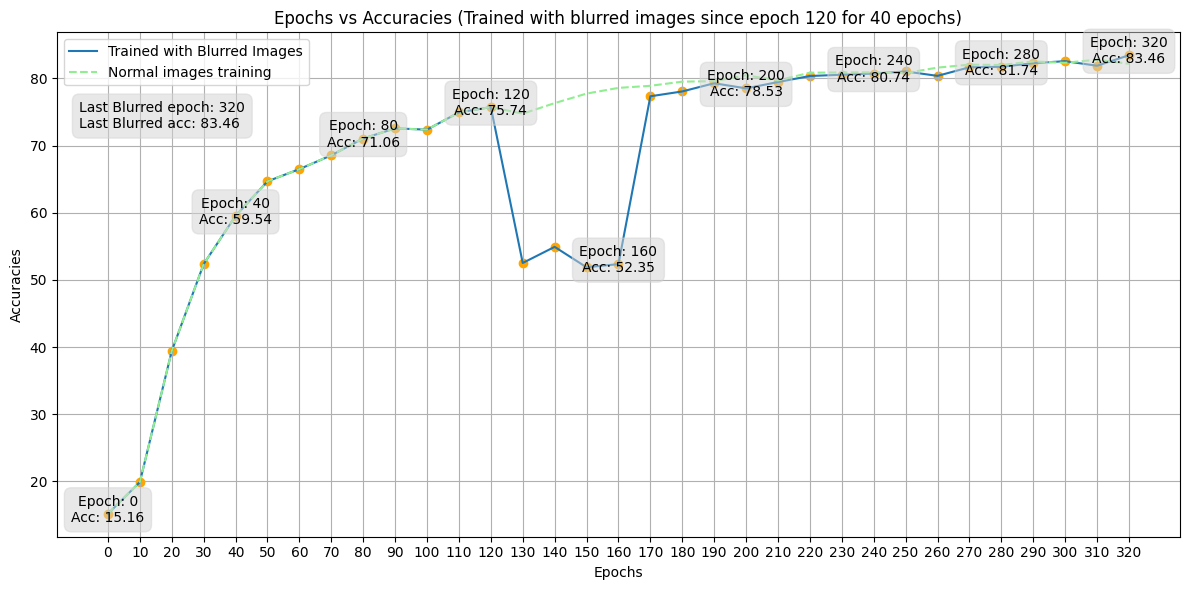

In [ ]:
pretrained_epochs = model_data['pretrained_epochs']
checkpoint_save_path = std_text + f"/40epochs_blur_checkpts/40Blurred_from_120.pt"
save_model(began_blur_epoch=pretrained_epochs,
           model_state_dict=model_info['model'].state_dict(),
           optimizer_state_dict=model_info['optimizer'].state_dict(),
           final_accuracy=round(model_info['final_accuracy'], 2),
           training_data_dict=model_info['training_data_dict'],
           checkpt_path=checkpoint_save_path)

plot_path = std_text + f"/Graficos/Blur training graphs/Blur_training_from_120.png"
save_plot(plot_path, model_info['training_data_dict'], '120', blur=True)

## 5.1. Generar gráfico de precisión vs época en donde se comenzó a entrenar con blur

In [ ]:
cant_archivos = 10 # cambiarlo a la cantidad de modelos que ya se encuentren en la carpeta 40epochs_blur_checkpoints

model_paths = [f"/content/gdrive/MyDrive/Christ Diego Mircea/resultados experimentos/40epochs_blur_checkpts/40Blurred_from_{10*i}.pt" for i in range(1,cant_archivos)]
accuracies = []
begin_epoch = [10*i for i in range(1,cant_archivos)]

for path in model_paths:
  model_data = torch.load(path)
  accuracies.append(model_data['final_accuracy'])

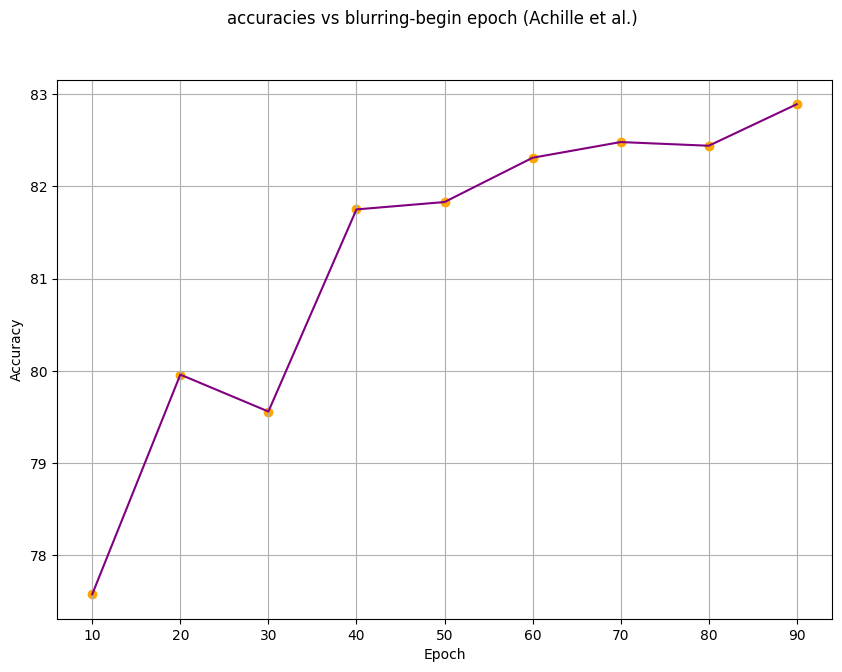

In [ ]:

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(begin_epoch, accuracies, color='purple')
ax.grid()
ax.scatter(begin_epoch, accuracies, color='orange')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.suptitle('accuracies vs blurring-begin epoch (Achille et al.)');

In [ ]:
save_path = f"/content/gdrive/MyDrive/Christ Diego Mircea/resultados experimentos/Graficos/Acc Vs Epoch  (Epoch when blurred training began).png"
plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)

<Figure size 640x480 with 0 Axes>